<a href="https://colab.research.google.com/github/sghoreishi2021/QuadTree_Based_Approach/blob/main/QuadtreeVisulization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

csv_file = '/content/segmented_trip_depth9_1year.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file)

grouped = df.groupby('trip_number')


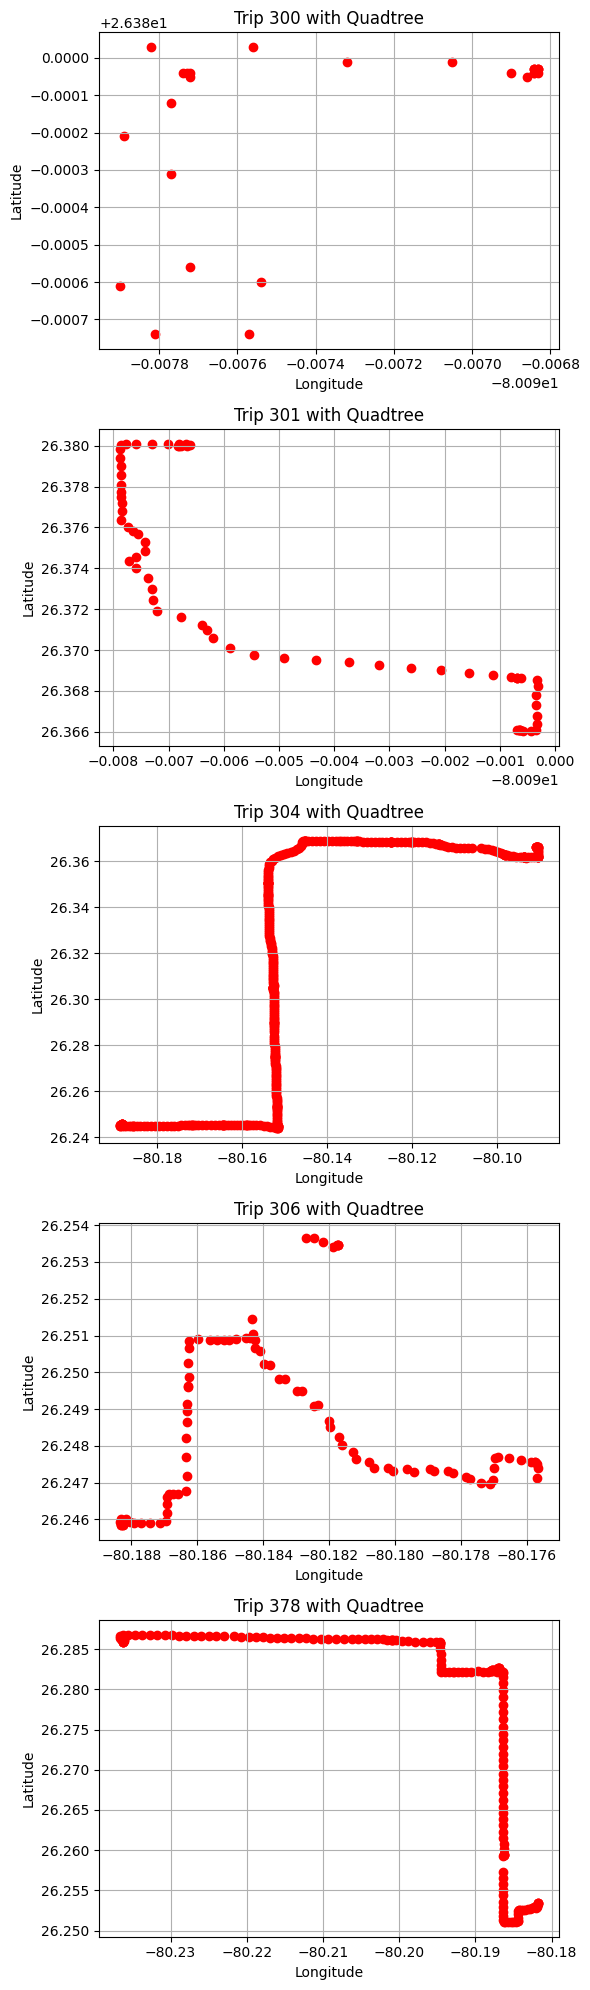

In [ ]:
MAX_POINTS_PER_NODE = 5  # Maximum number of points per quadtree node

class Point:
    def __init__(self, lat, lon):
        self.lat = lat
        self.lon = lon

class BoundingBox:
    def __init__(self, min_lat, min_lon, max_lat, max_lon):
        self.min_lat = min_lat
        self.min_lon = min_lon
        self.max_lat = max_lat
        self.max_lon = max_lon

    def contains(self, point):
        return (self.min_lat <= point.lat <= self.max_lat and
                self.min_lon <= point.lon <= self.max_lon)

    def intersects(self, point):
        return (self.min_lat <= point.lat <= self.max_lat or
                self.min_lon <= point.lon <= self.max_lon)

class QuadTreeNode:
    def __init__(self, boundary):
        self.boundary = boundary  # Boundary of the node (bounding box)
        self.points = []  # List of points contained in this node
        self.children = [None, None, None, None]  # Children nodes (NW, NE, SW, SE)

    def insert(self, point):
        if not self.boundary.contains(point):
            return False

        if len(self.points) < MAX_POINTS_PER_NODE:
            self.points.append(point)
            return True

        if self.children[0] is None:
            self.subdivide()

        for child in self.children:
            if child.insert(point):
                return True

        return False

    def subdivide(self):
        min_lat, min_lon, max_lat, max_lon = self.boundary.min_lat, self.boundary.min_lon, self.boundary.max_lat, self.boundary.max_lon
        mid_lat = (min_lat + max_lat) / 2
        mid_lon = (min_lon + max_lon) / 2

        nw_boundary = BoundingBox(mid_lat, min_lon, max_lat, mid_lon)
        ne_boundary = BoundingBox(mid_lat, mid_lon, max_lat, max_lon)
        sw_boundary = BoundingBox(min_lat, min_lon, mid_lat, mid_lon)
        se_boundary = BoundingBox(min_lat, mid_lon, mid_lat, max_lon)

        self.children[0] = QuadTreeNode(nw_boundary)
        self.children[1] = QuadTreeNode(ne_boundary)
        self.children[2] = QuadTreeNode(sw_boundary)
        self.children[3] = QuadTreeNode(se_boundary)

        for point in self.points:
            for child in self.children:
                if child.insert(point):
                    break
        self.points = []

    def query_range(self, range_boundary):
        found_points = []

        if not self.boundary.intersects(range_boundary):
            return found_points

        for point in self.points:
            if range_boundary.contains(point):
                found_points.append(point)

        if self.children[0] is not None:
            for child in self.children:
                found_points.extend(child.query_range(range_boundary))

        return found_points

def draw_quadtree(node, ax):
    if node is not None:
        min_lat, min_lon, max_lat, max_lon = node.boundary.min_lat, node.boundary.min_lon, node.boundary.max_lat, node.boundary.max_lon
        ax.plot([min_lon, max_lon], [min_lat, min_lat], color='black')  # Draw horizontal line (latitude)
        ax.plot([min_lon, max_lon], [max_lat, max_lat], color='black')  # Draw horizontal line (latitude)
        ax.plot([min_lon, min_lon], [min_lat, max_lat], color='black')  # Draw vertical line (longitude)
        ax.plot([max_lon, max_lon], [min_lat, max_lat], color='black')  # Draw vertical line (longitude)

        for child in node.children:
            draw_quadtree(child, ax)

def plot_points(points, ax):
    lats = [point.lat for point in points]
    lons = [point.lon for point in points]
    ax.scatter(lons, lats, color='red', marker='o')

# Initialize plotting
fig, axs = plt.subplots(len(grouped), 1, figsize=(6, 4 * len(grouped)))

# Step 2: Iterate over each group (each trip) and apply quadtree
for i, (trip_number, group) in enumerate(grouped):
    # Extract latitudes and longitudes for current trip
    points = [Point(row.lat, row.lon) for index, row in group.iterrows()]

    # Define bounding box for current trip
    min_lat = min(points, key=lambda p: p.lat).lat
    max_lat = max(points, key=lambda p: p.lat).lat
    min_lon = min(points, key=lambda p: p.lon).lon
    max_lon = max(points, key=lambda p: p.lon).lon
    trip_boundary = BoundingBox(min_lat, min_lon, max_lat, max_lon)

    # Create quadtree for current trip
    quadtree = QuadTreeNode(trip_boundary)

    # Insert points into quadtree
    for point in points:
        quadtree.insert(point)

    # Visualize quadtree and points for current trip
    ax = axs[i] if len(grouped) > 1 else axs
    #draw_quadtree(quadtree, ax)
    plot_points(points, ax)
    ax.set_title(f'Trip {trip_number} with Quadtree')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

plt.tight_layout()
plt.show()


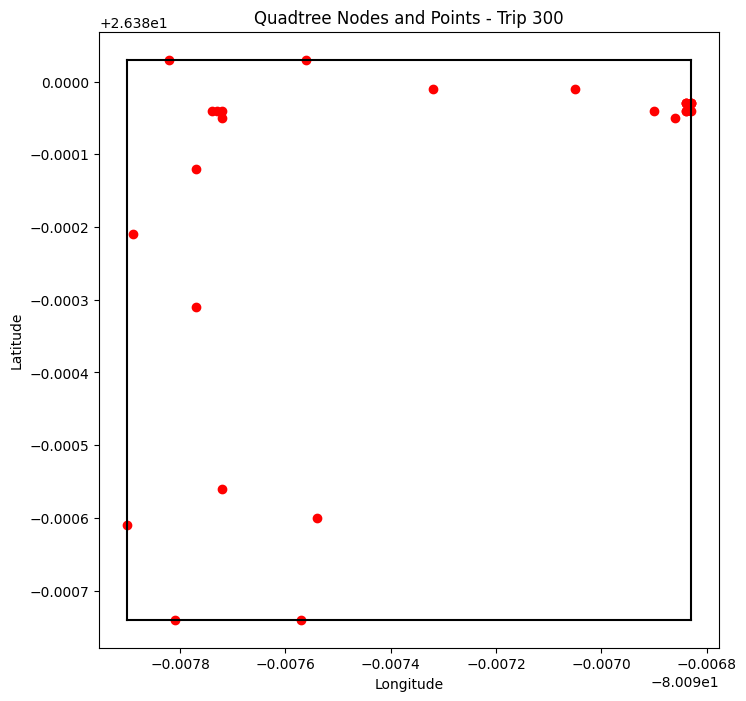

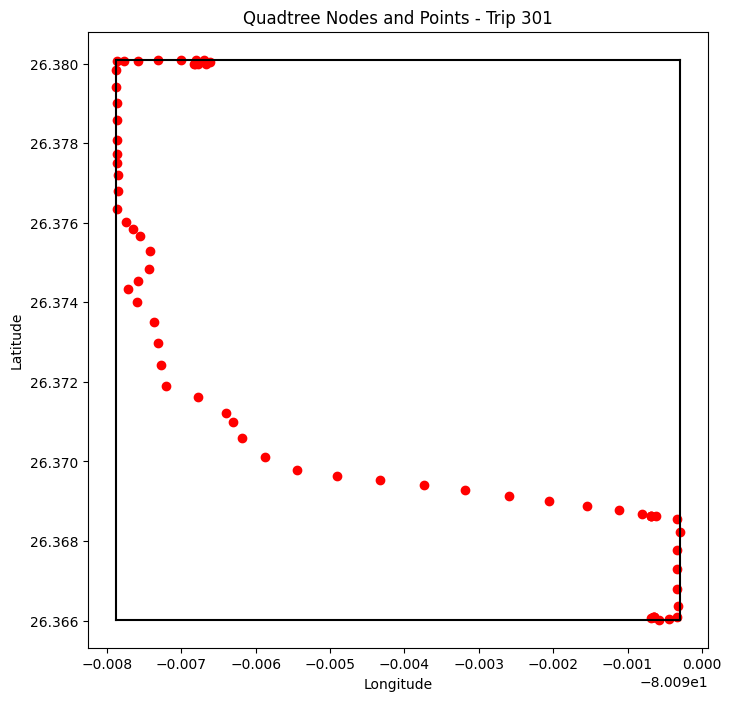

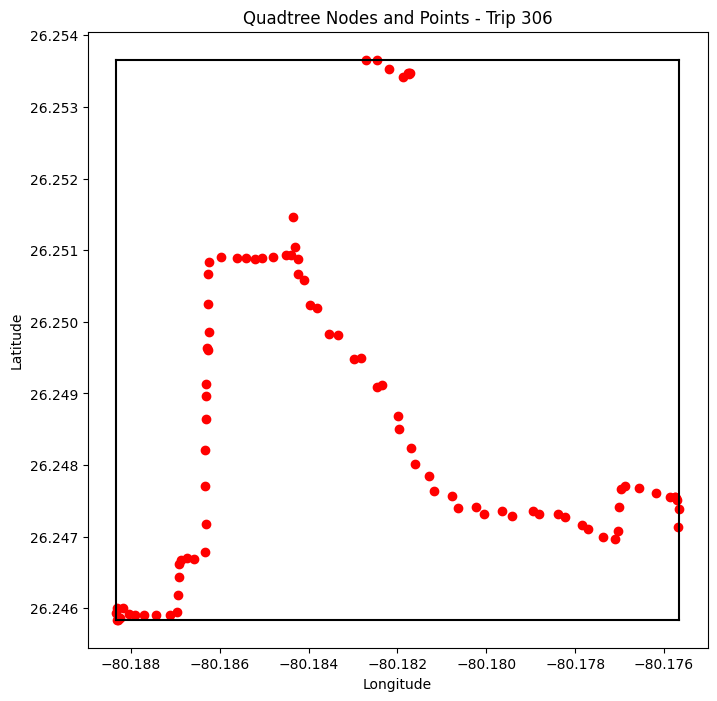

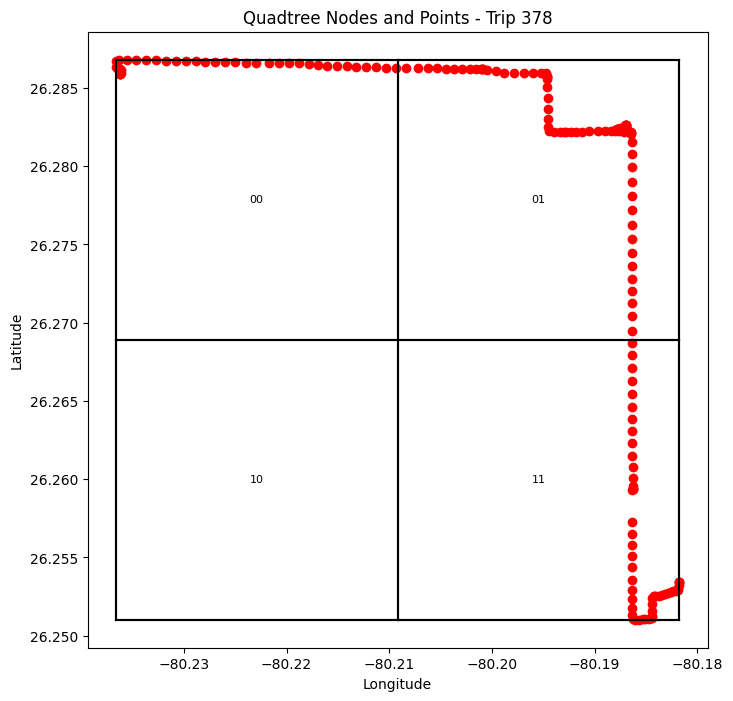

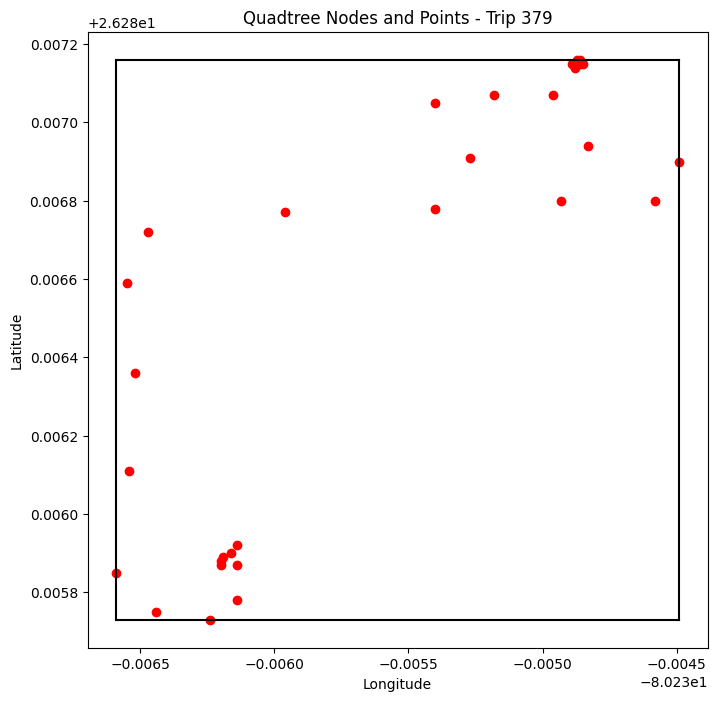

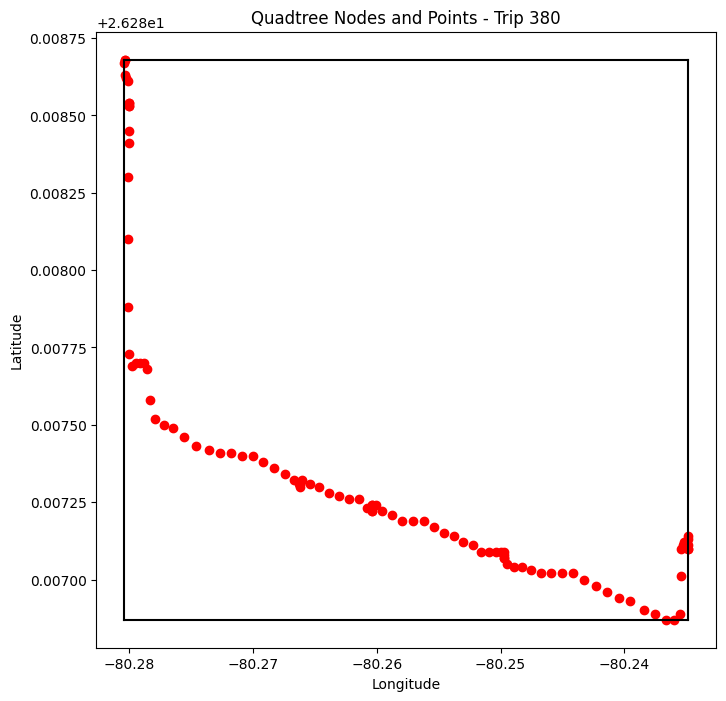

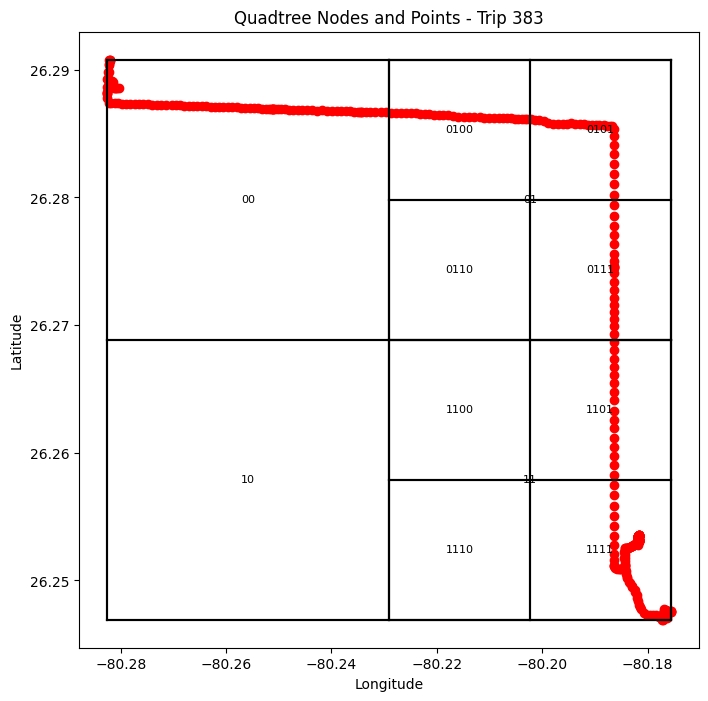

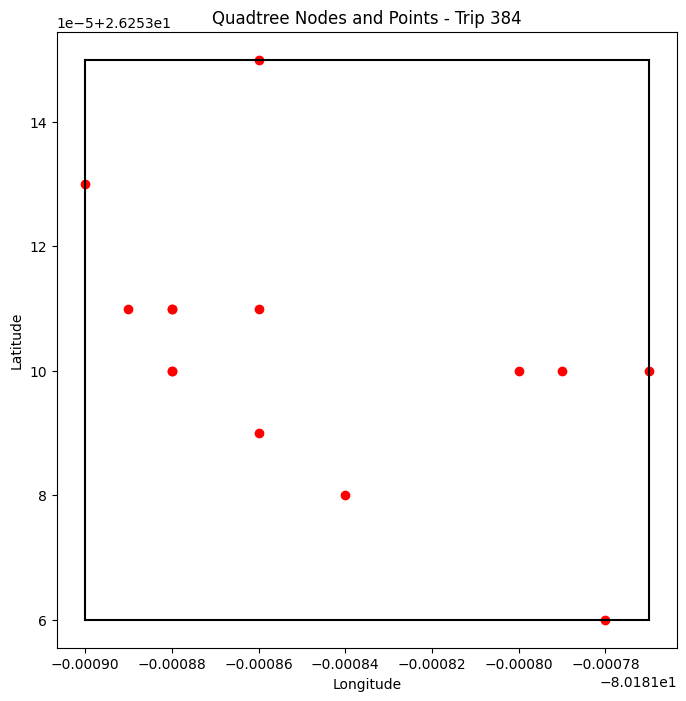

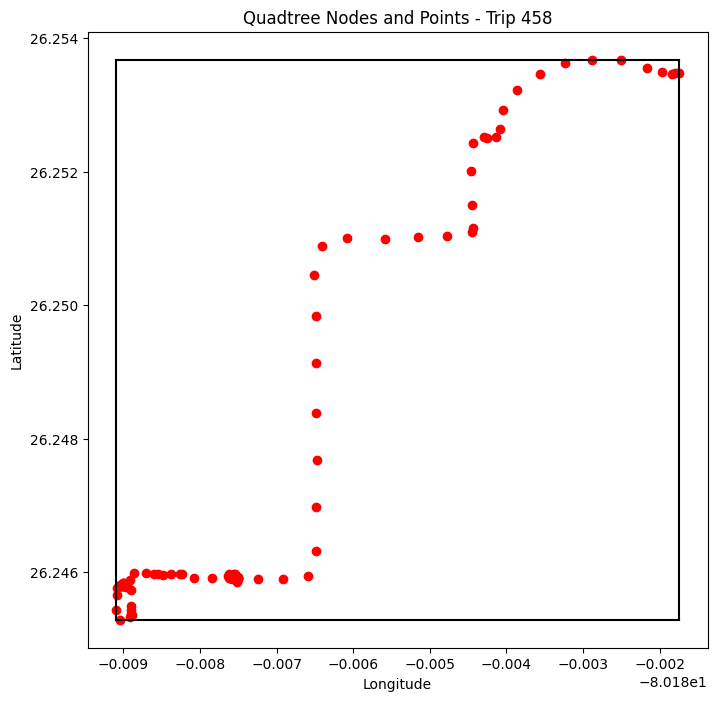

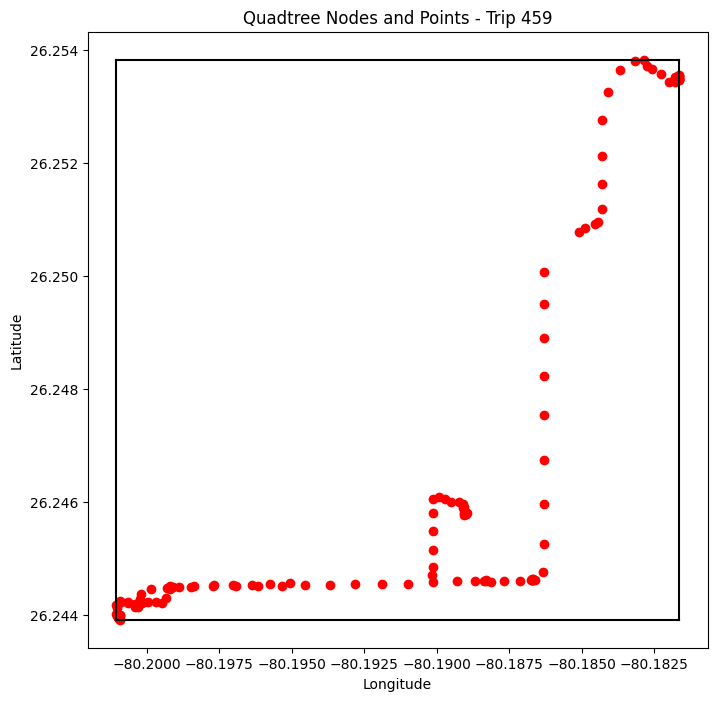

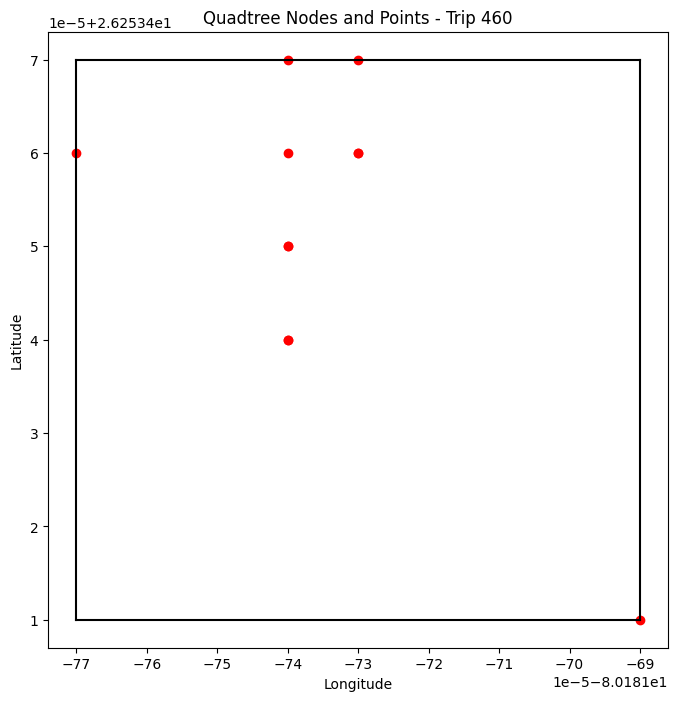

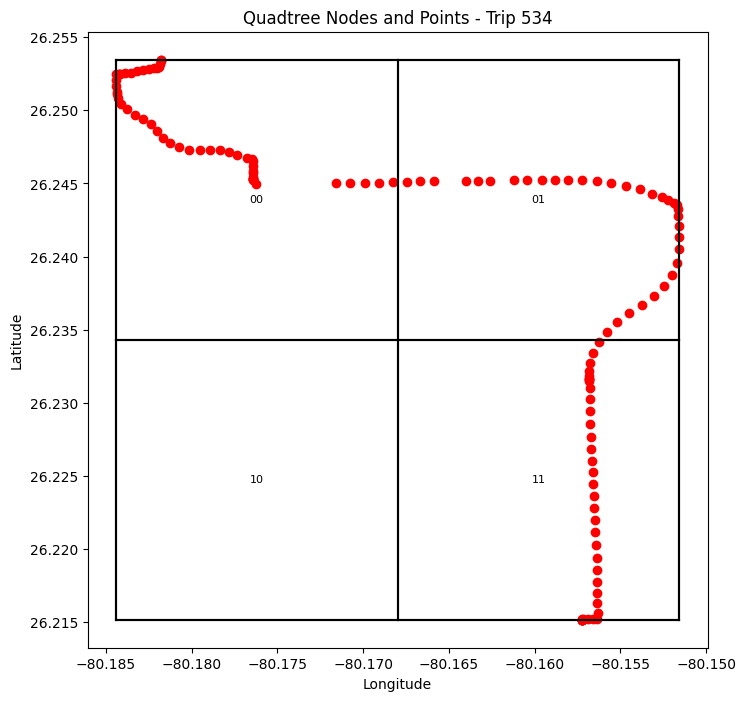

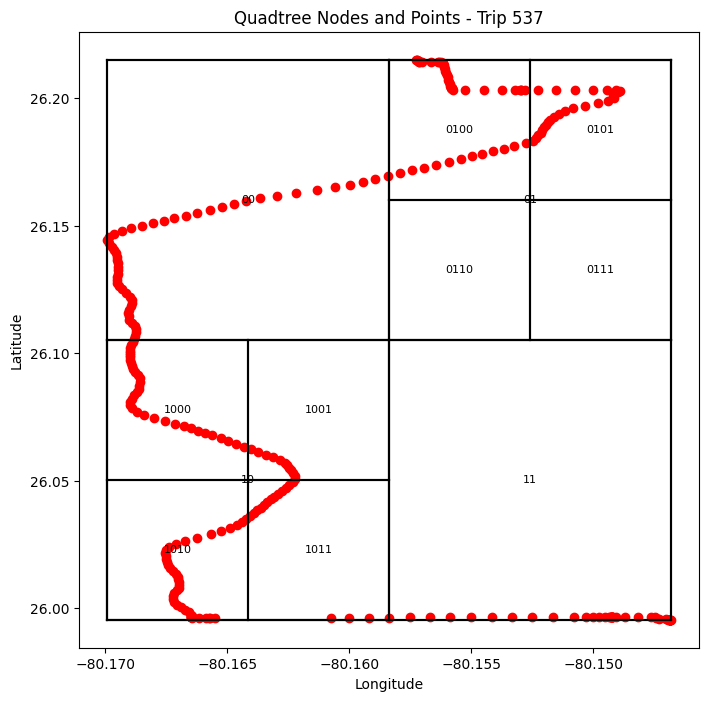

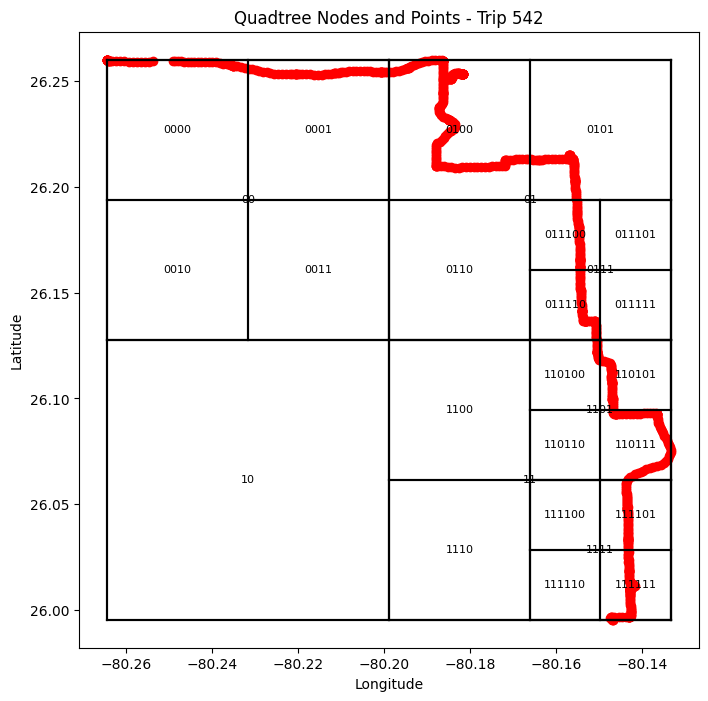

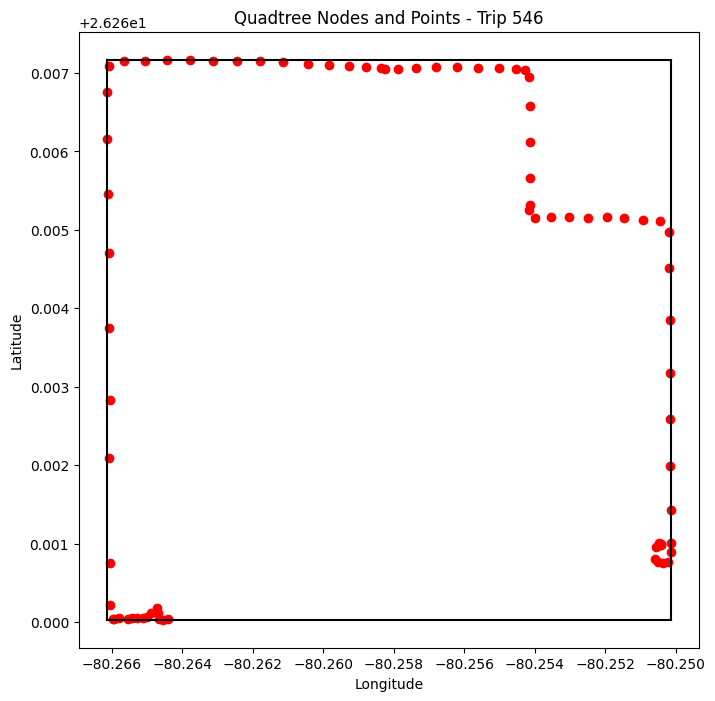

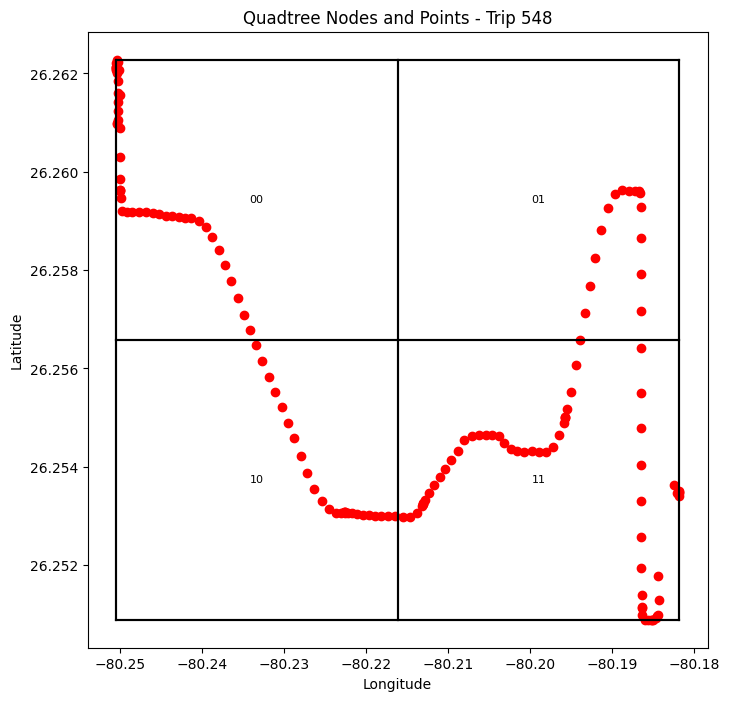

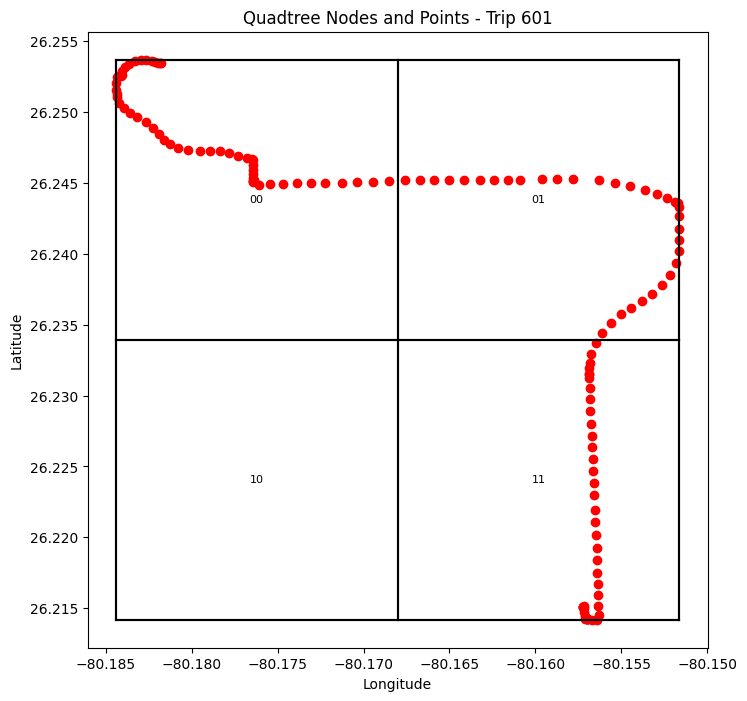

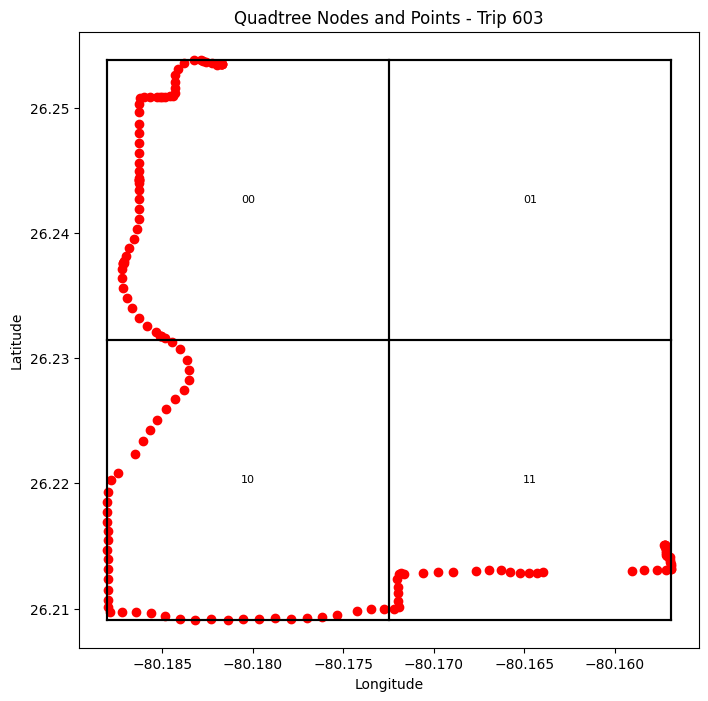

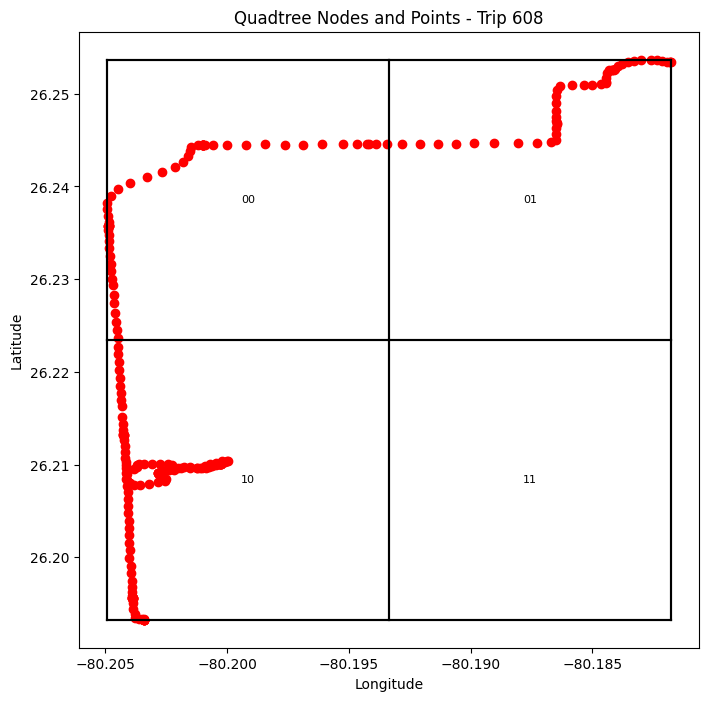

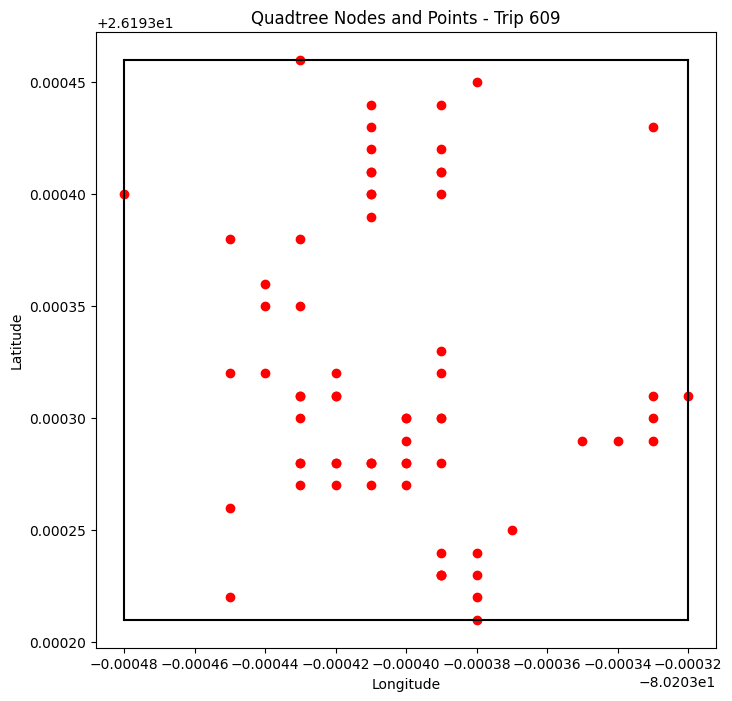

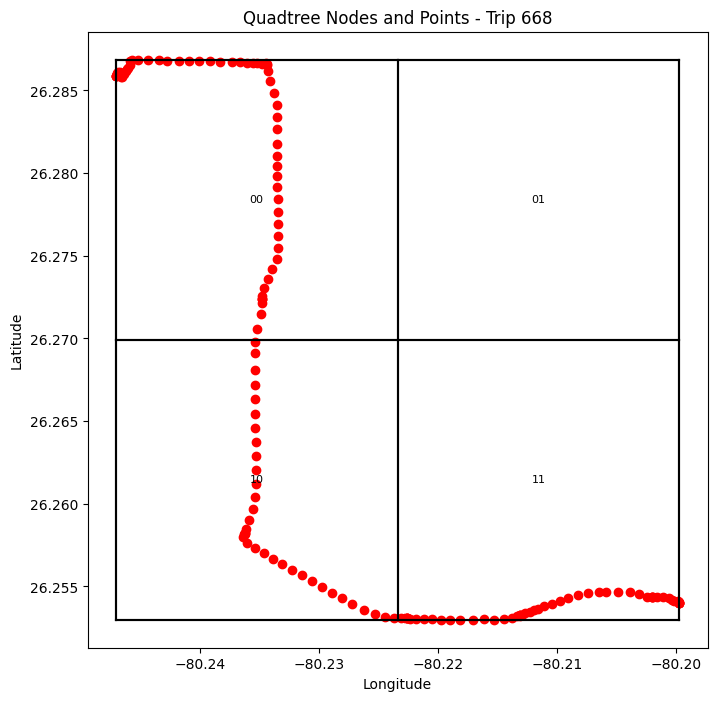

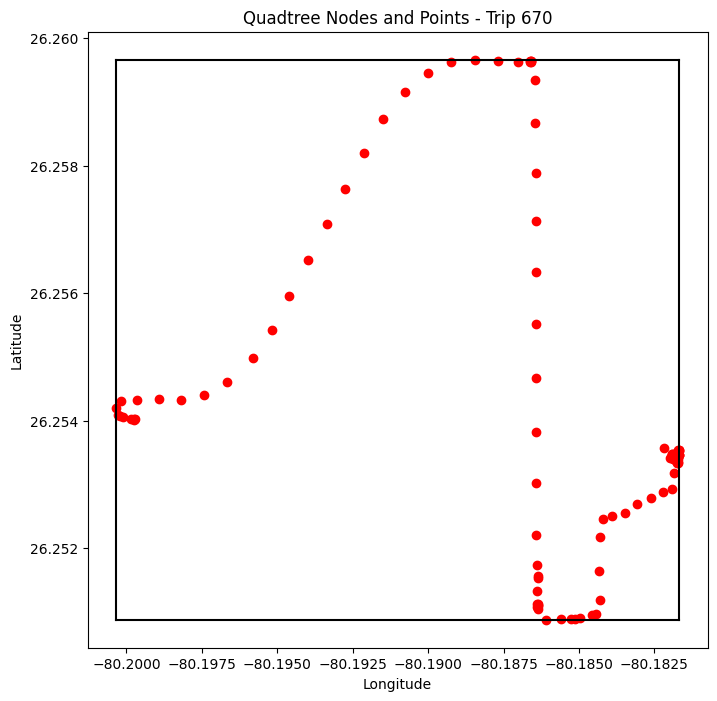

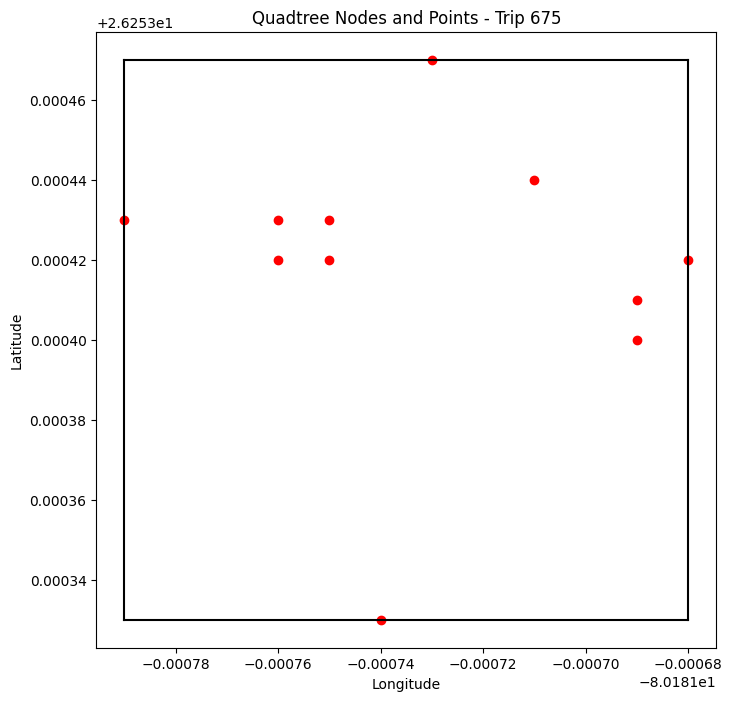

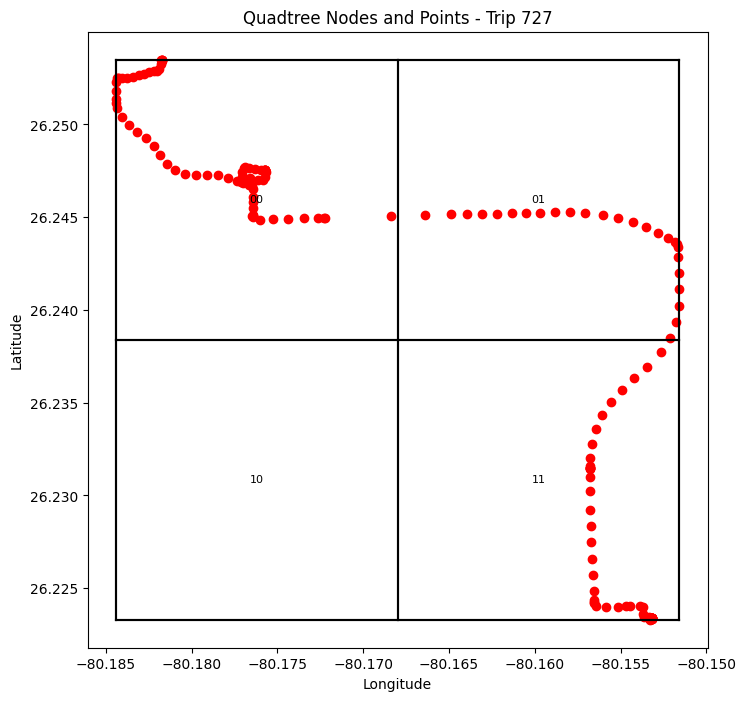

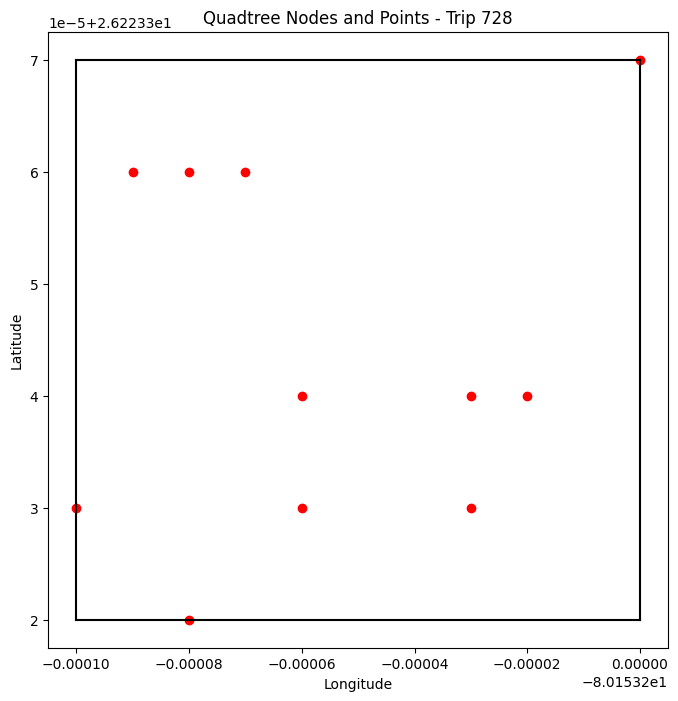

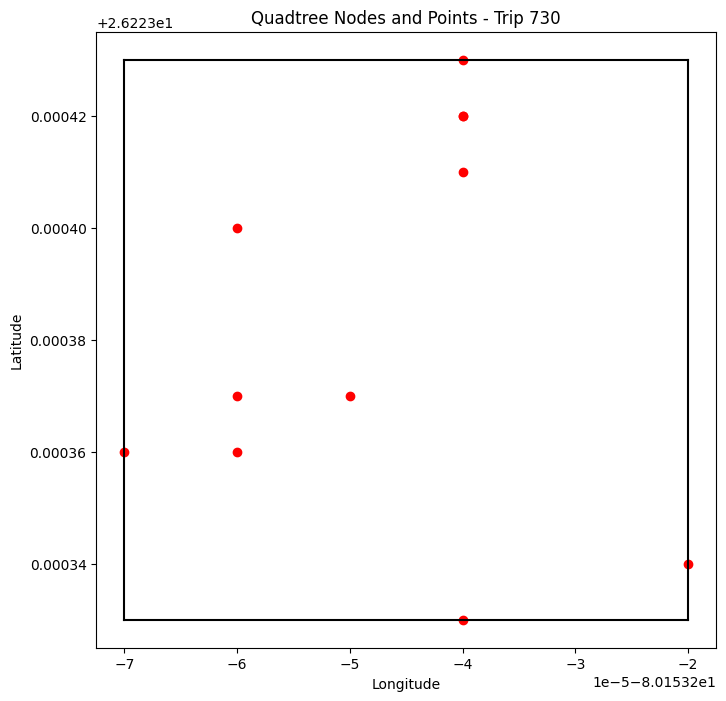

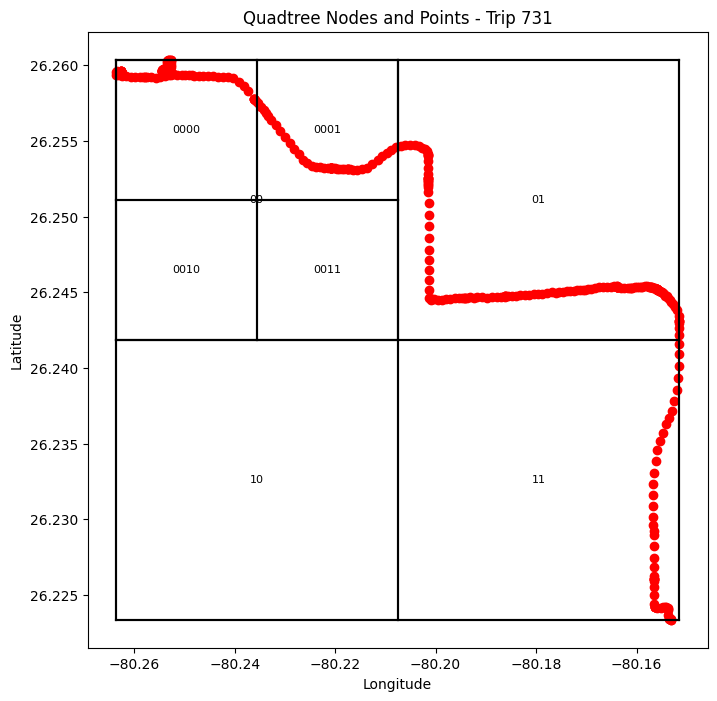

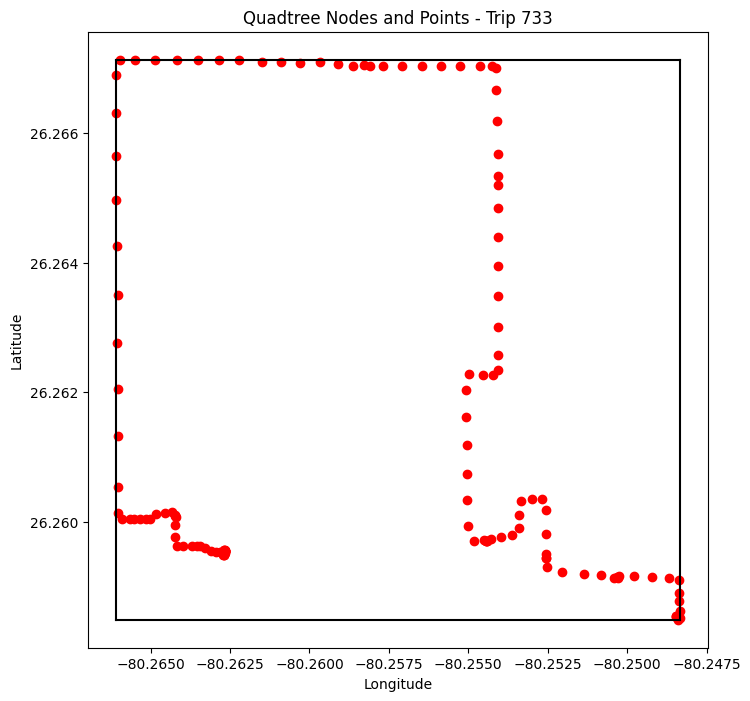

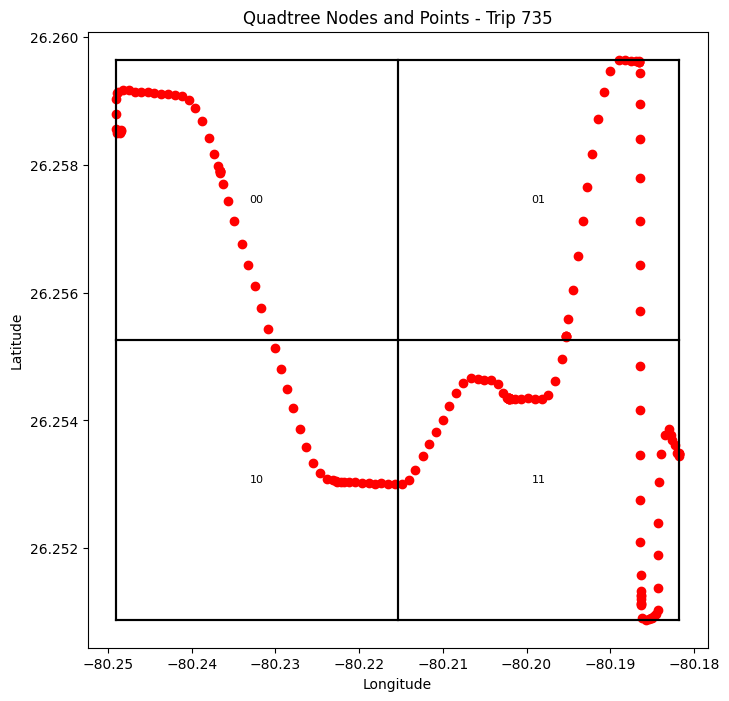

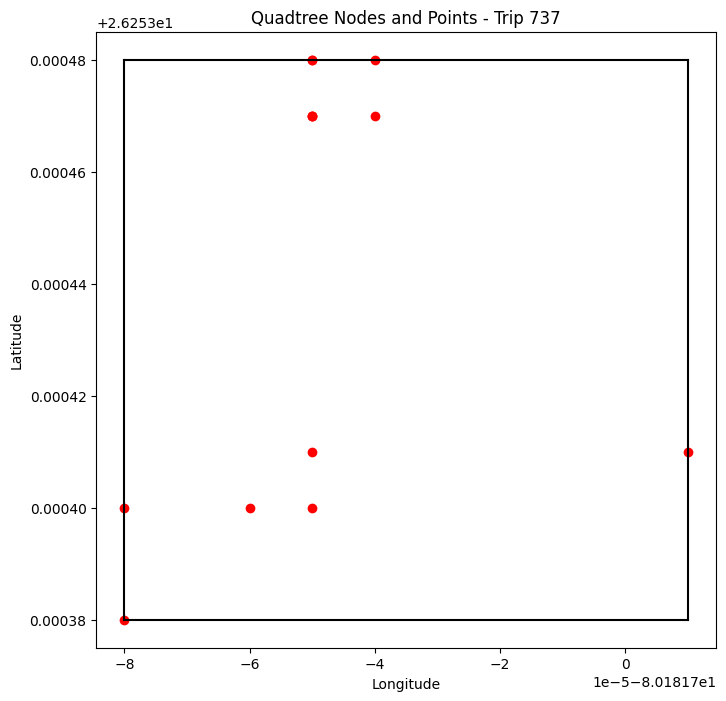

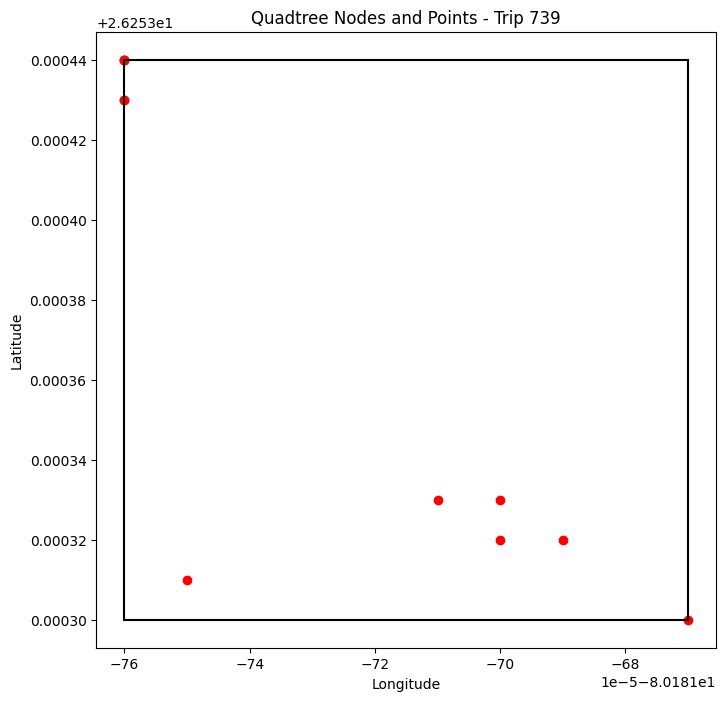

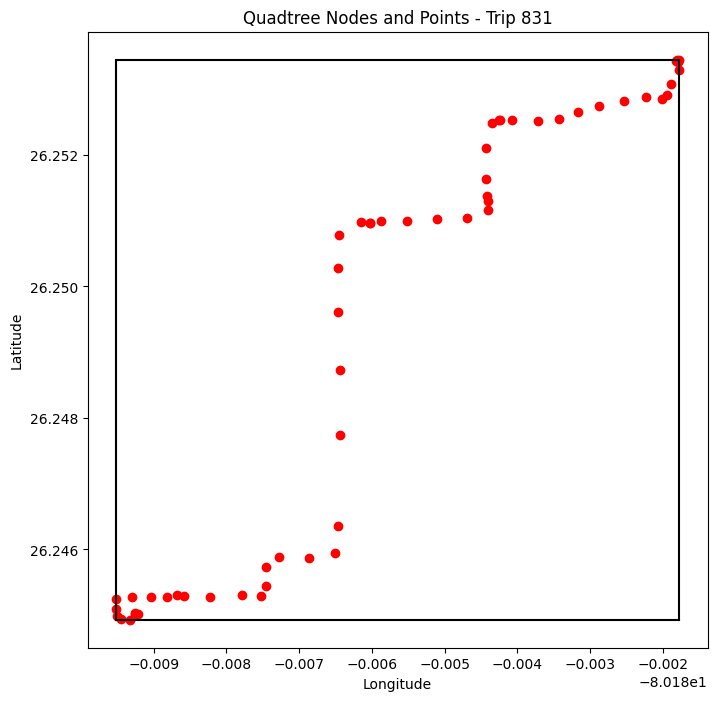

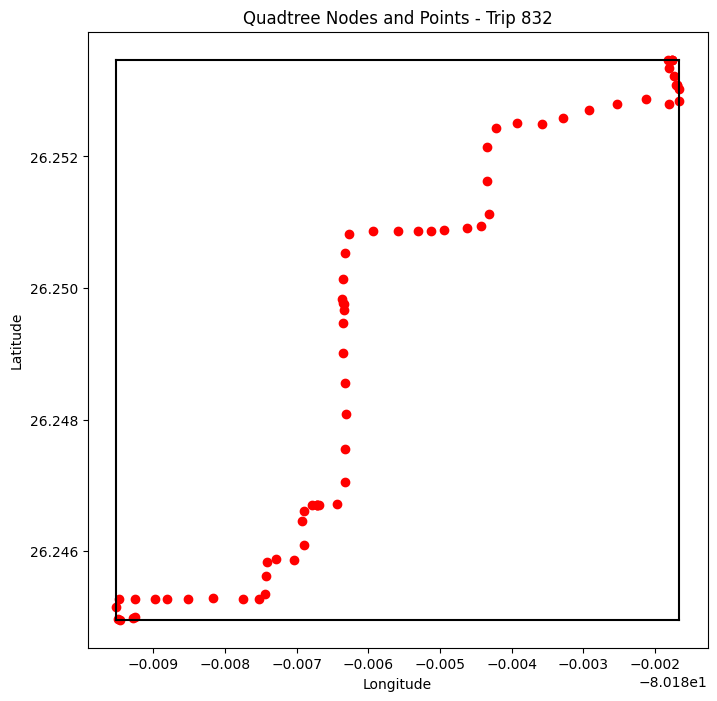

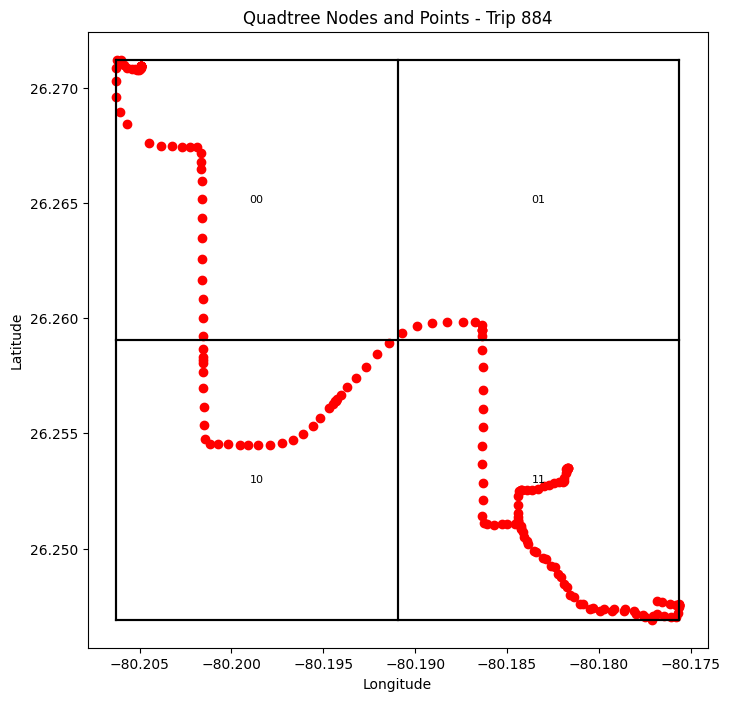

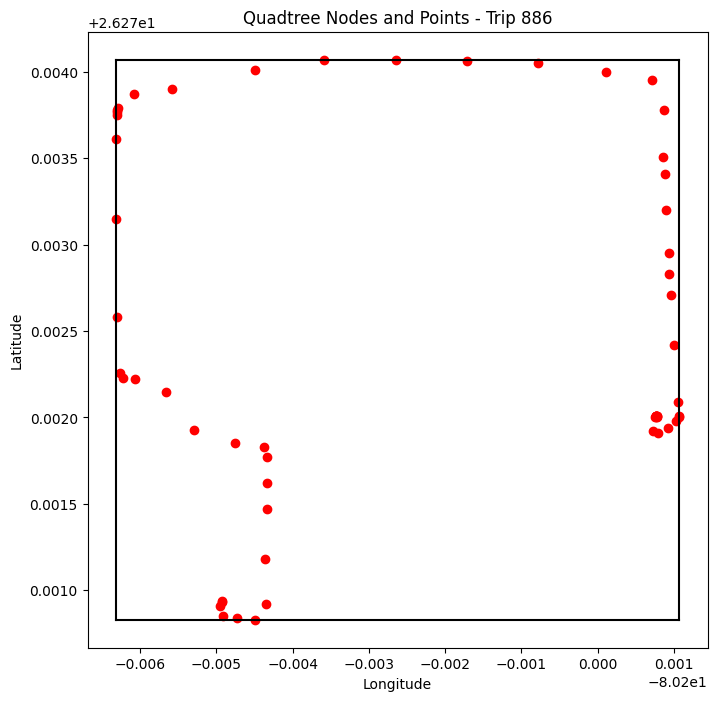

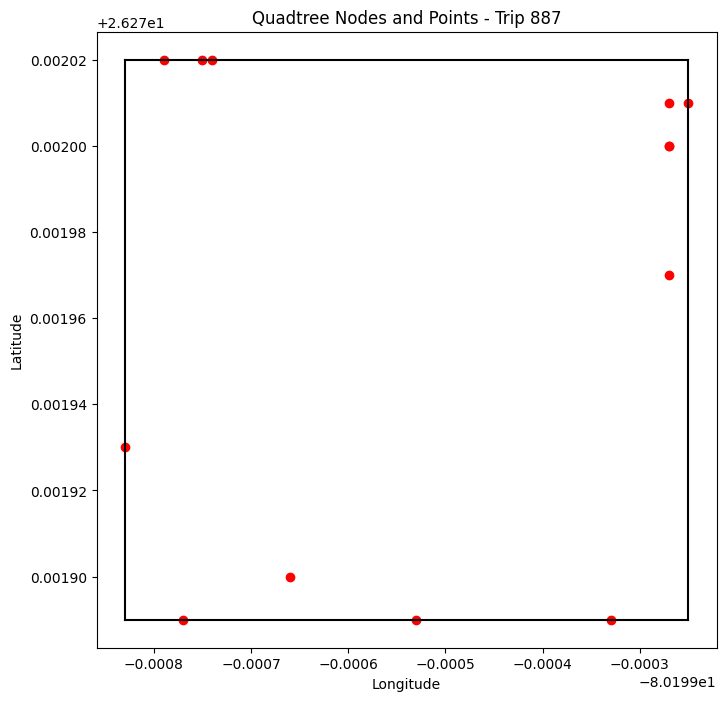

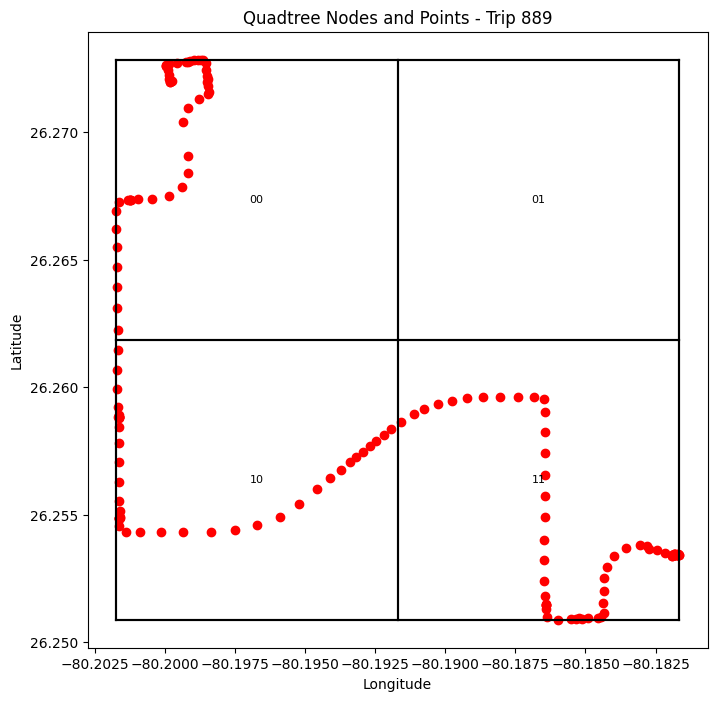

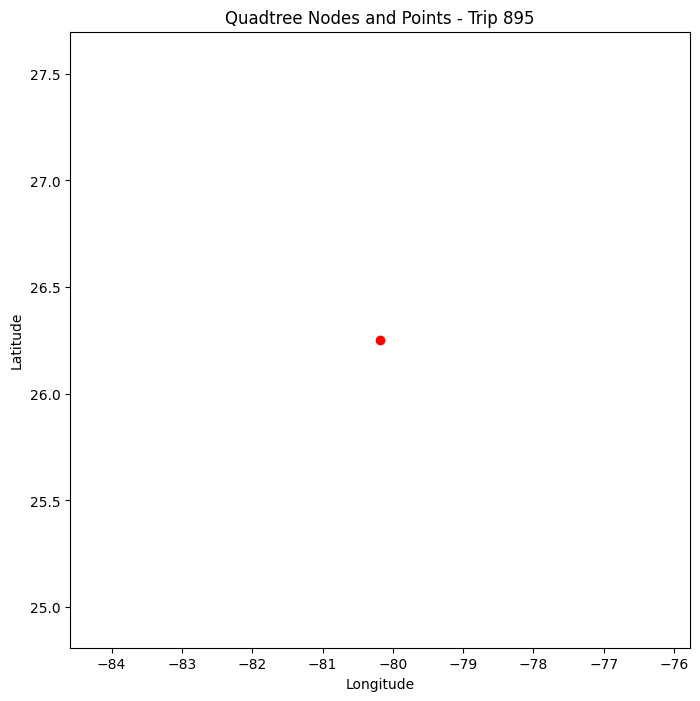

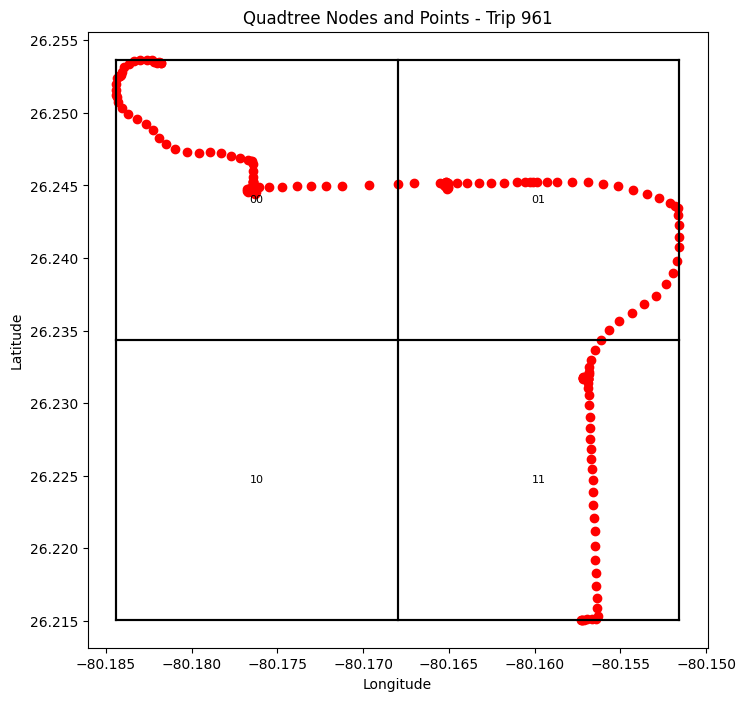

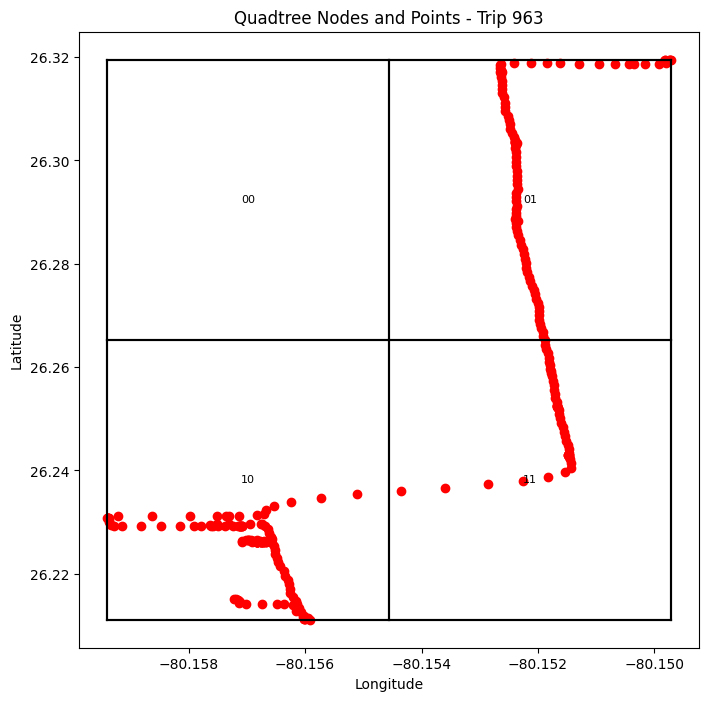

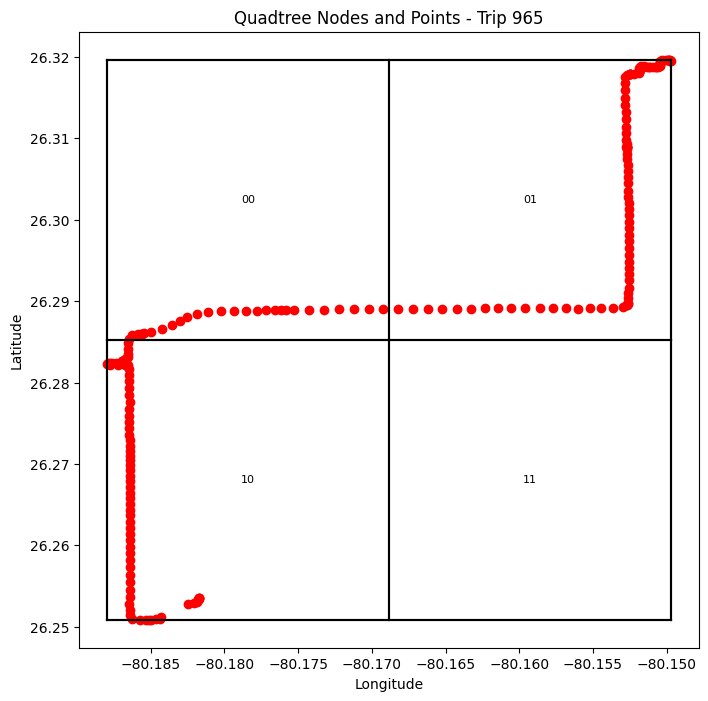

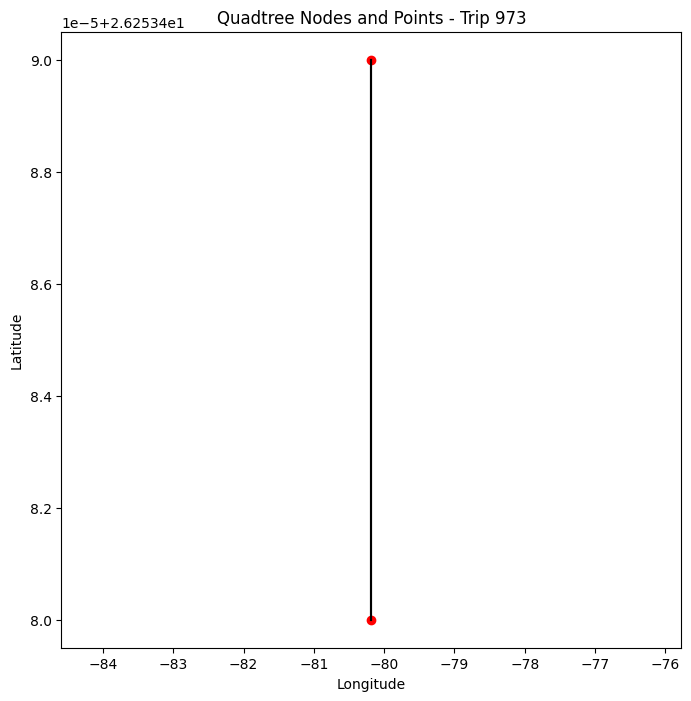

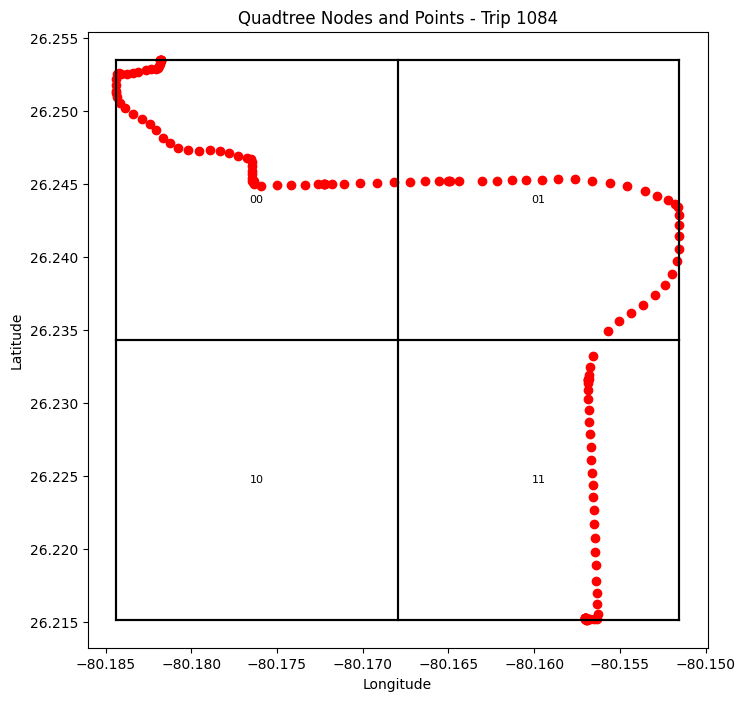

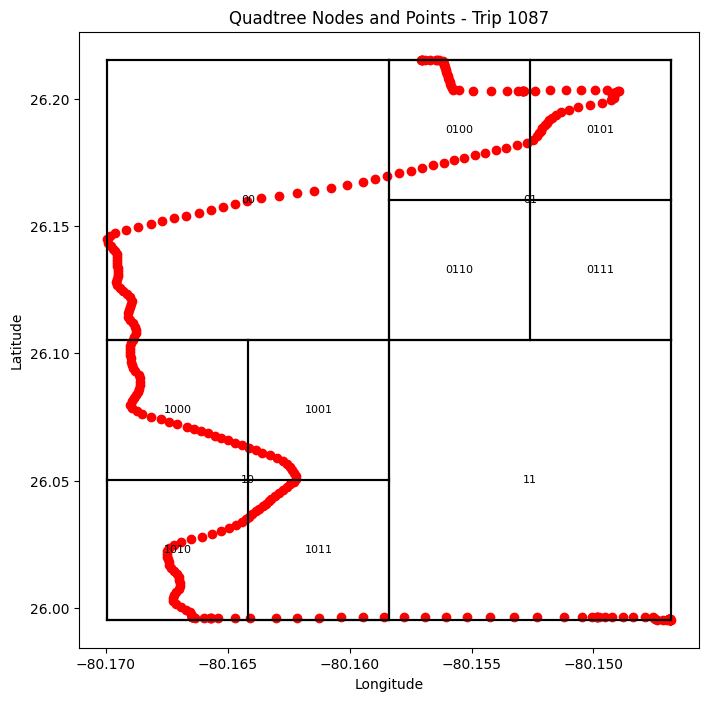

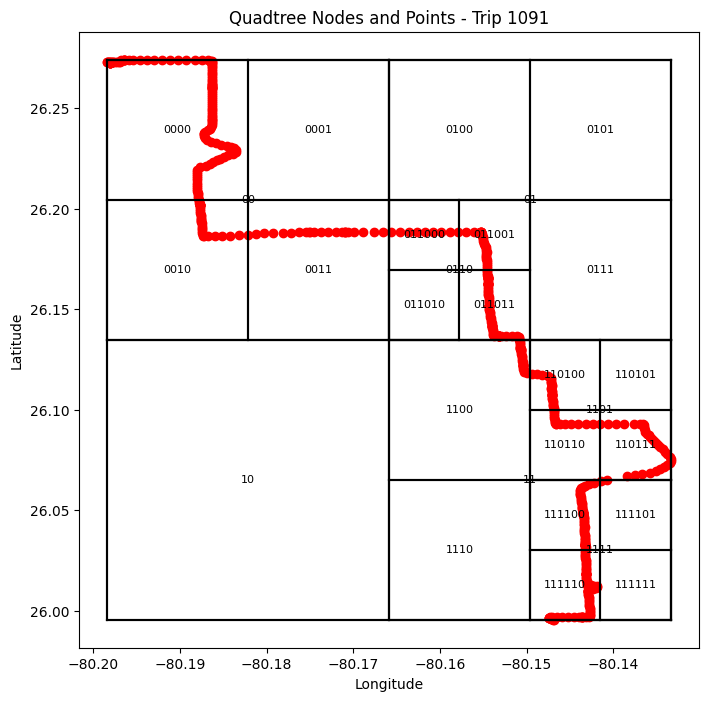

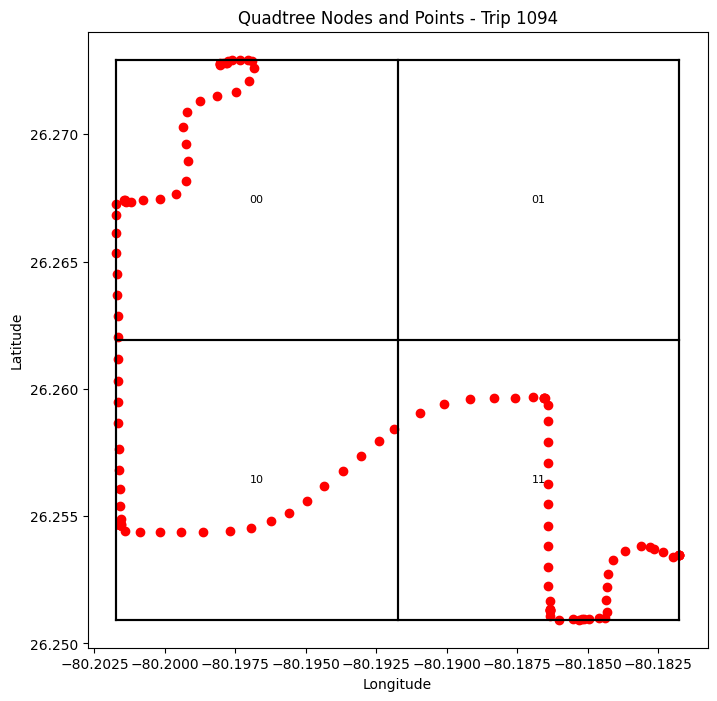

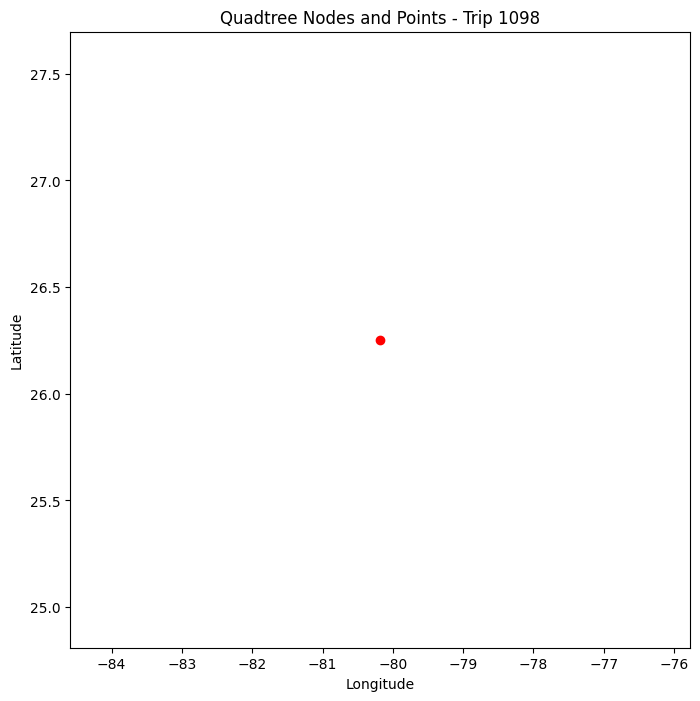

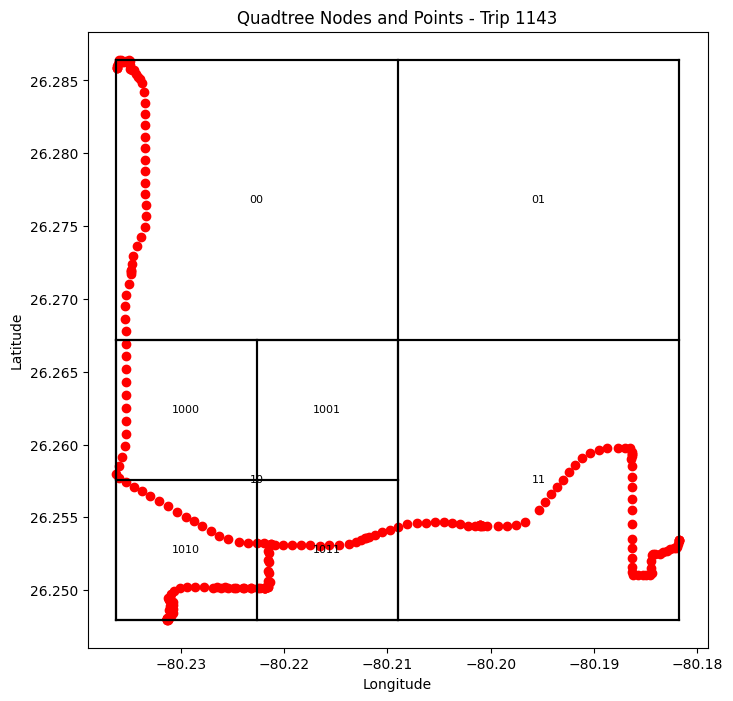

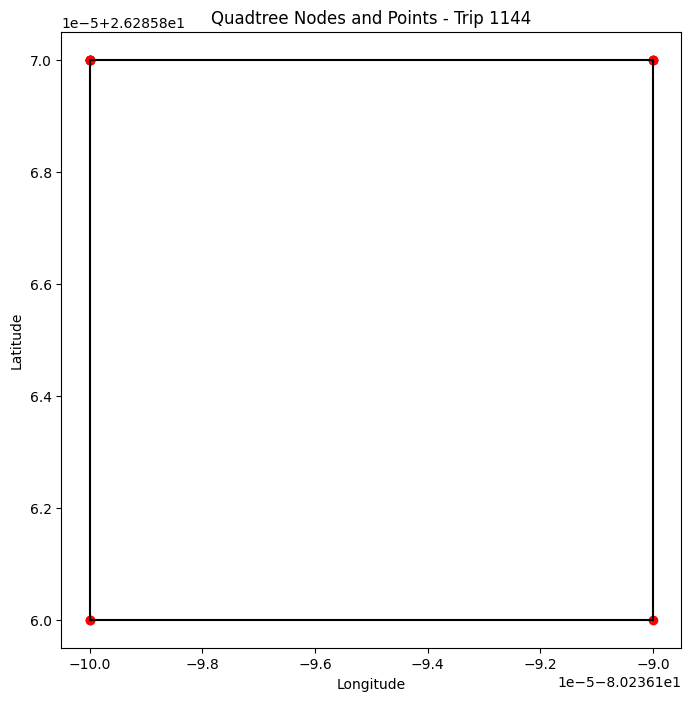

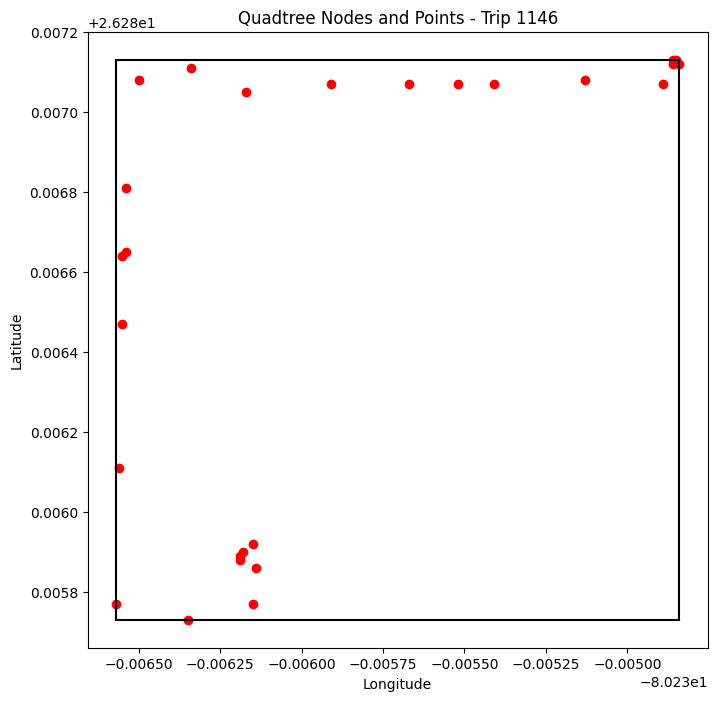

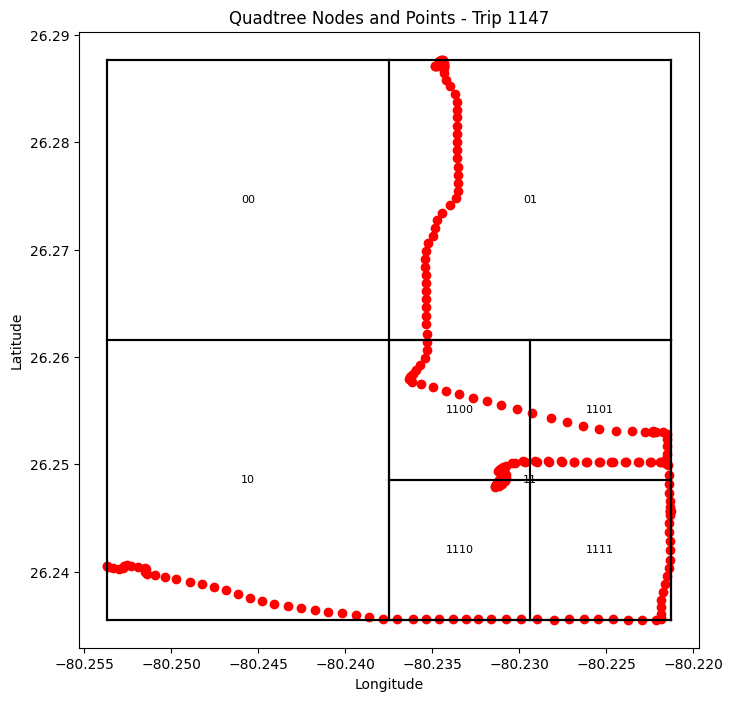

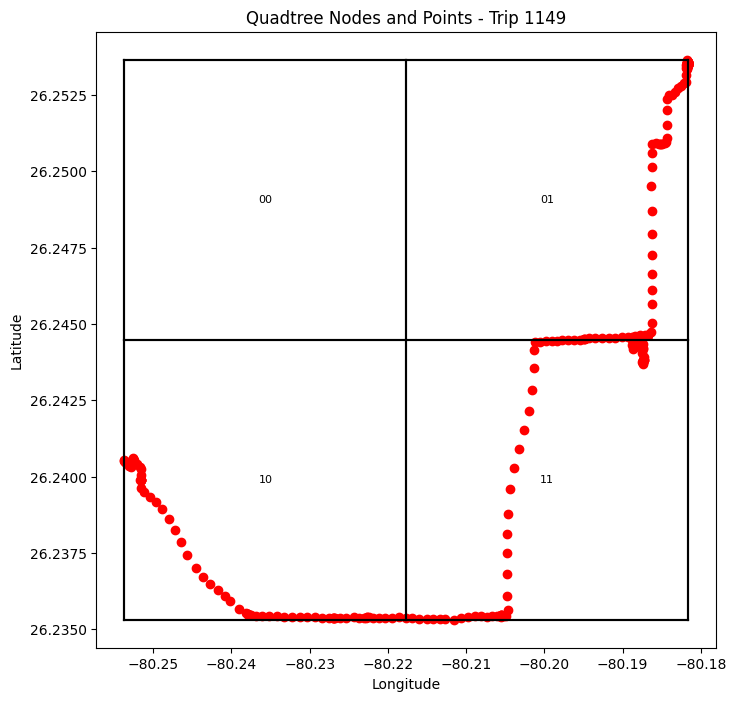

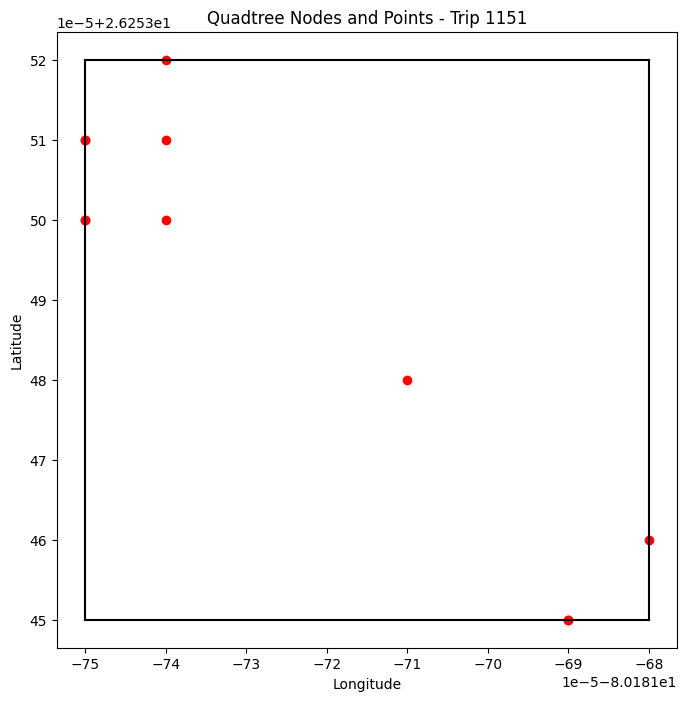

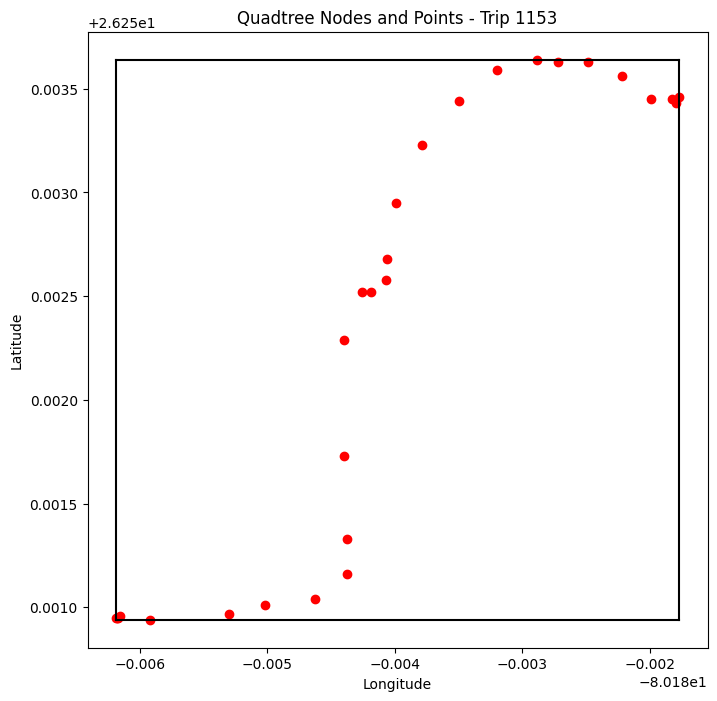

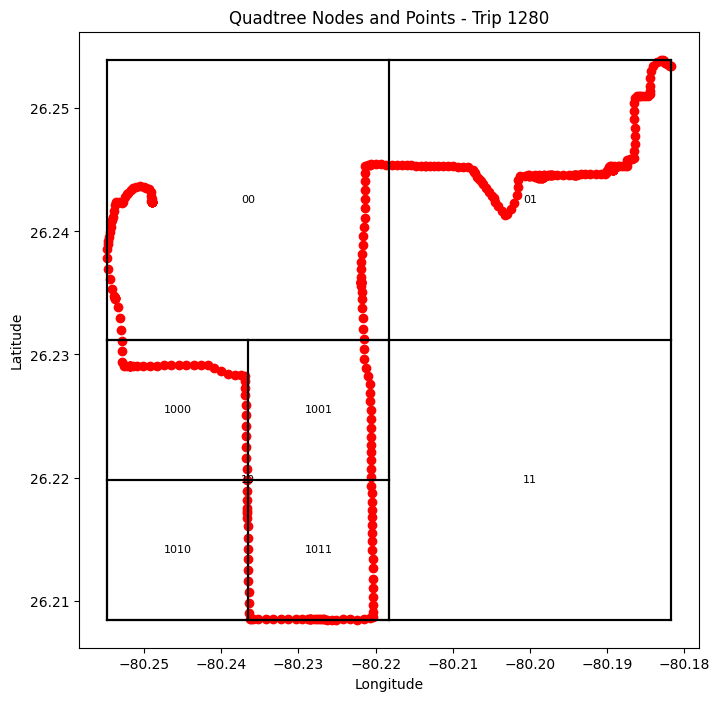

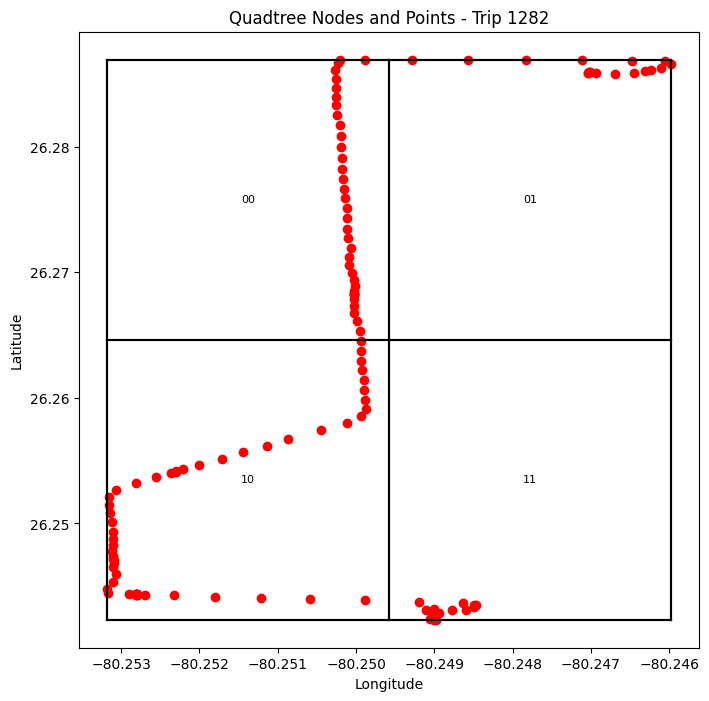

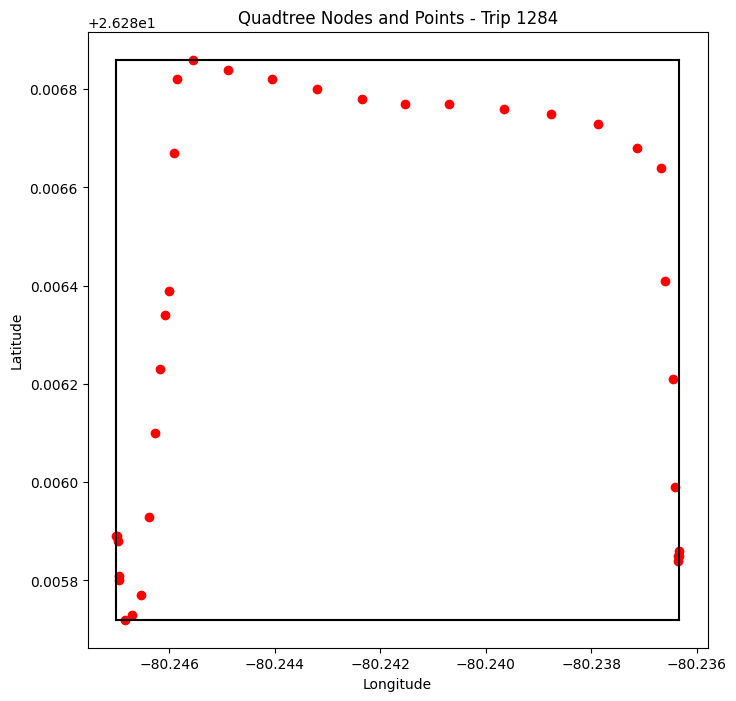

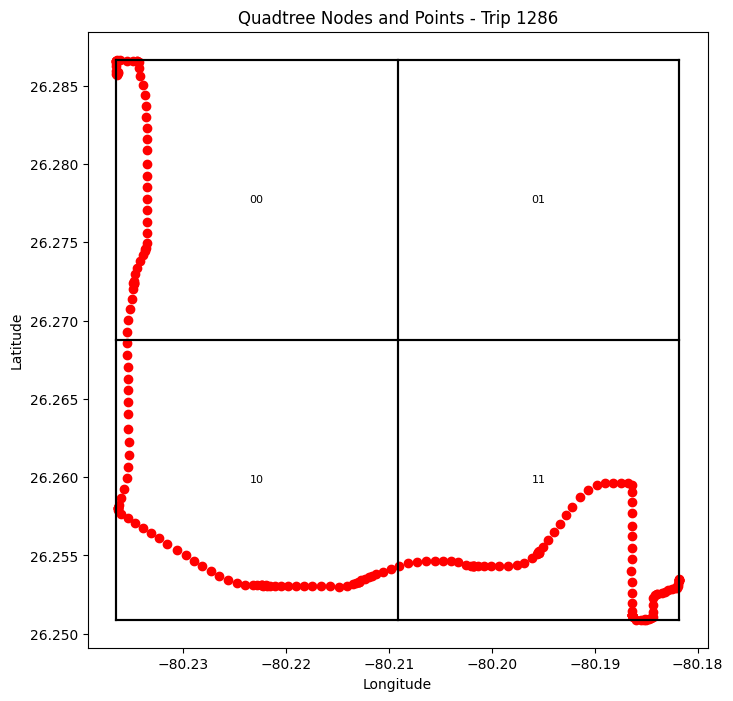

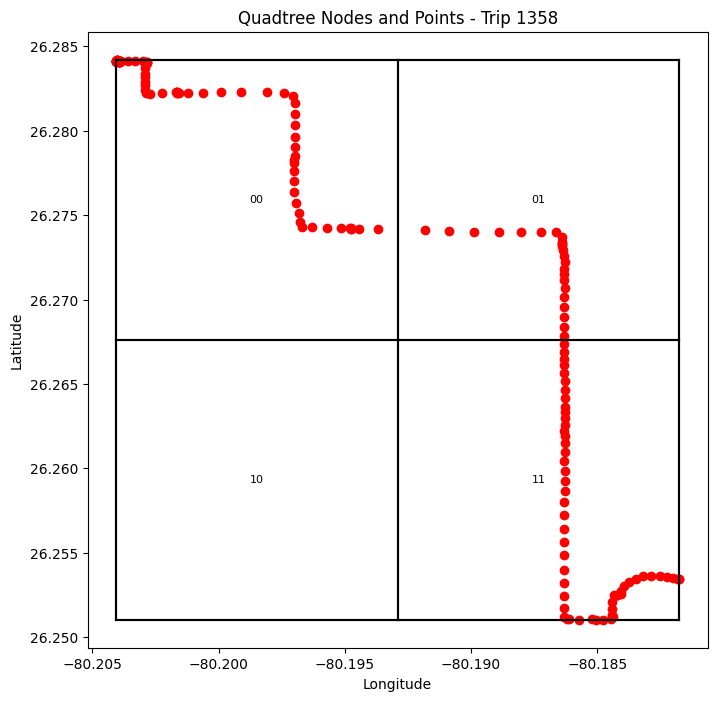

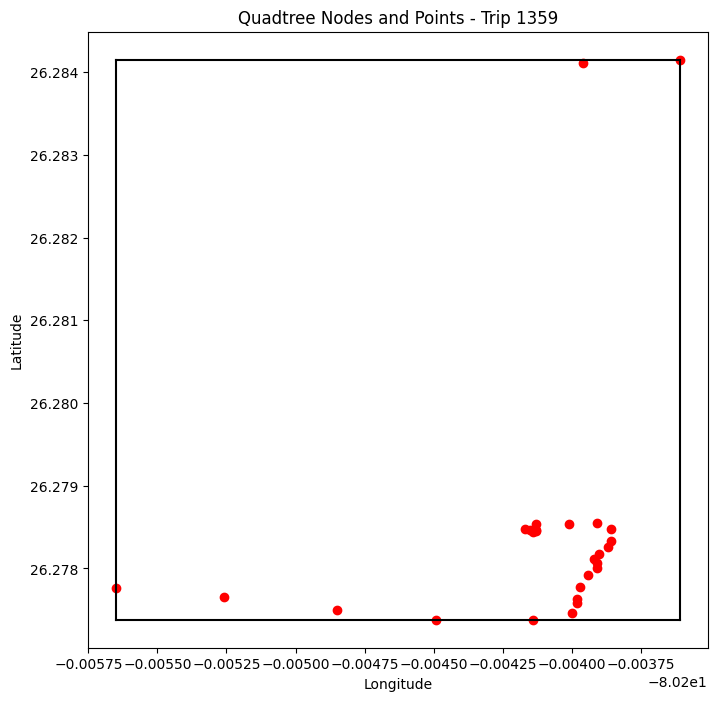

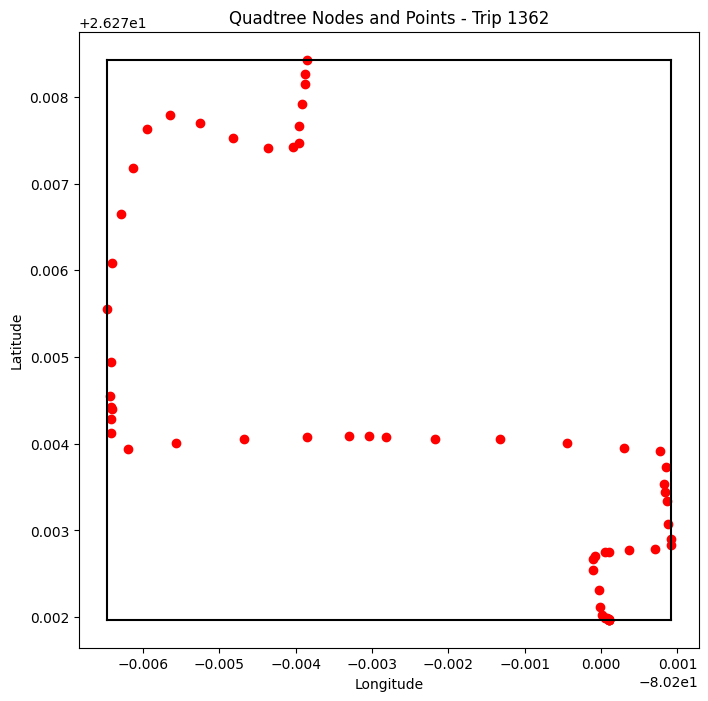

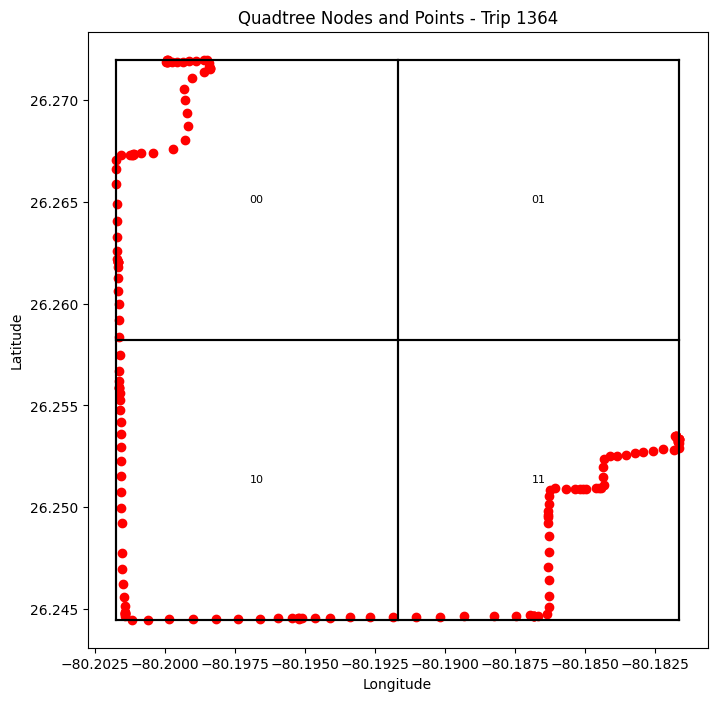

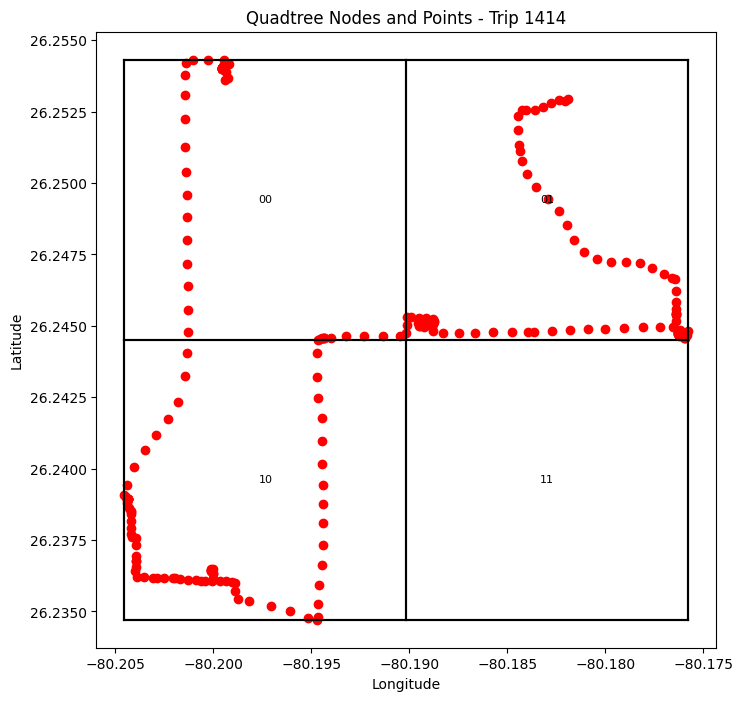

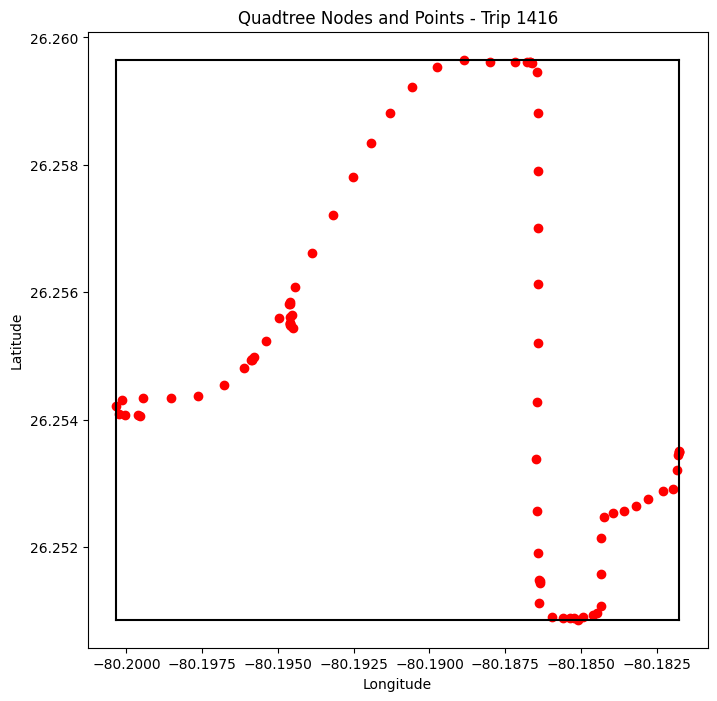

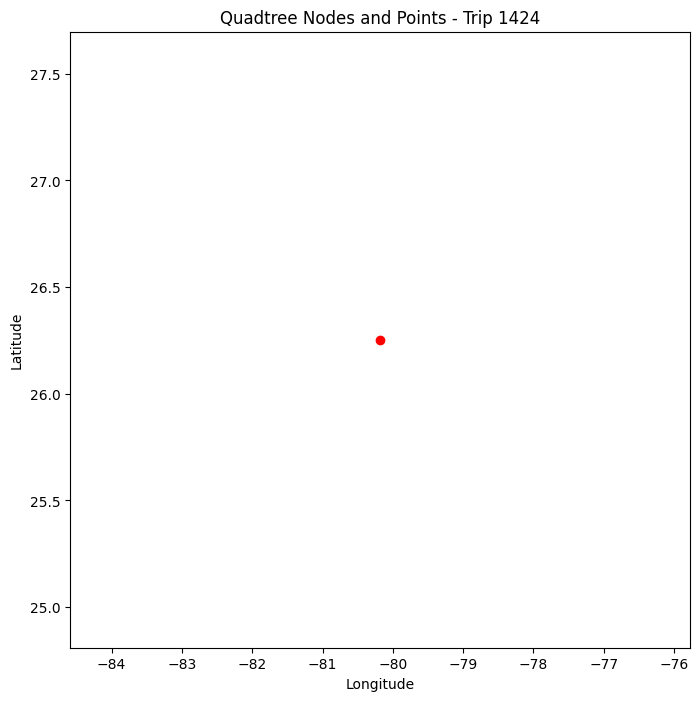

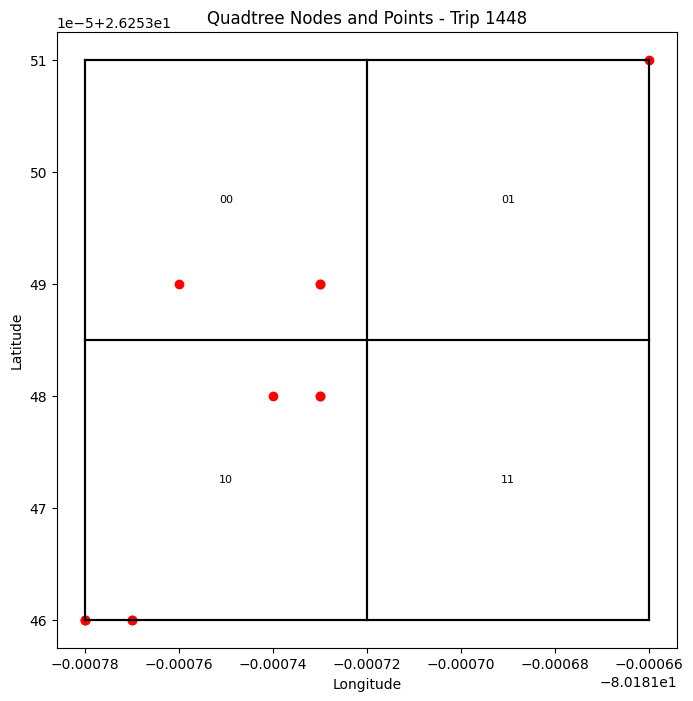

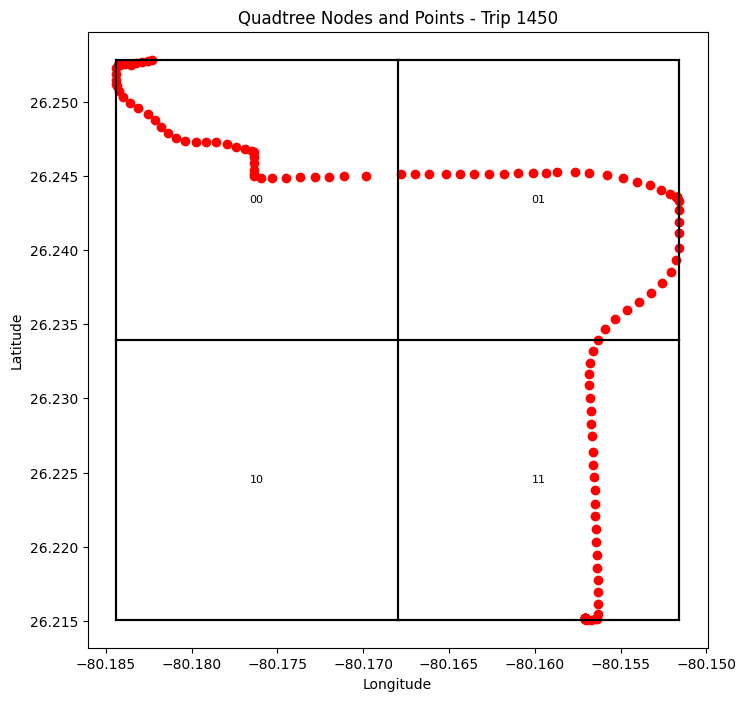

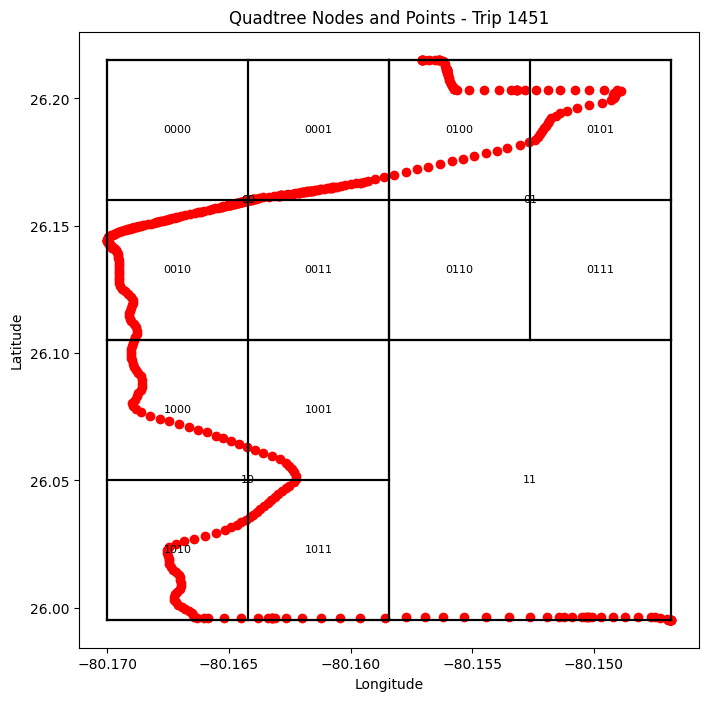

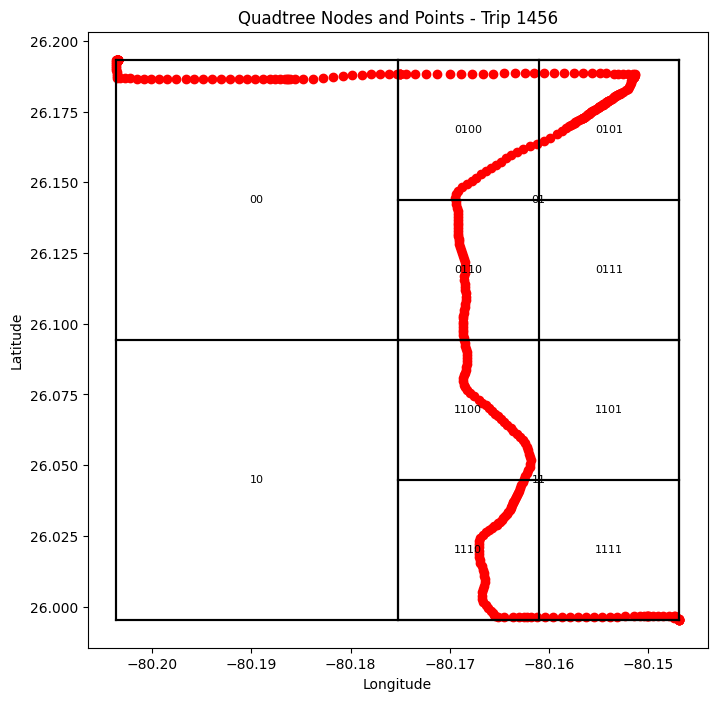

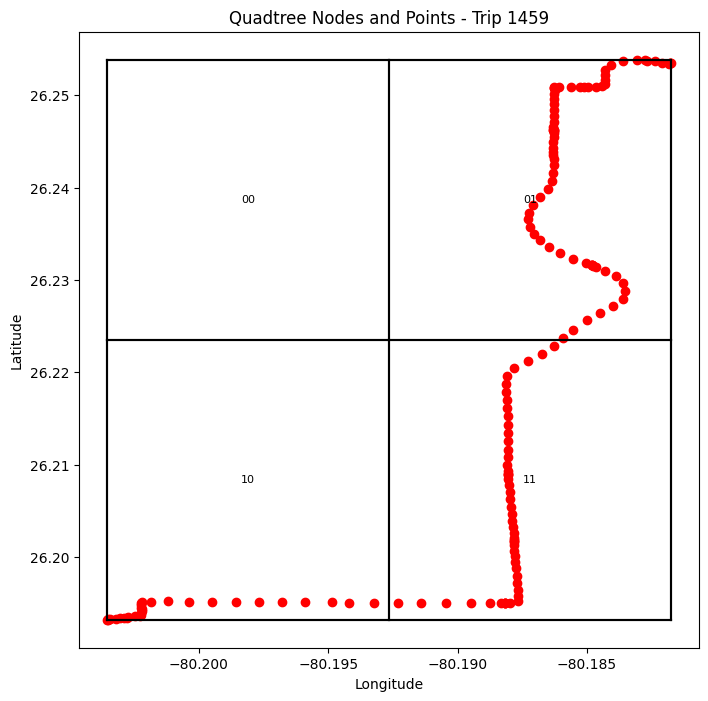

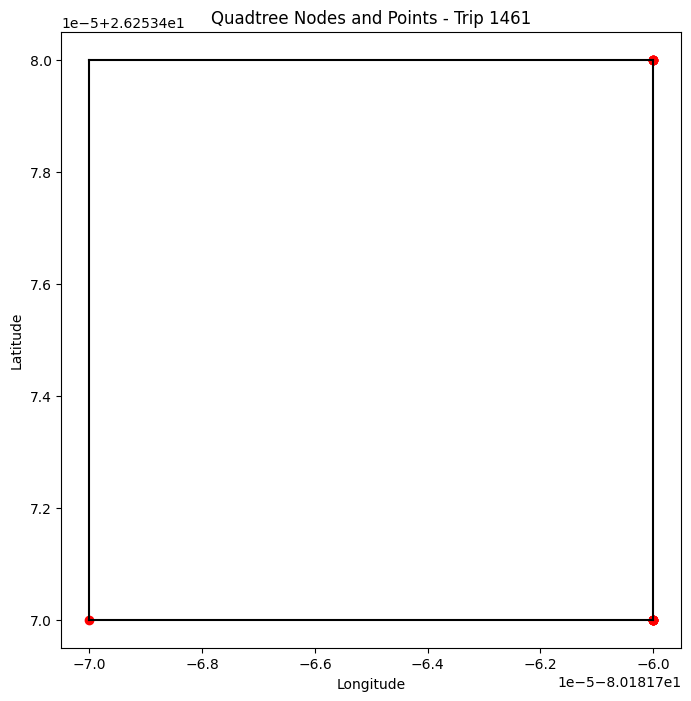

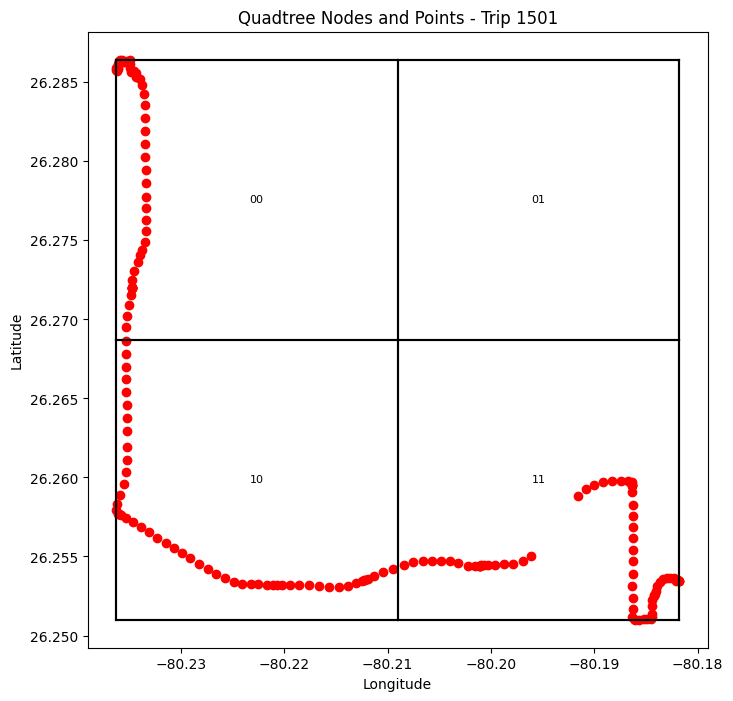

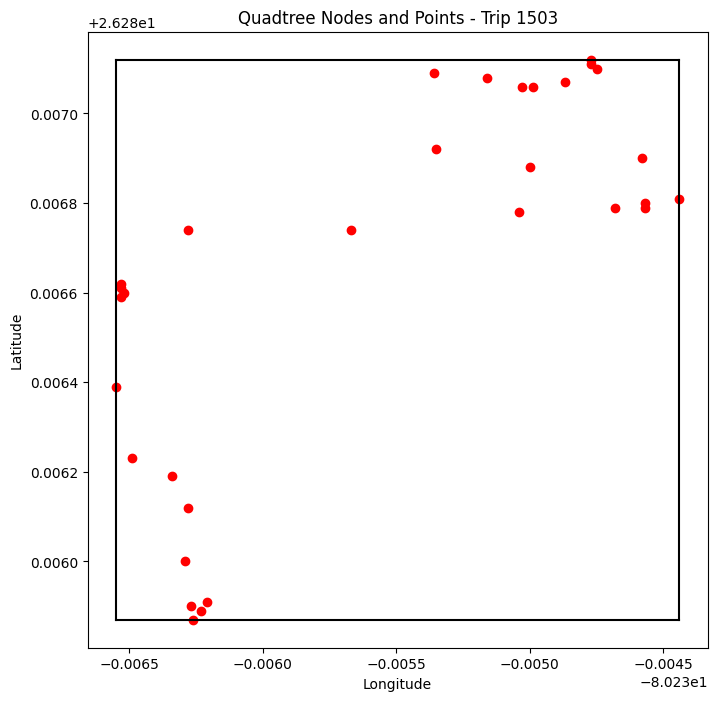

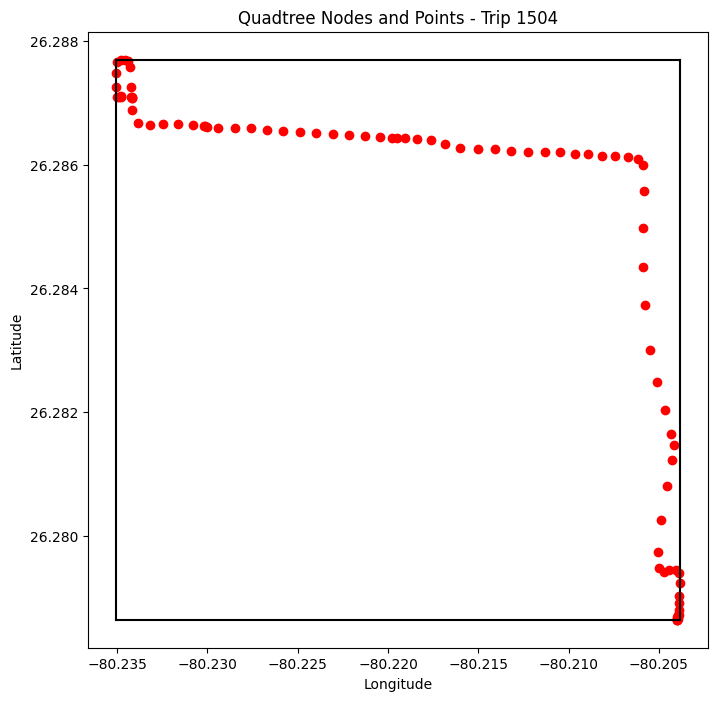

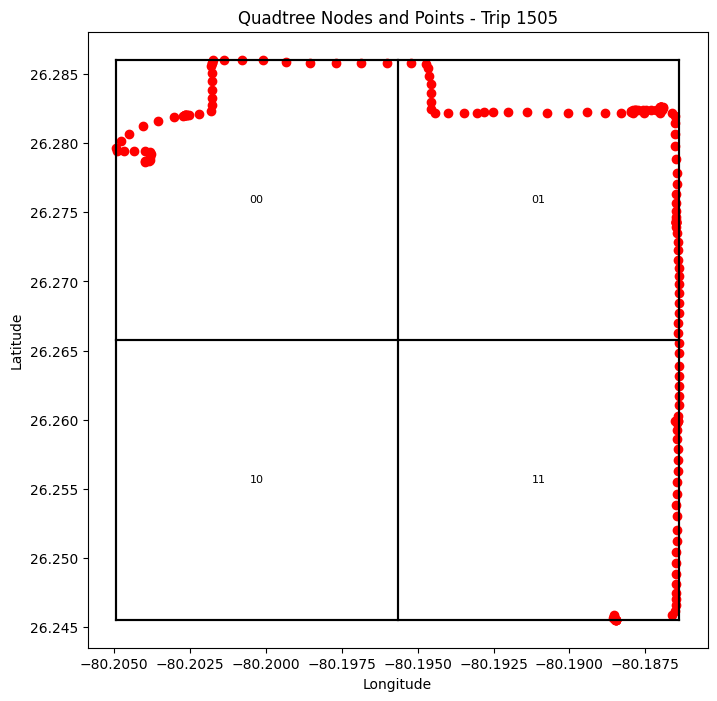

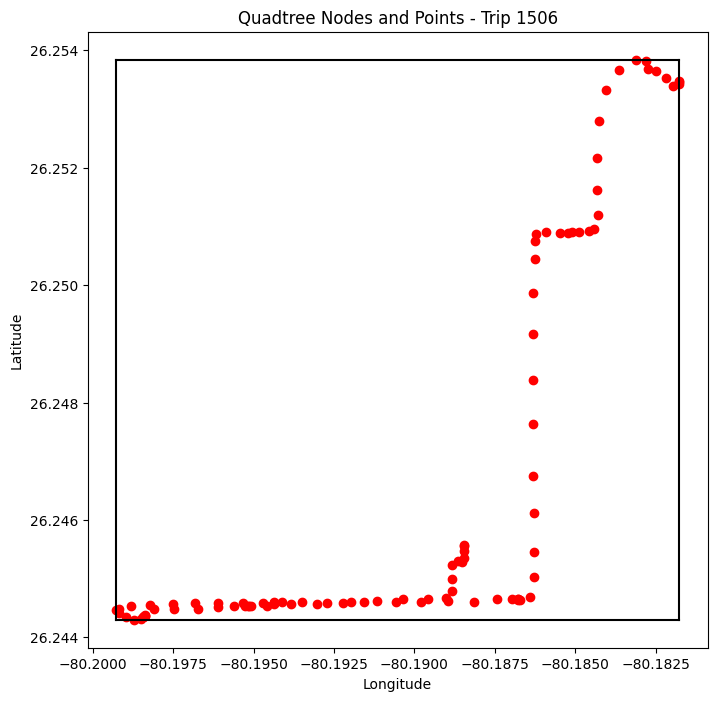

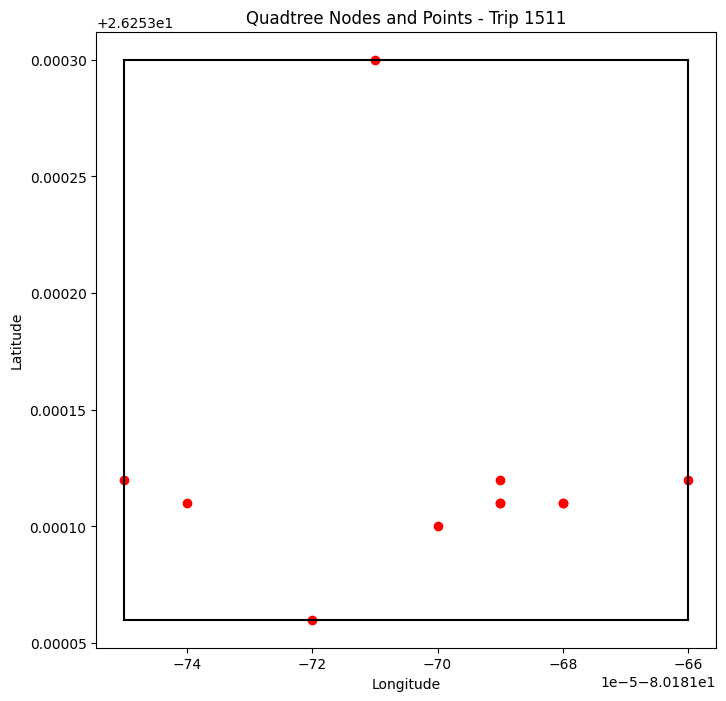

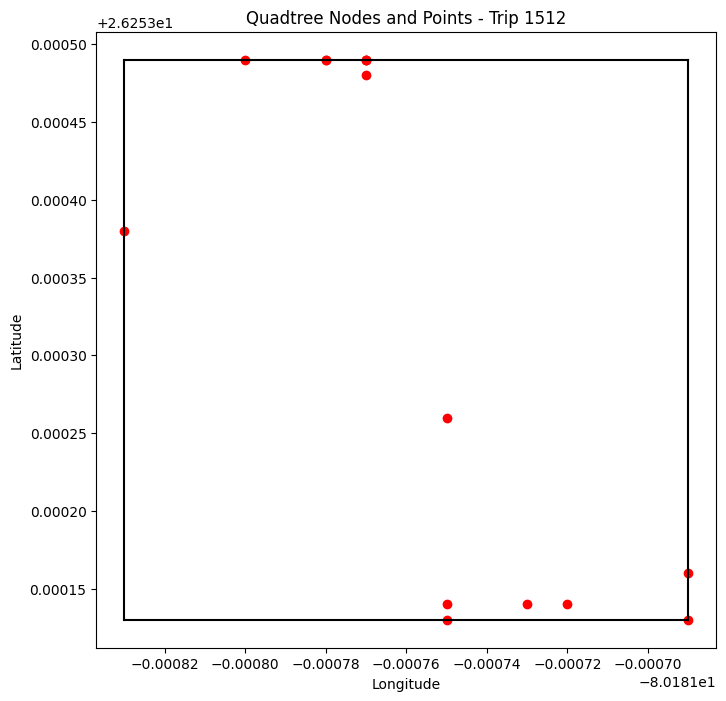

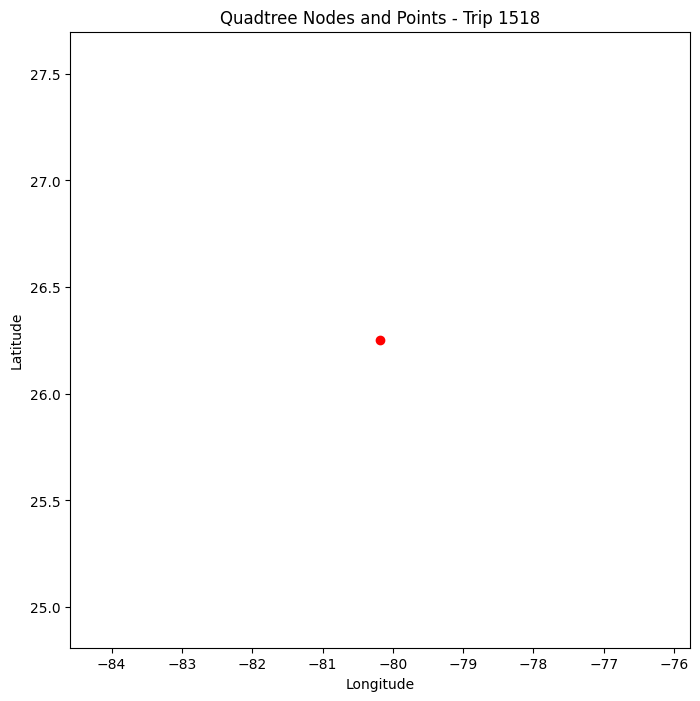

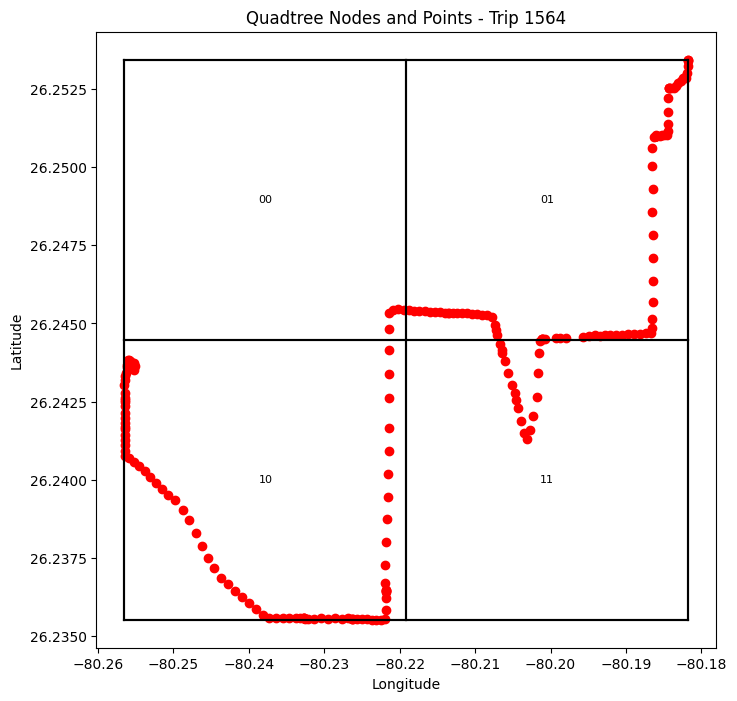

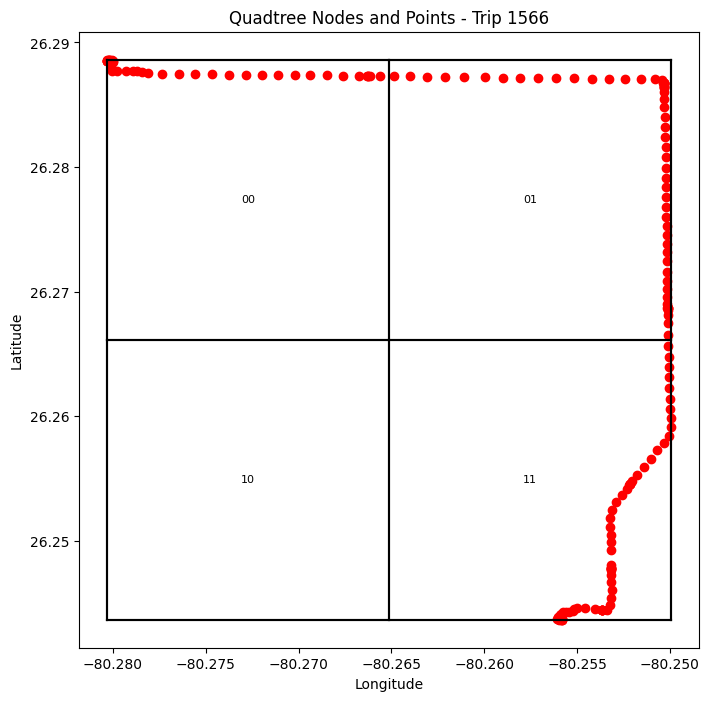

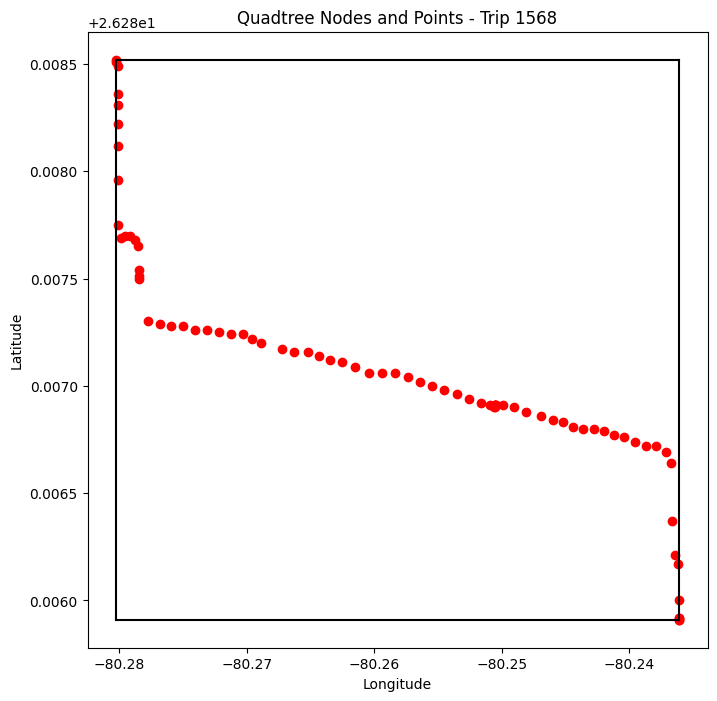

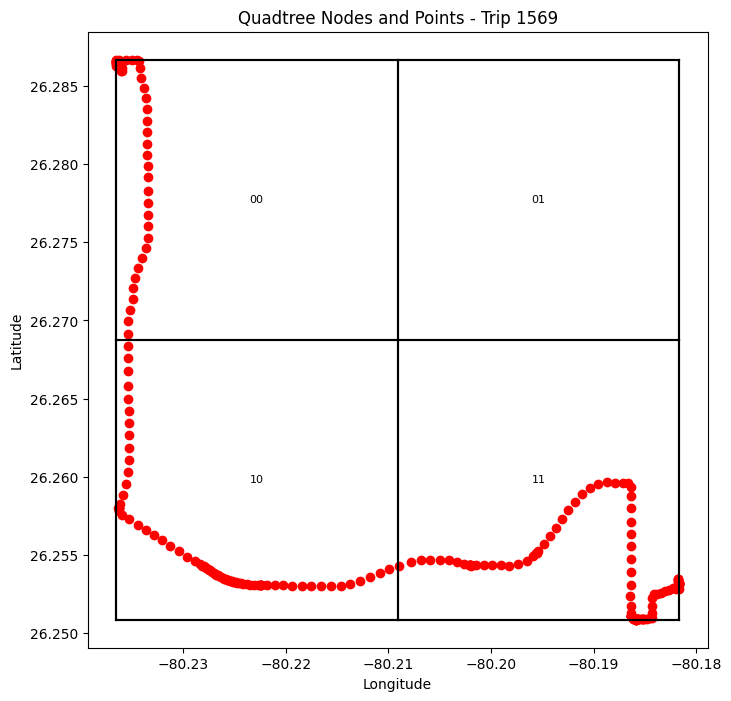

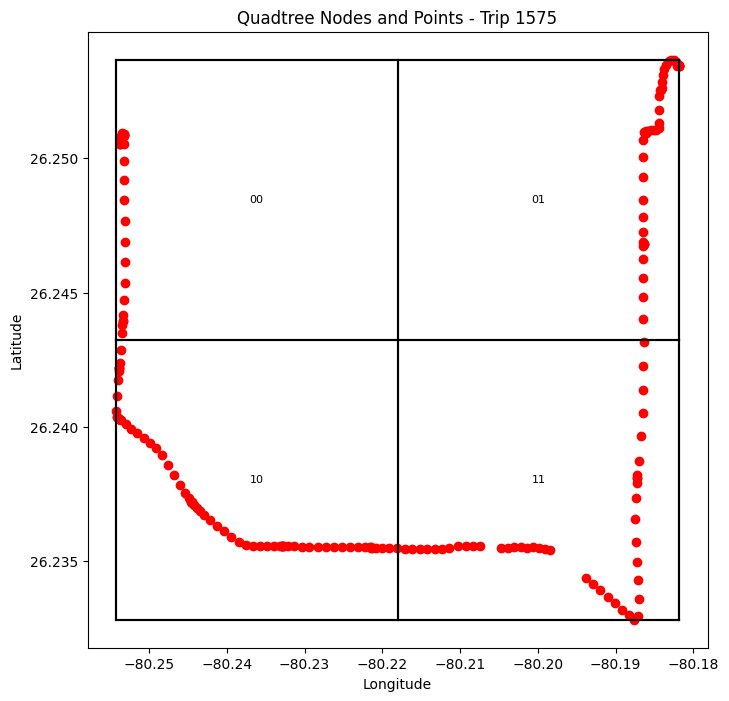

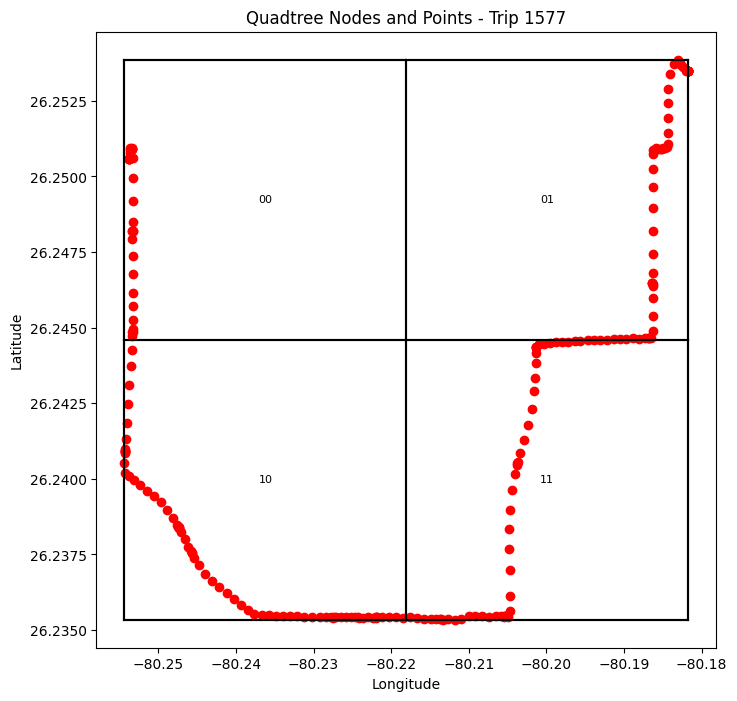

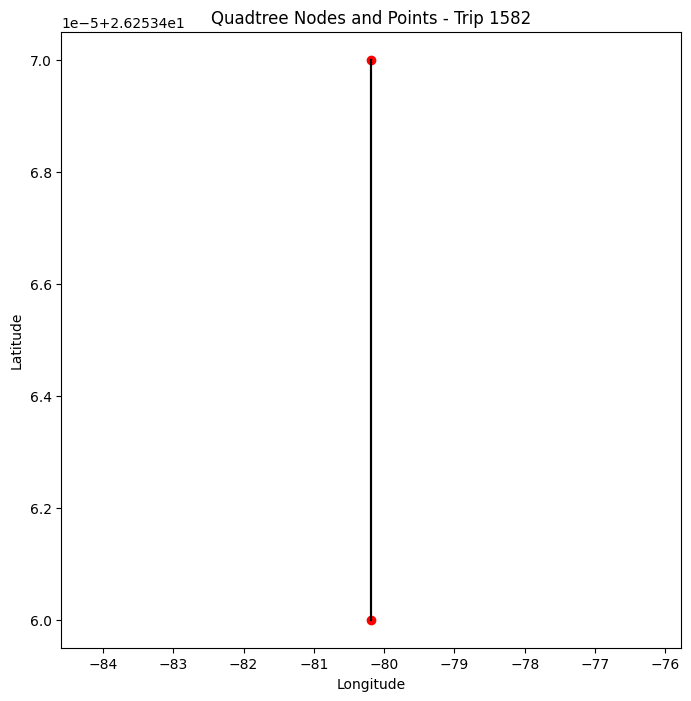

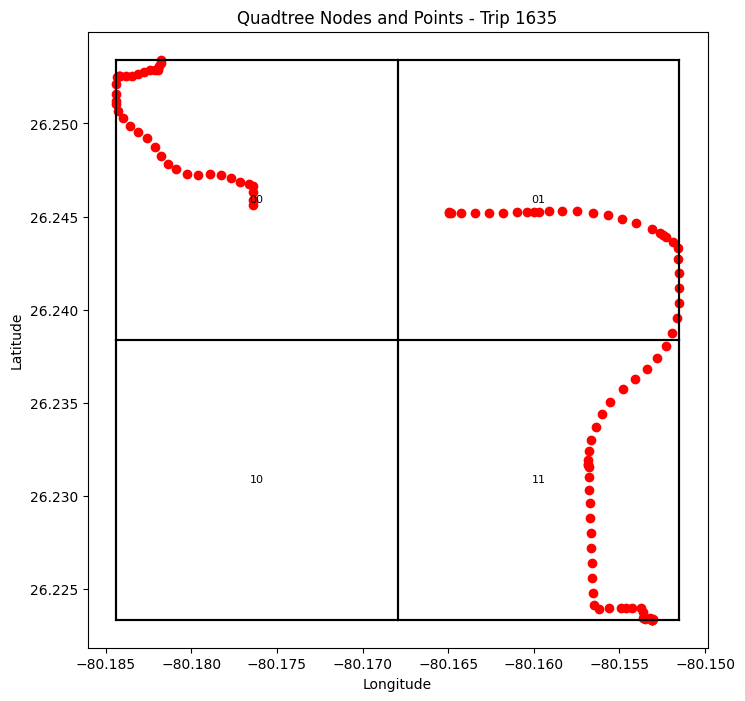

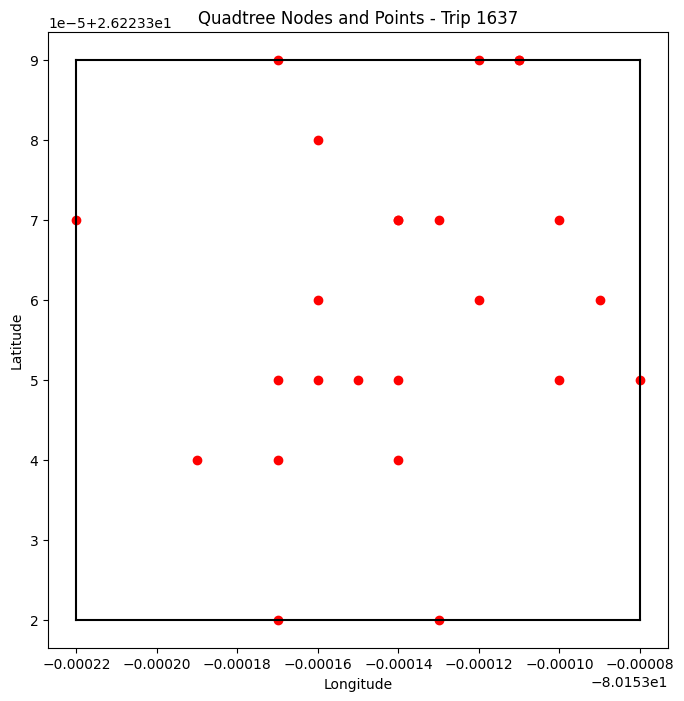

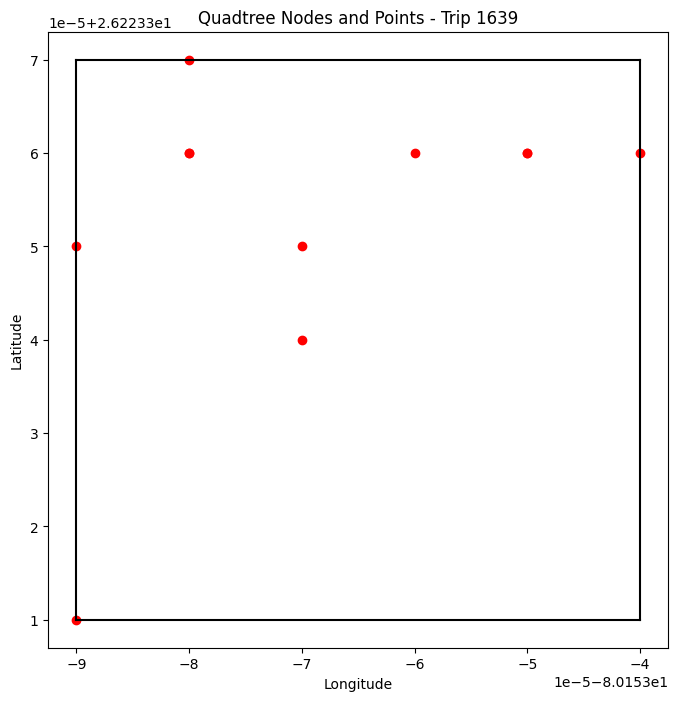

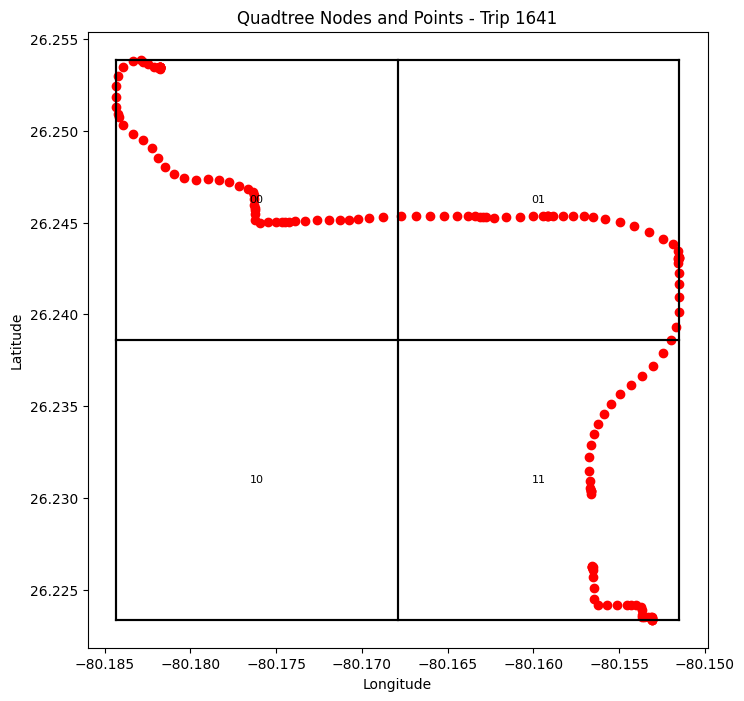

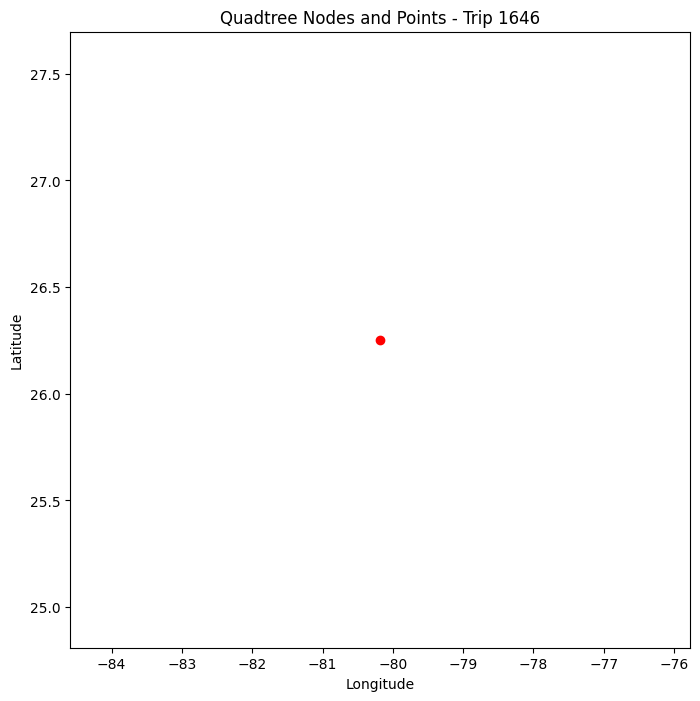

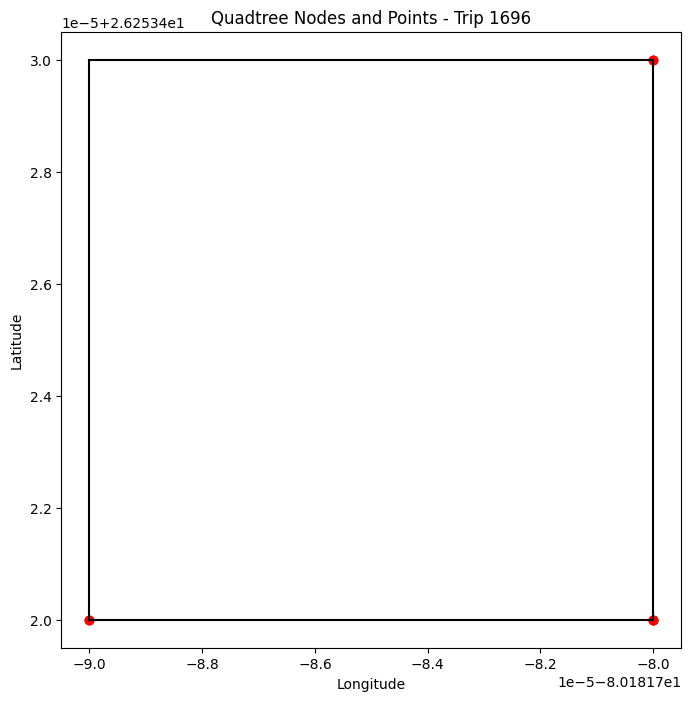

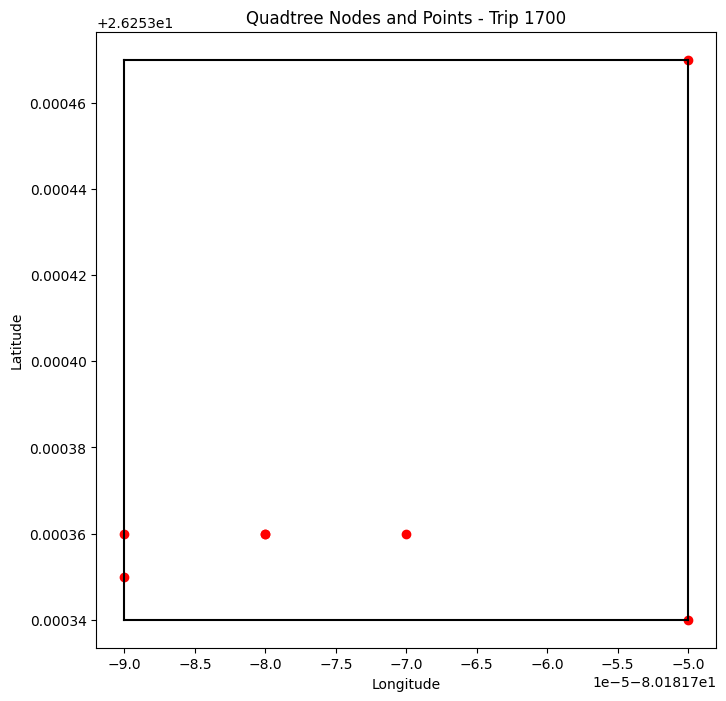

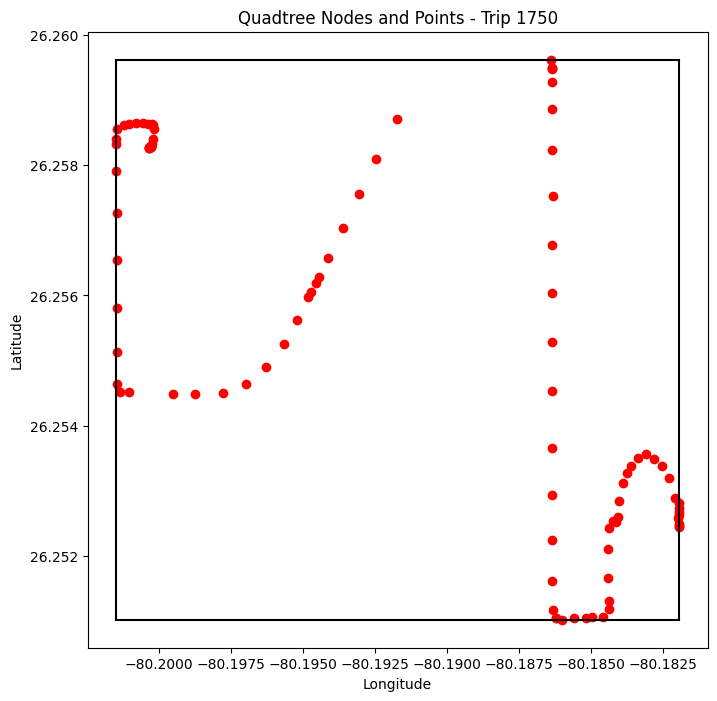

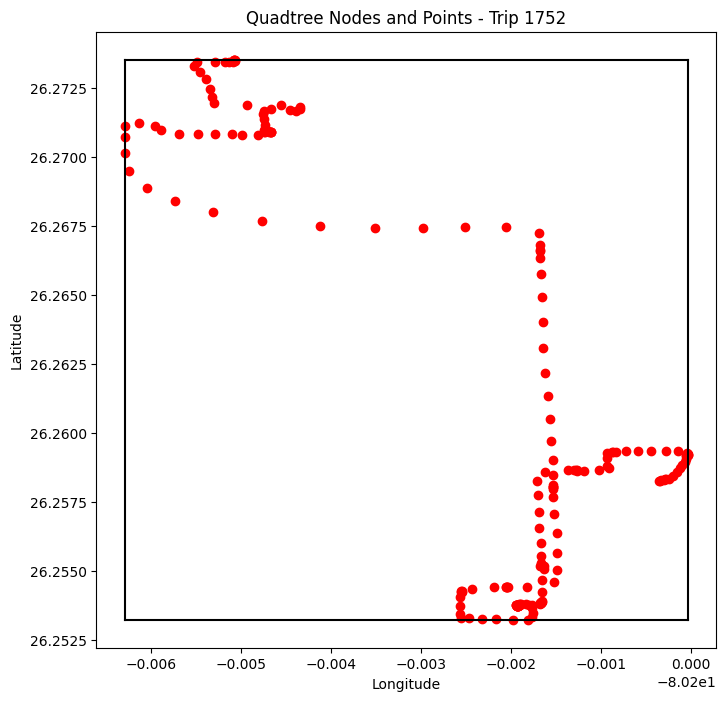

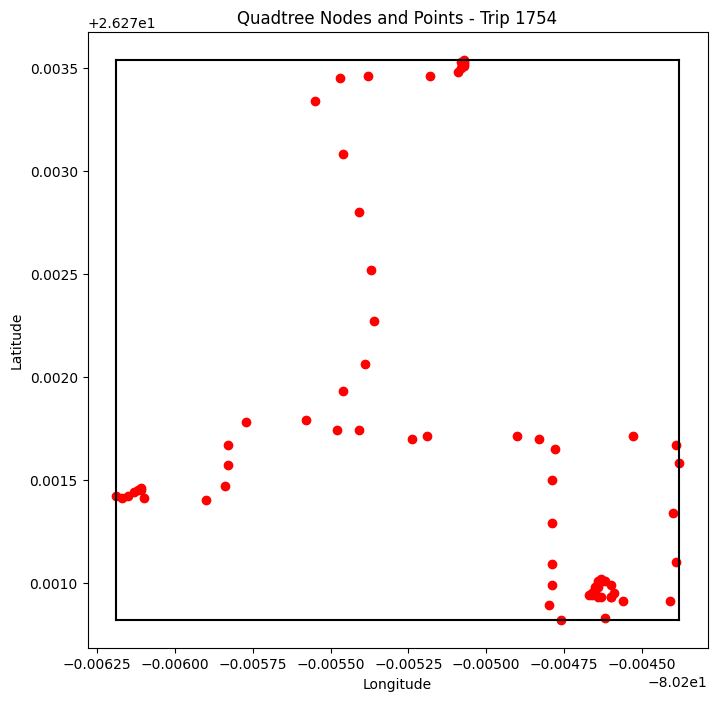

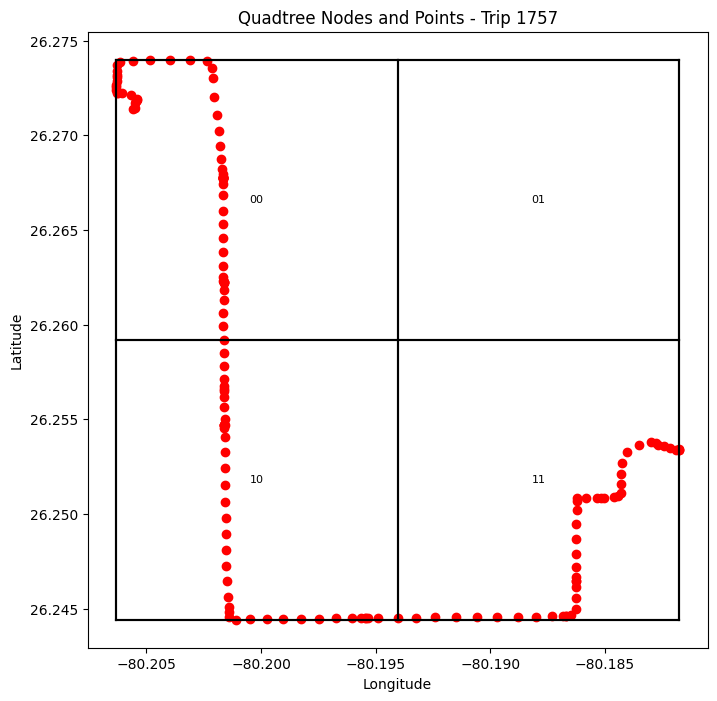

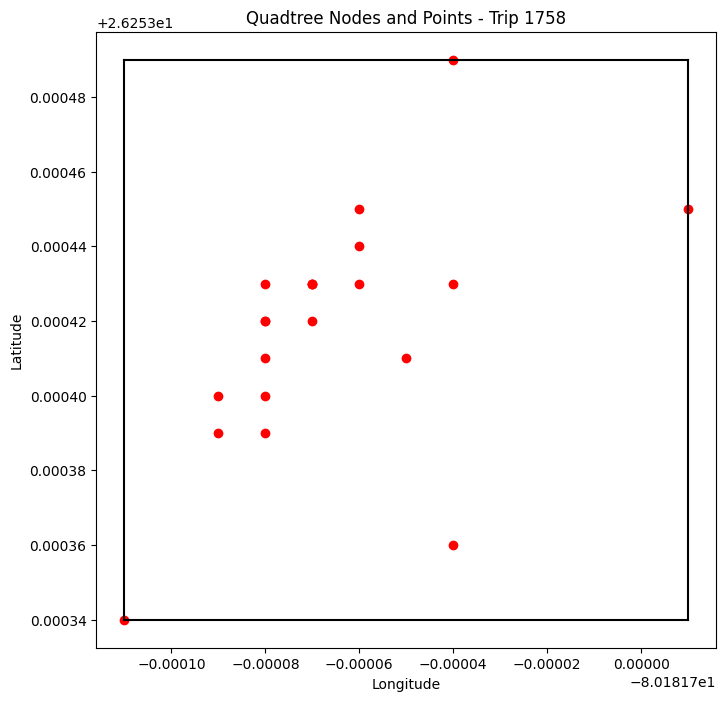

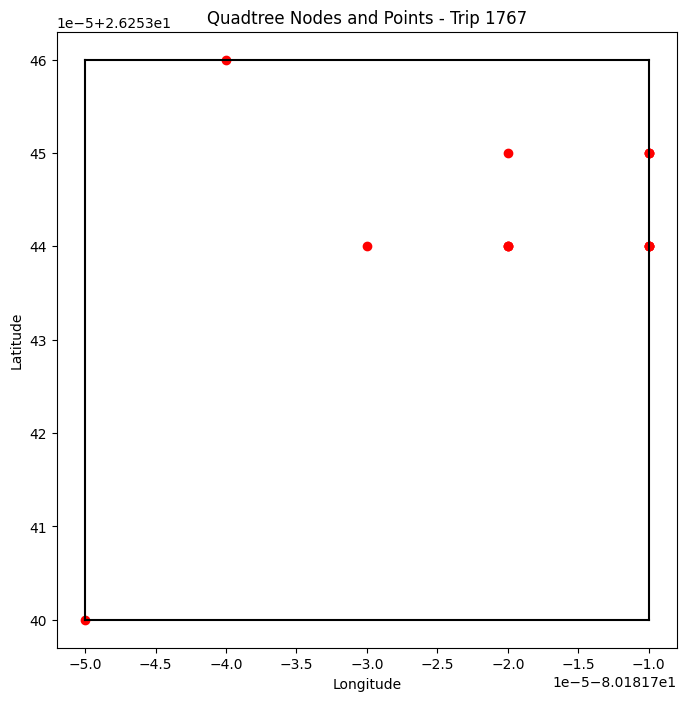

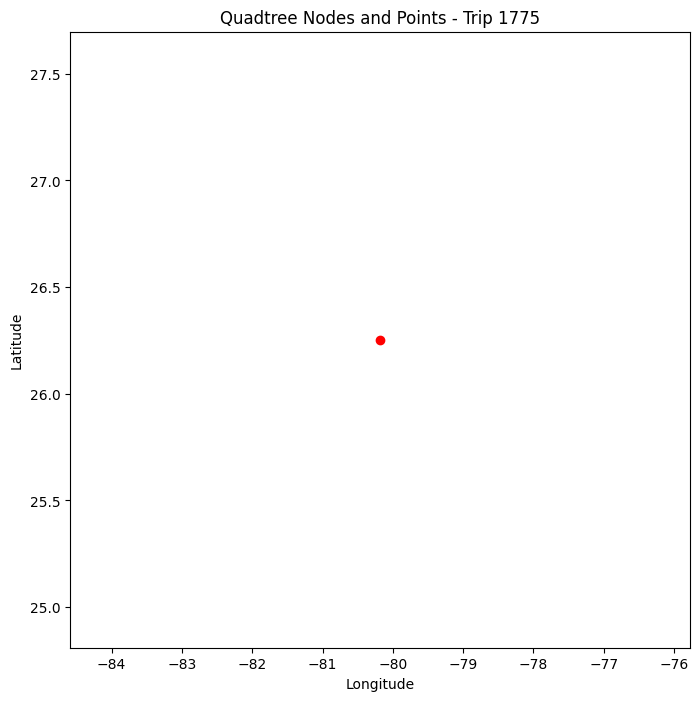

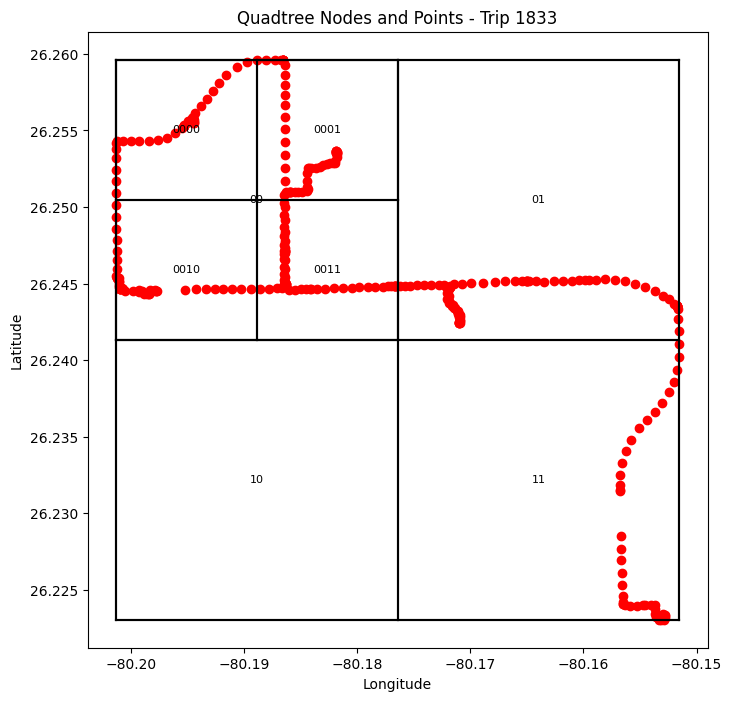

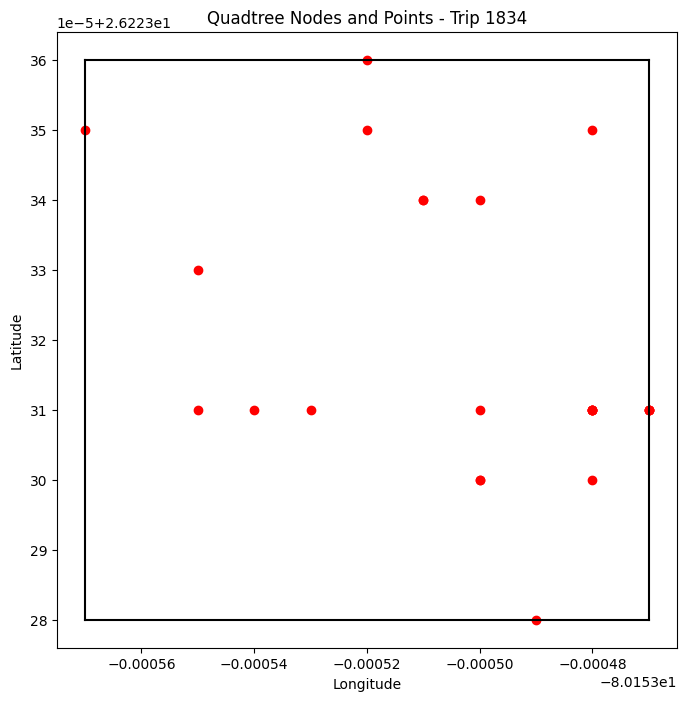

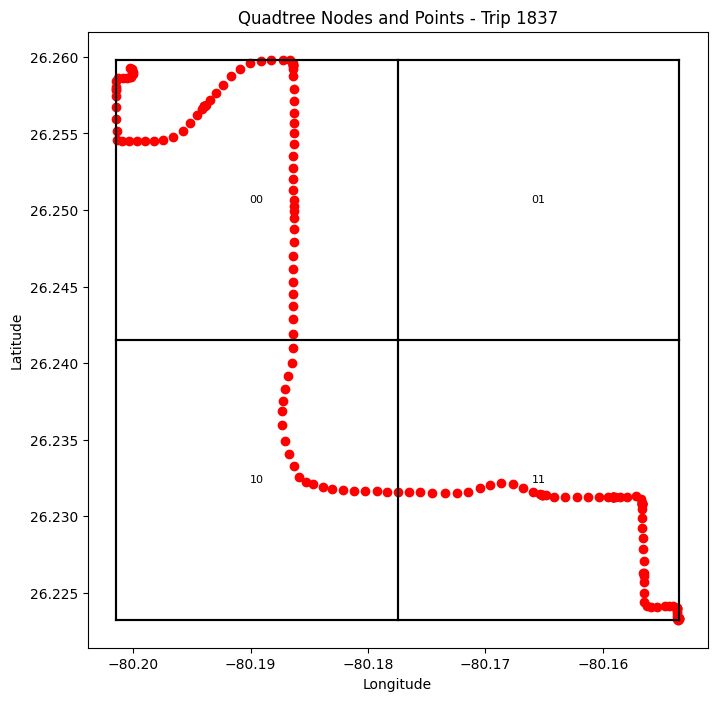

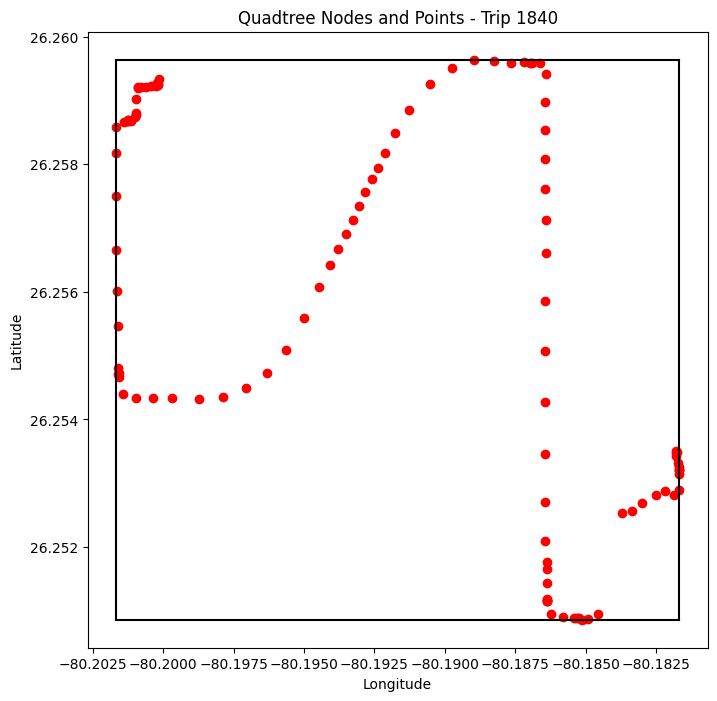

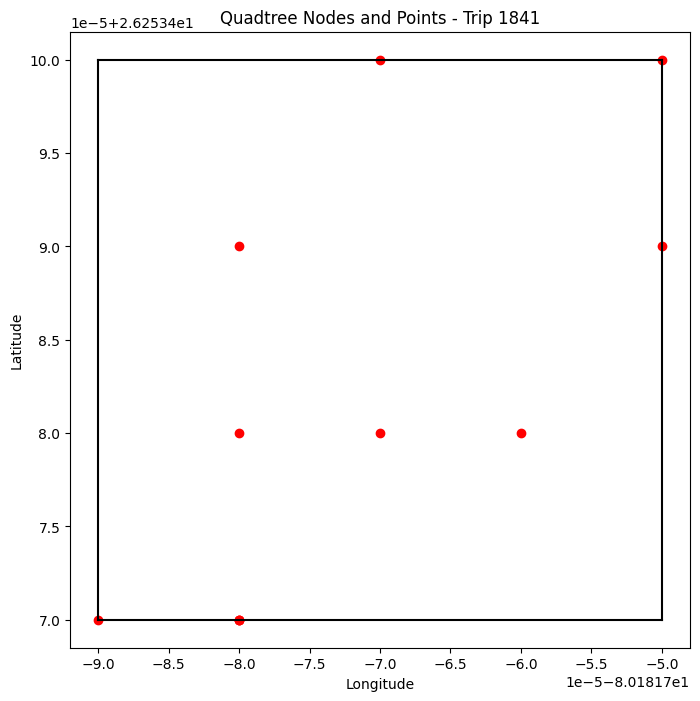

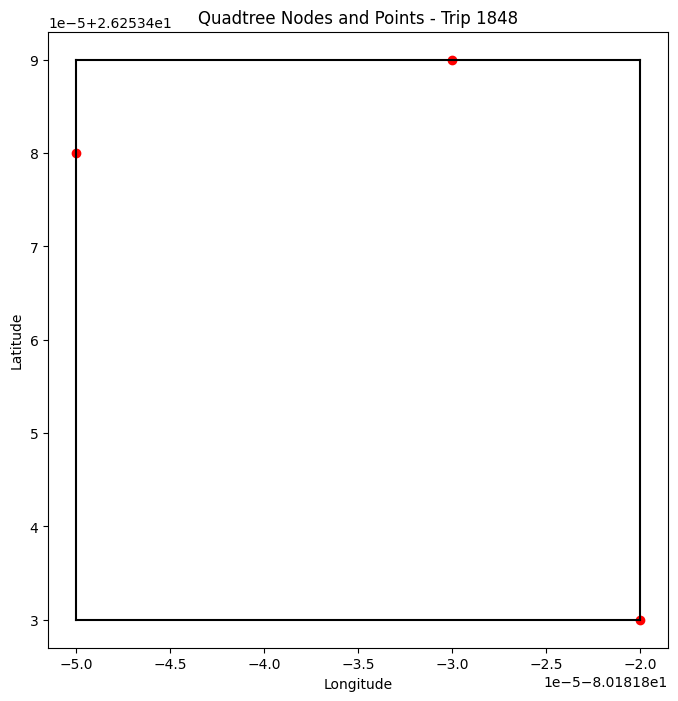

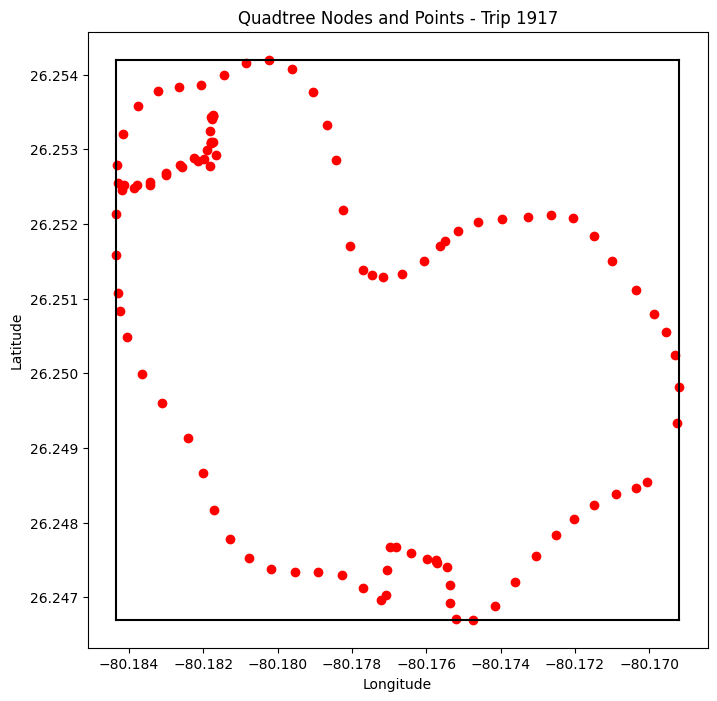

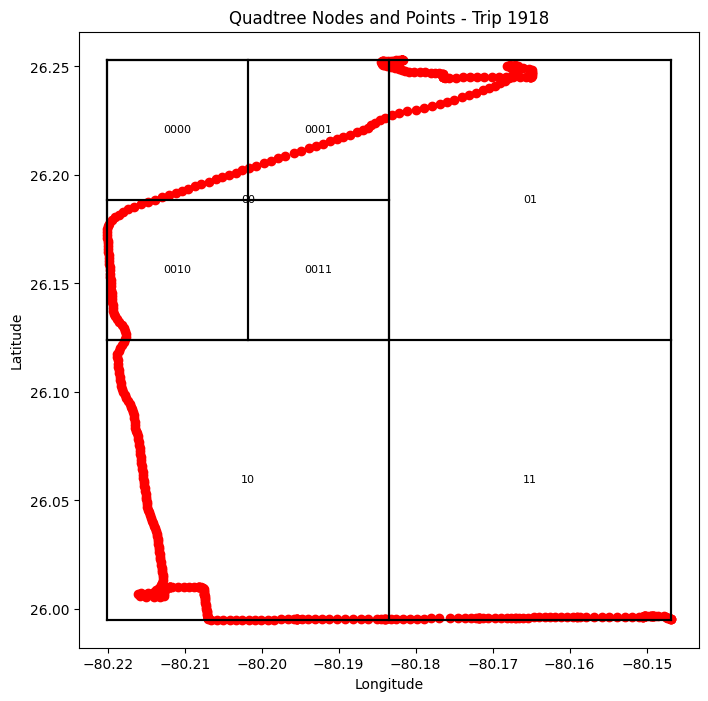

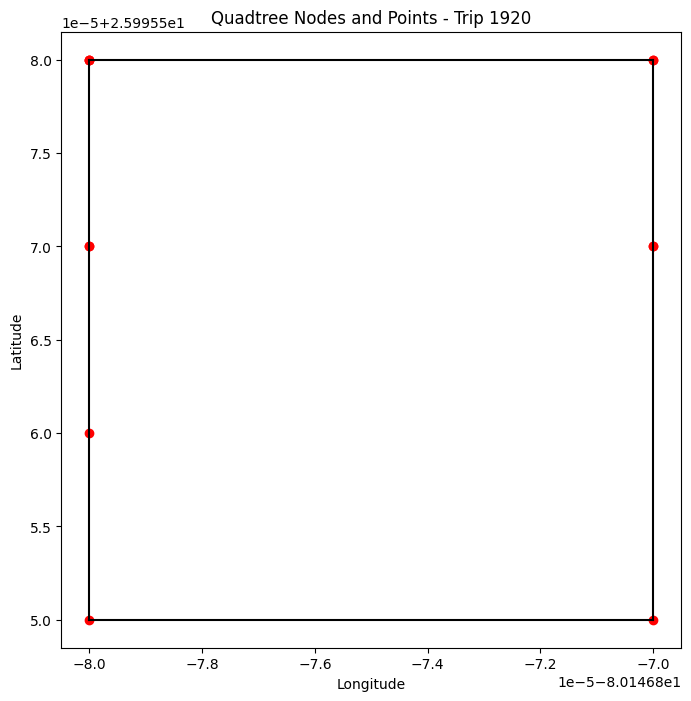

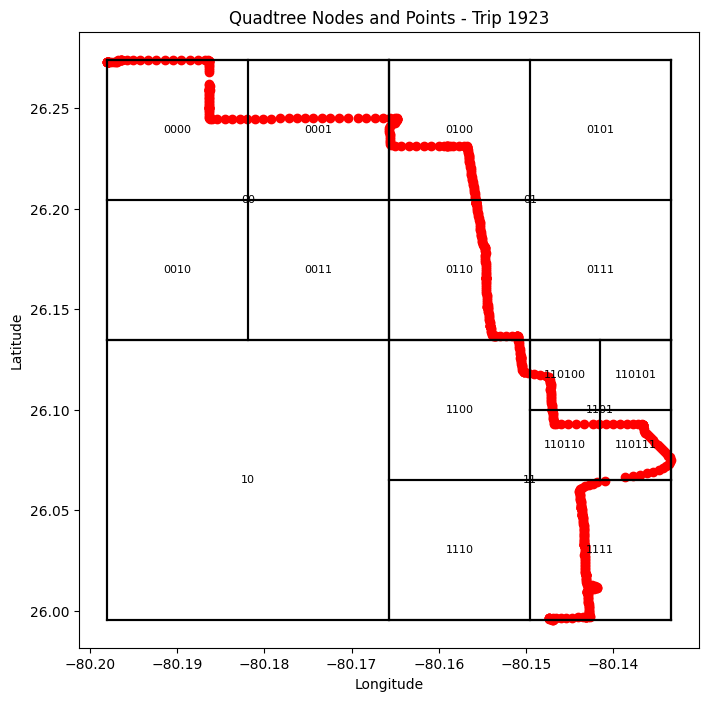

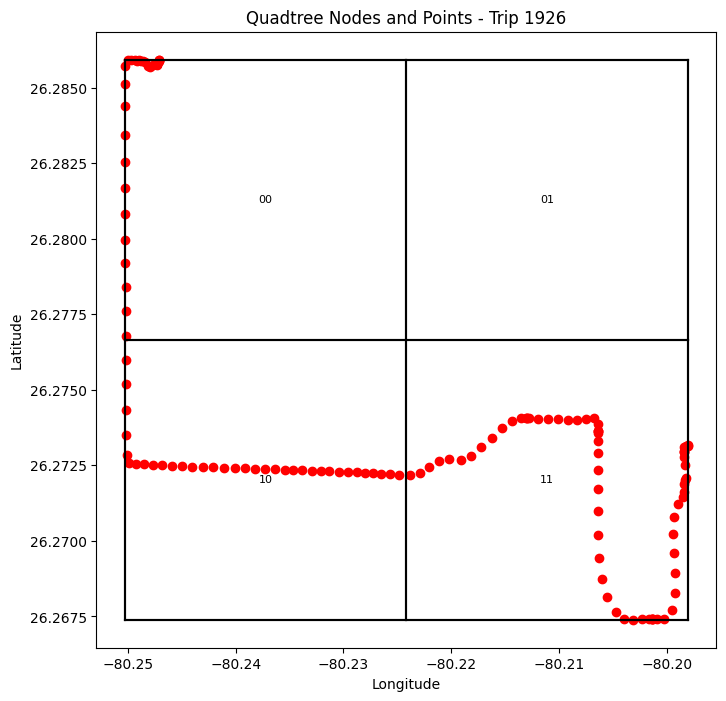

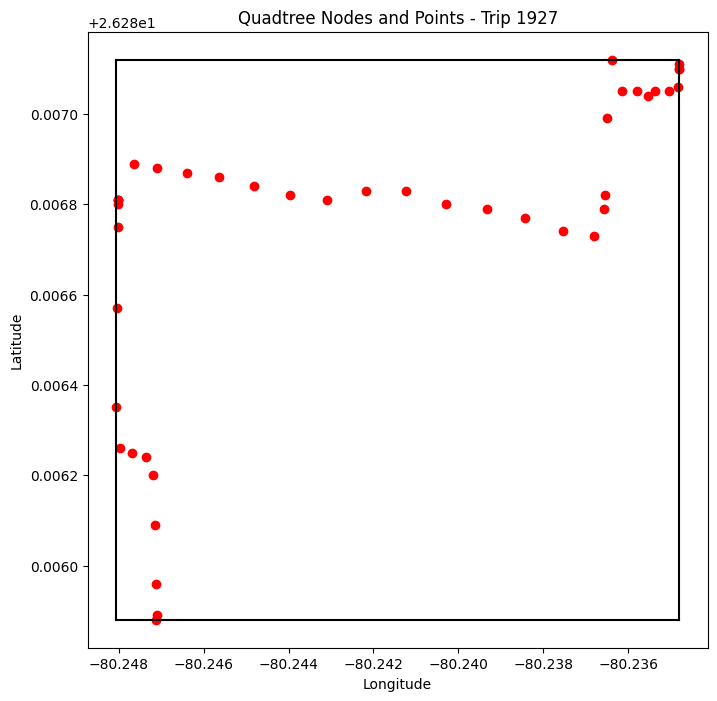

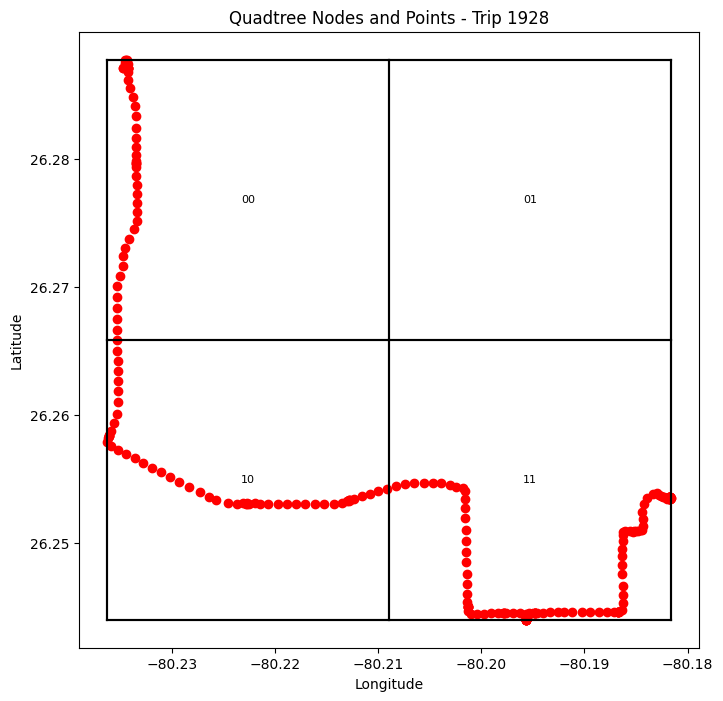

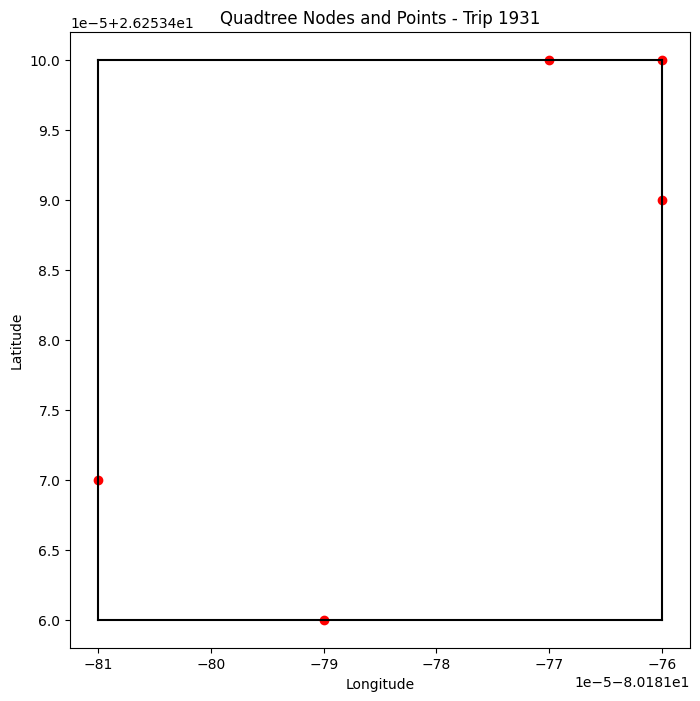

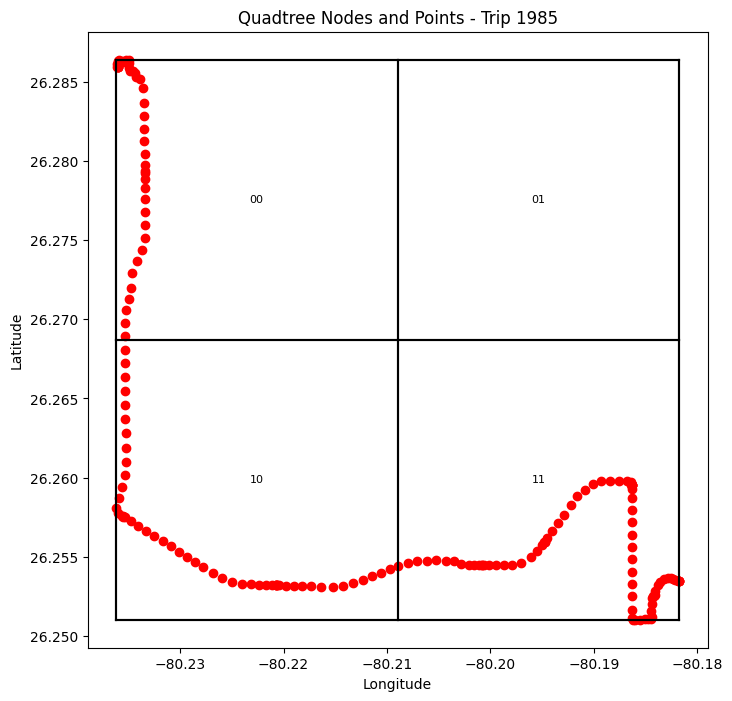

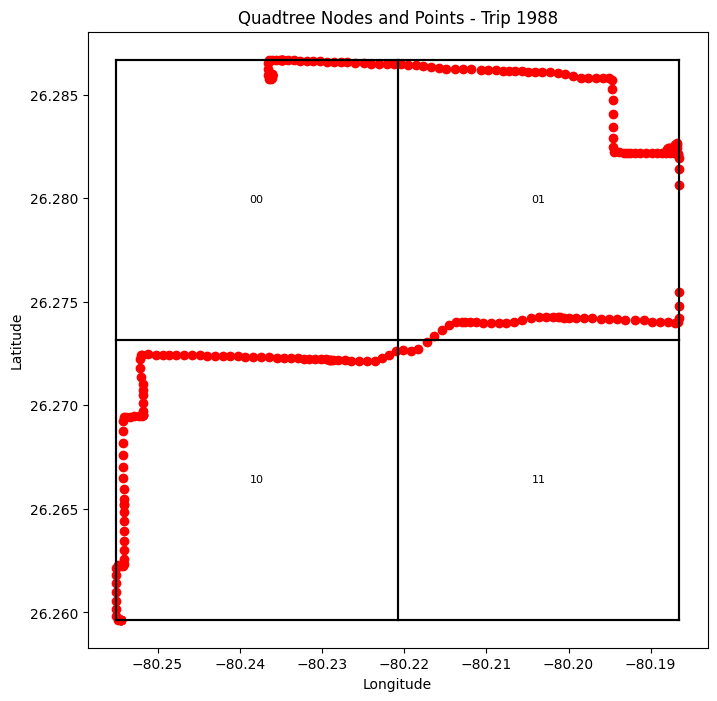

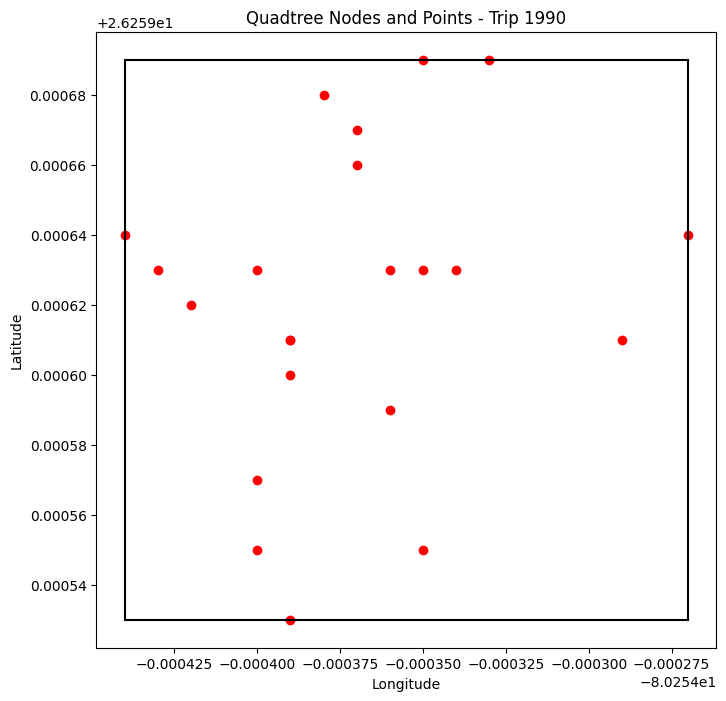

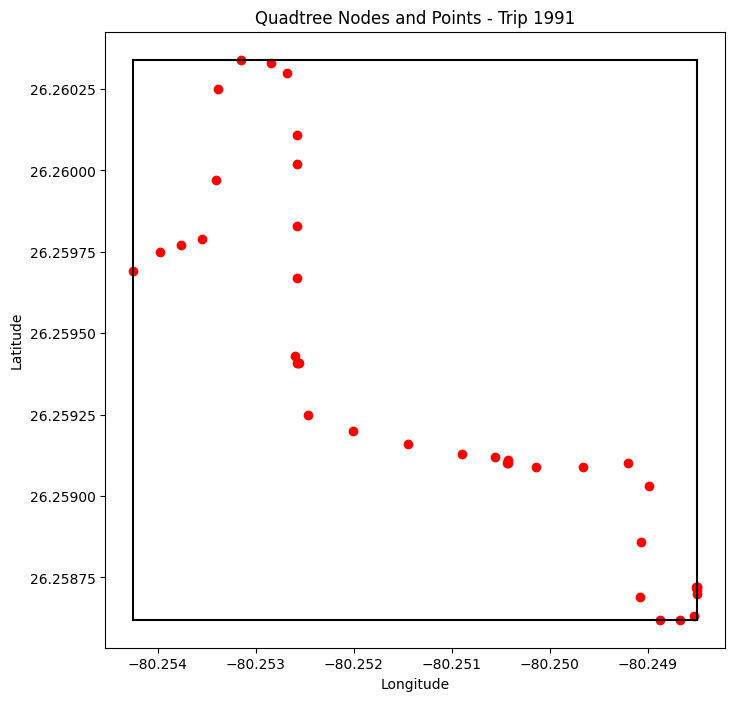

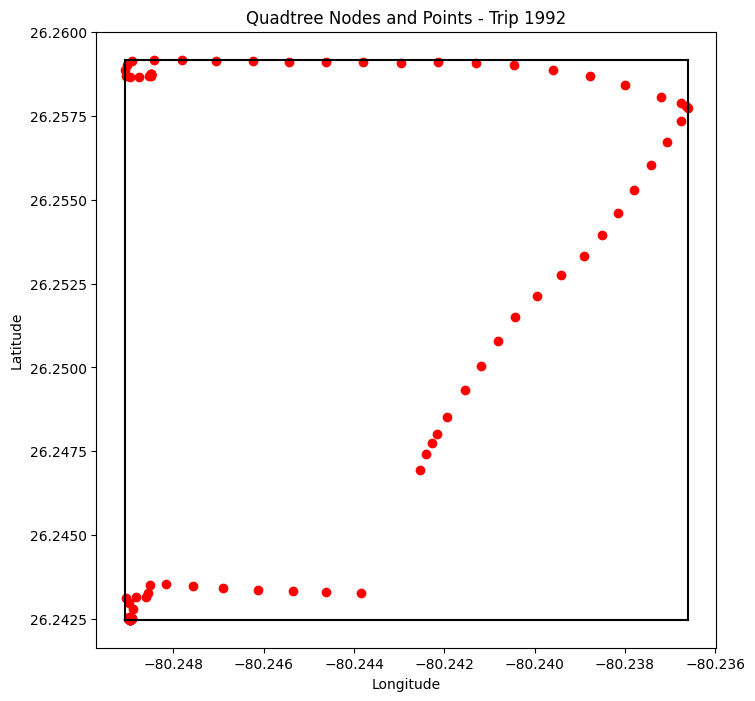

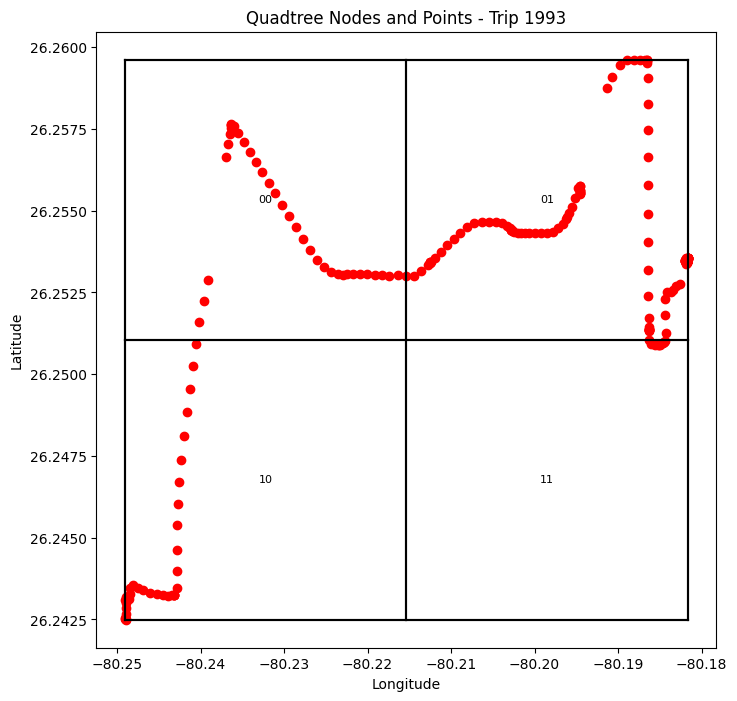

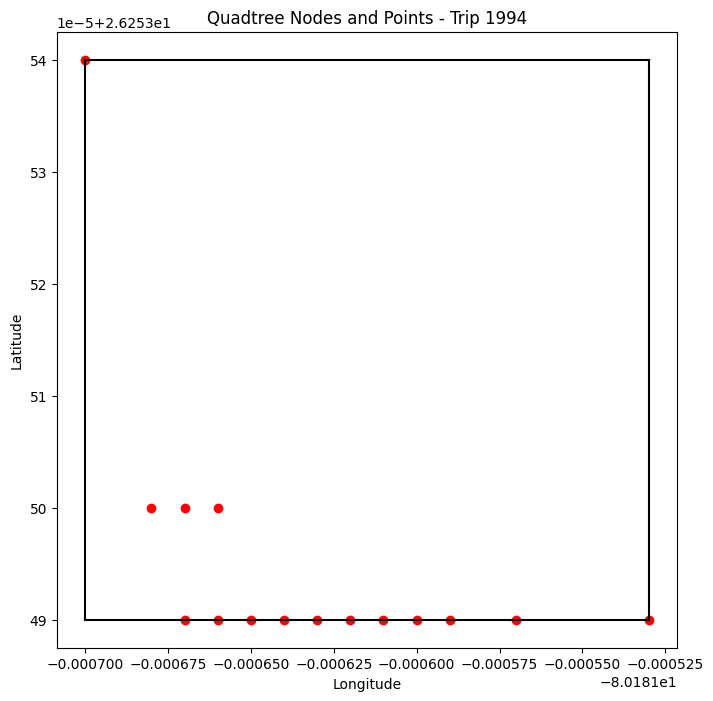

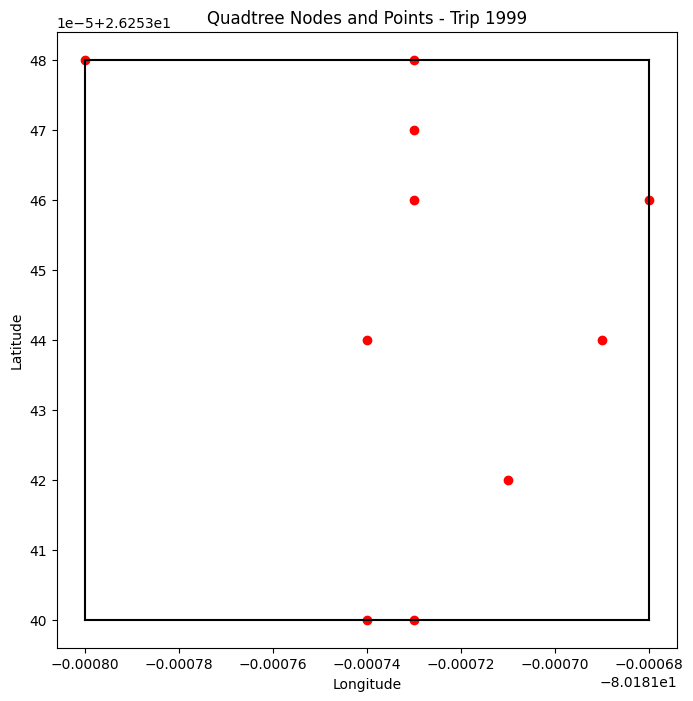

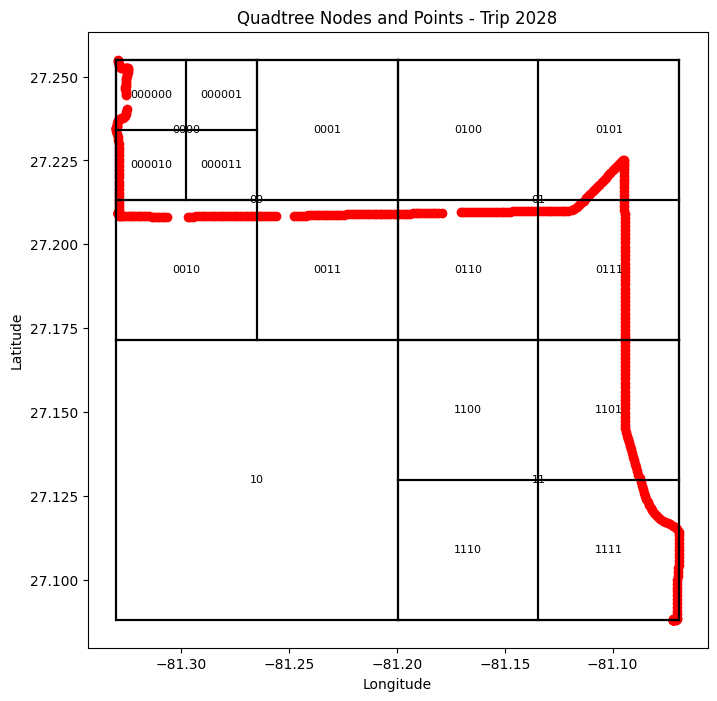

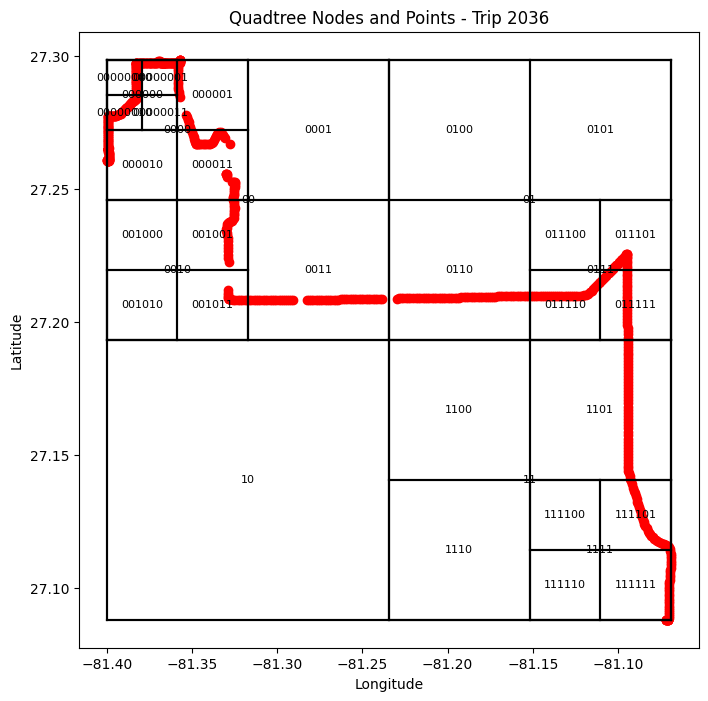

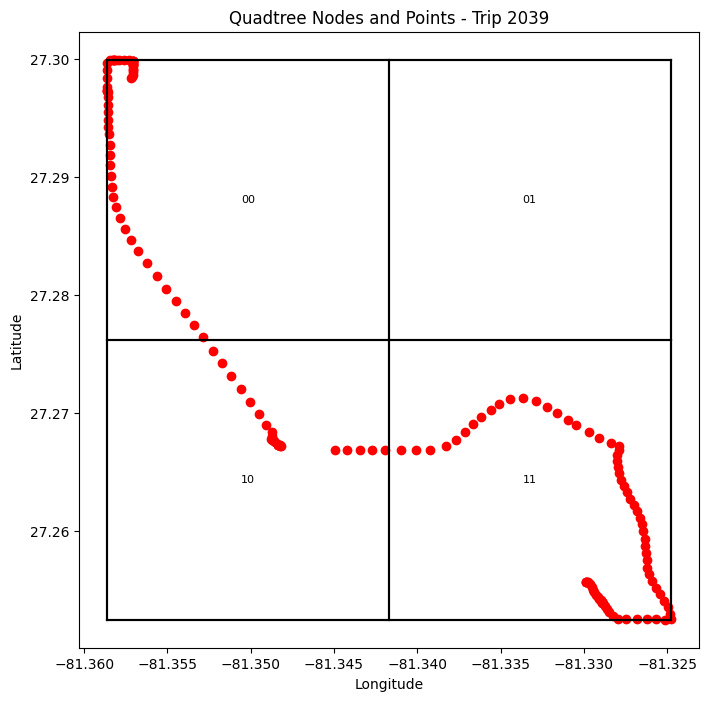

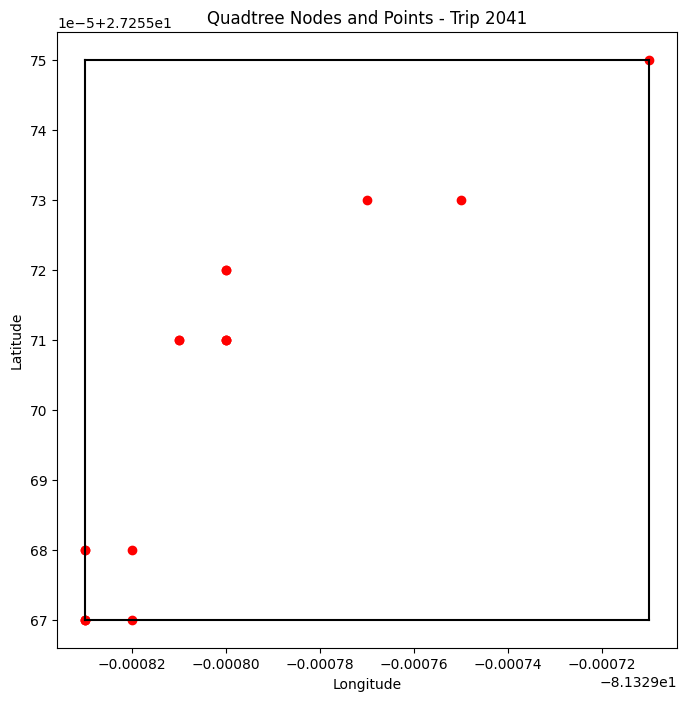

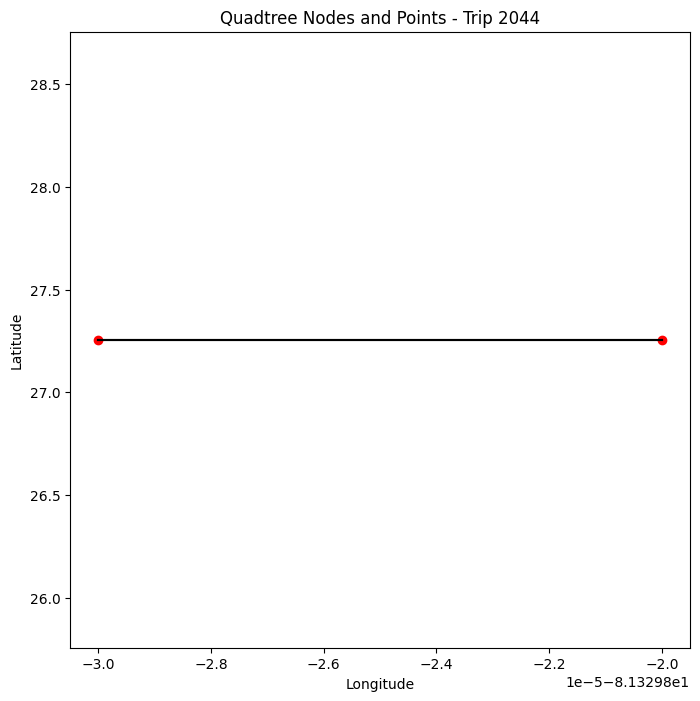

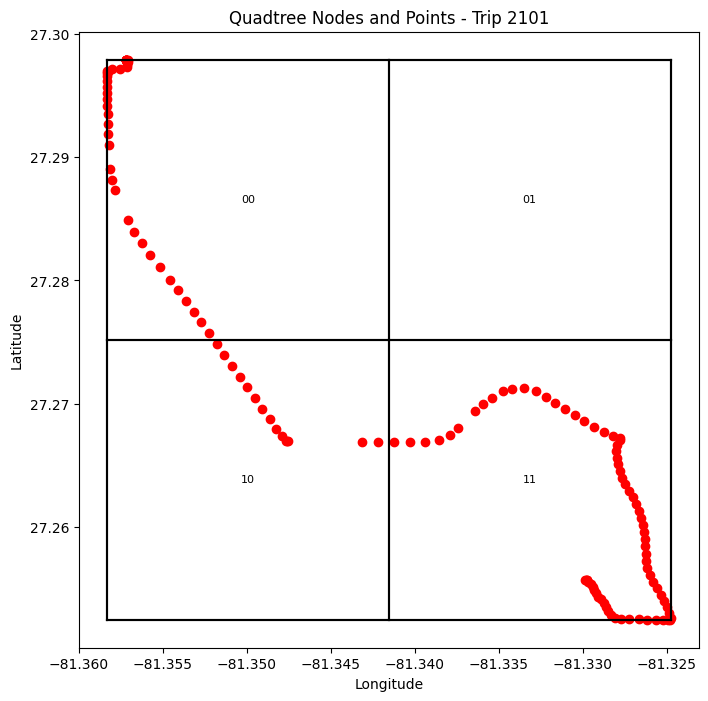

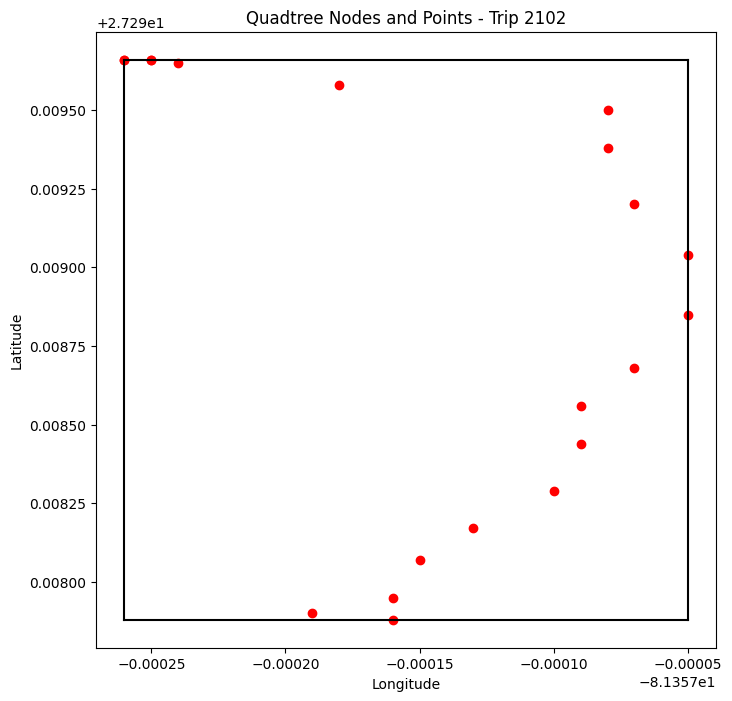

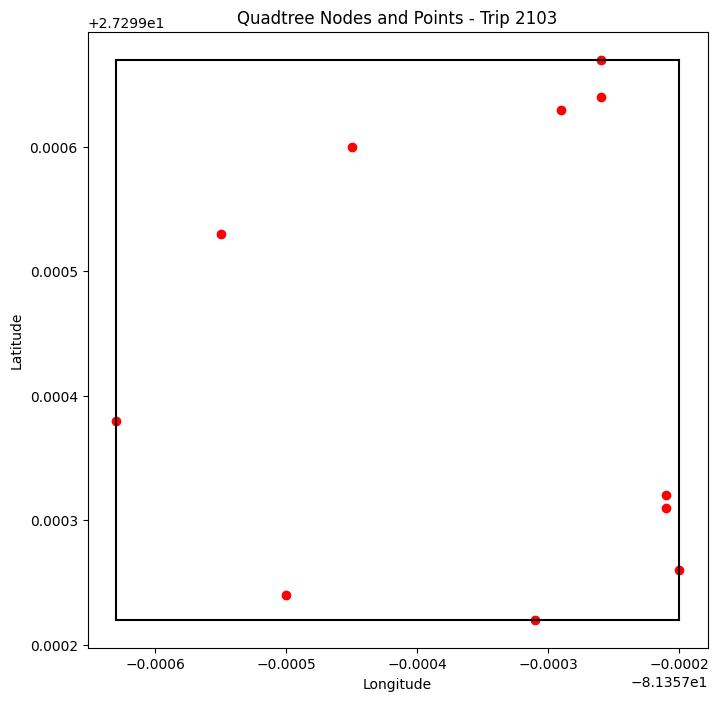

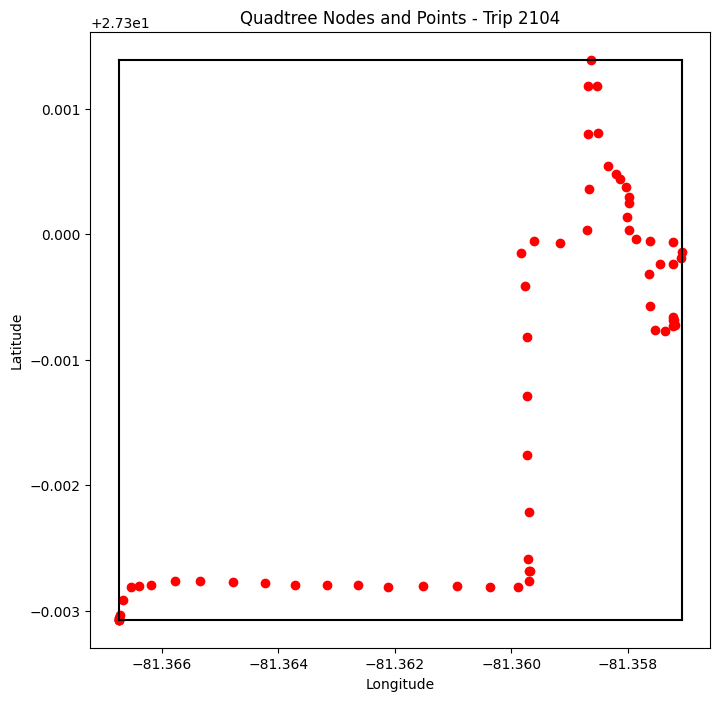

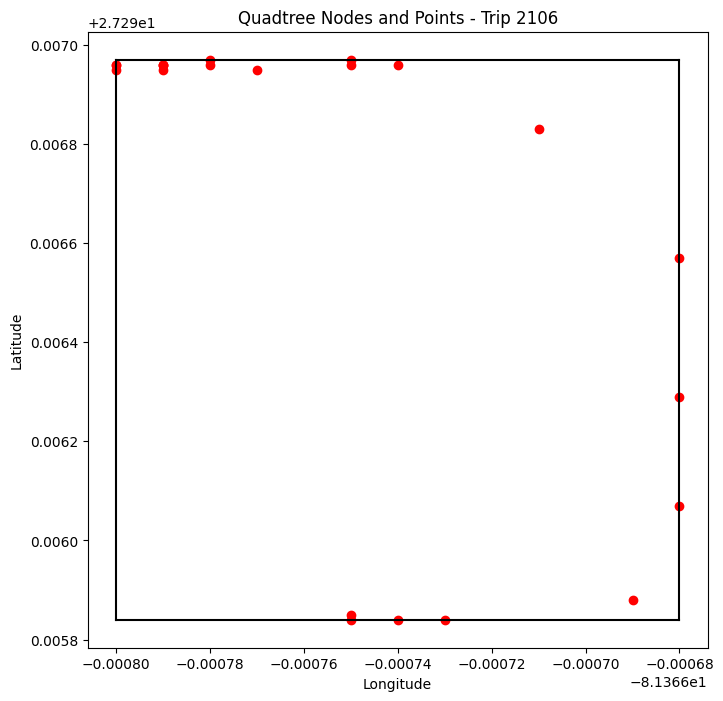

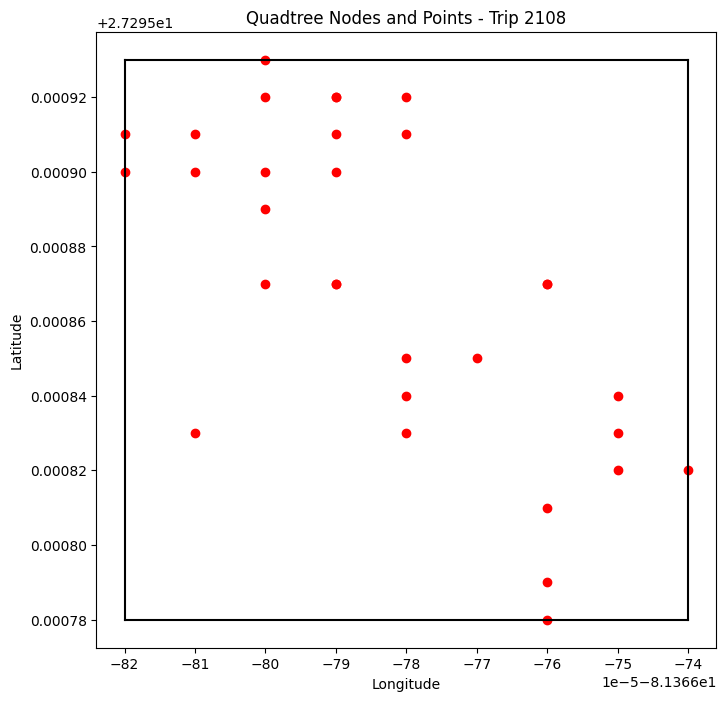

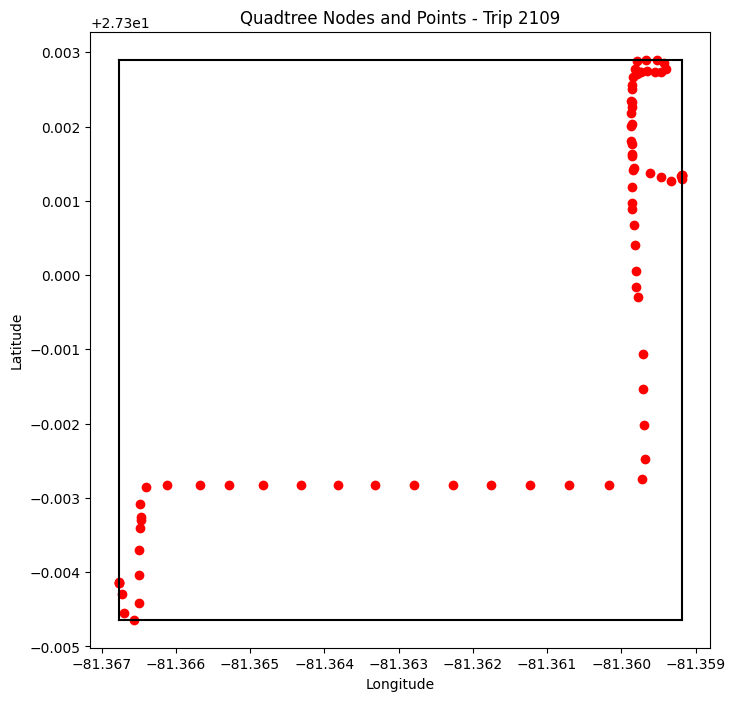

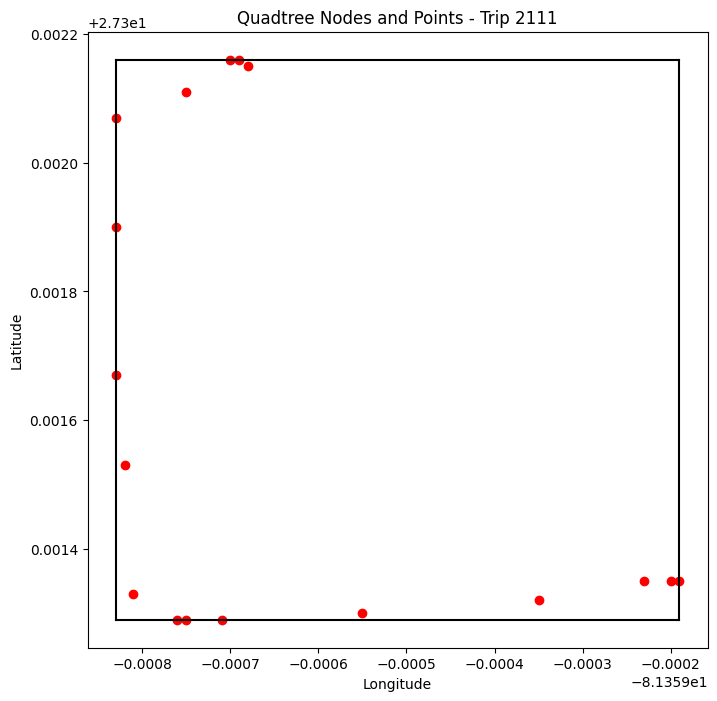

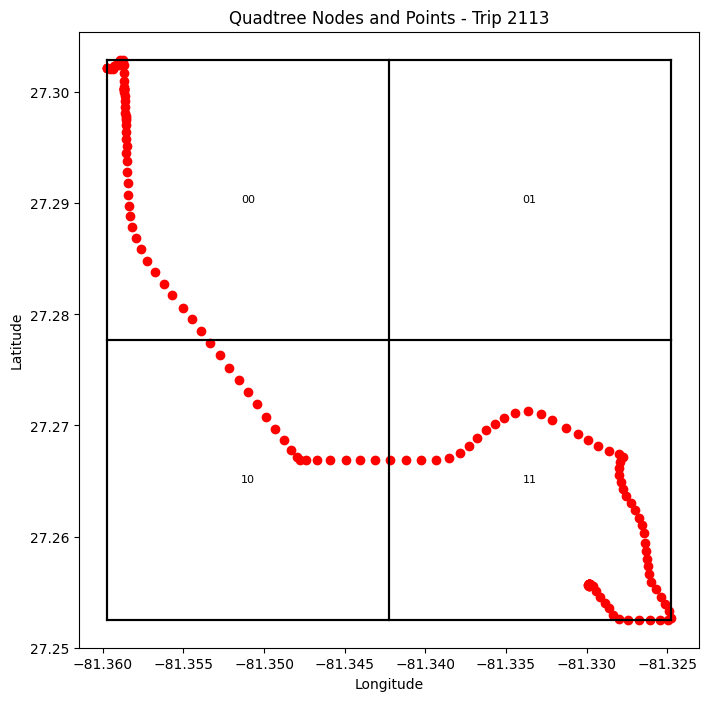

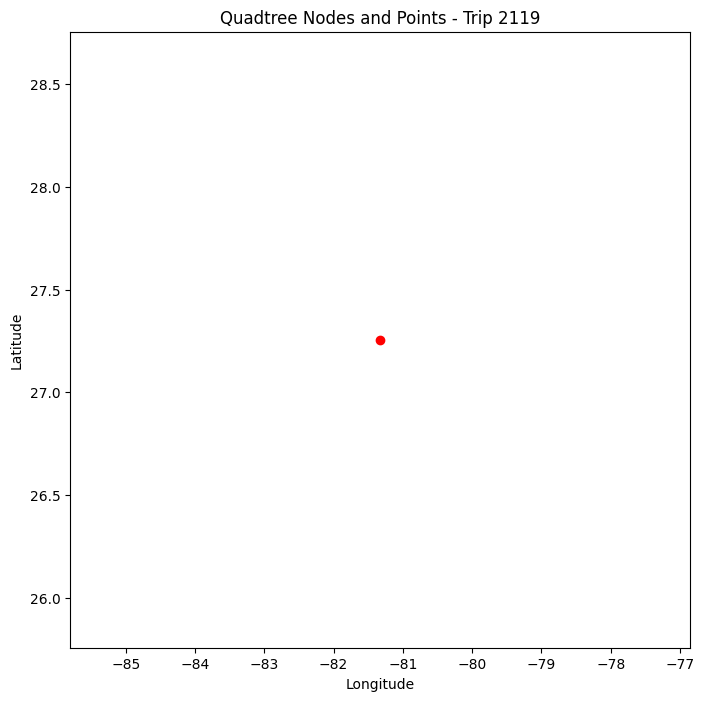

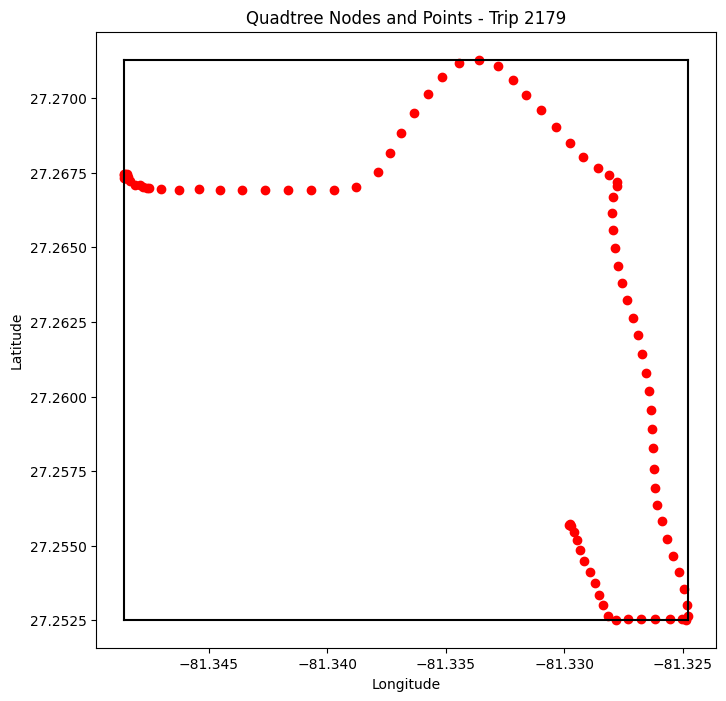

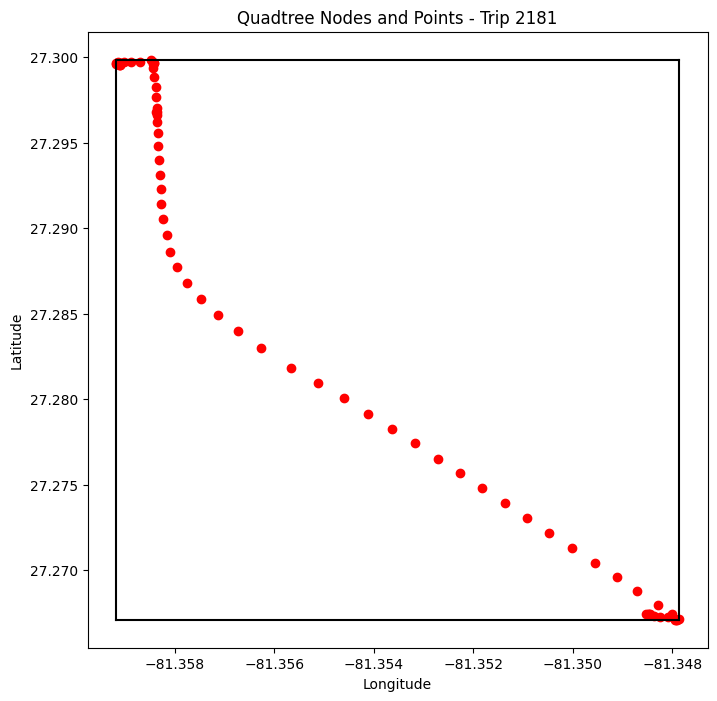

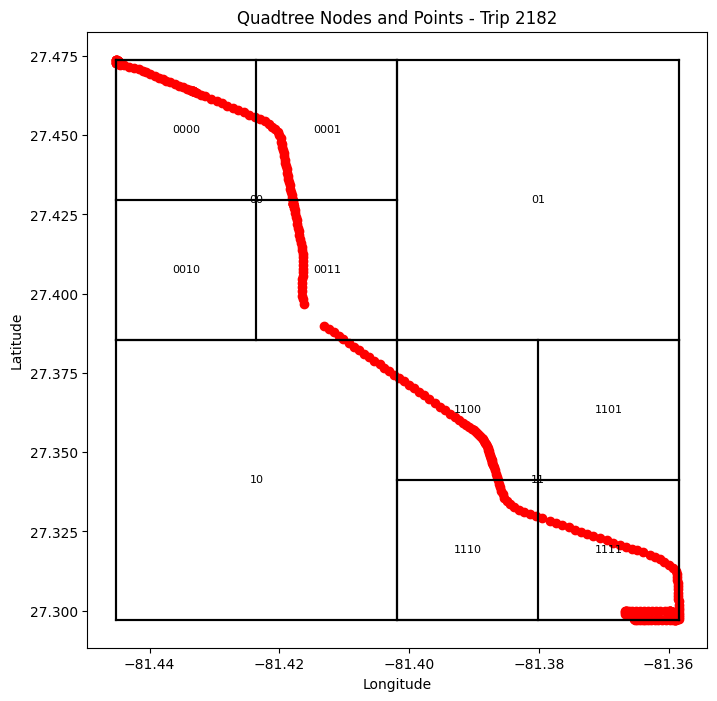

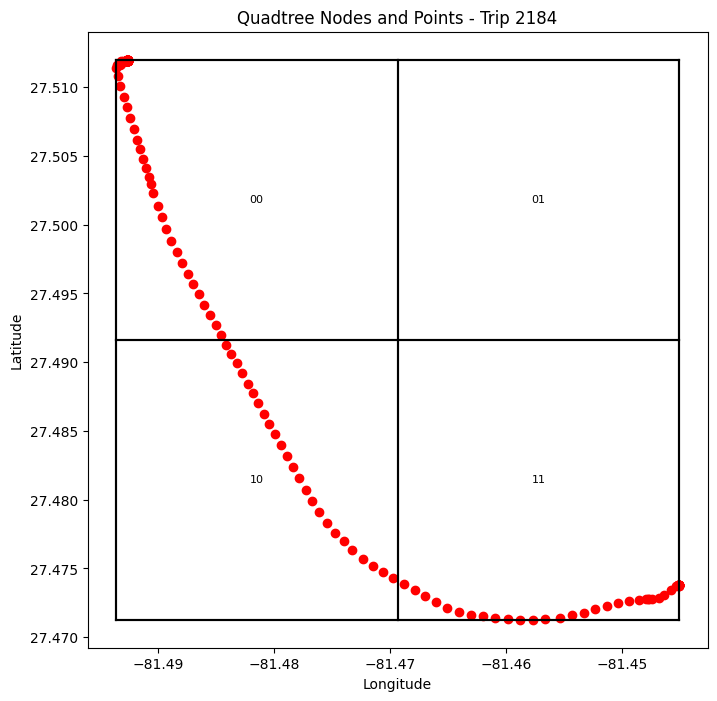

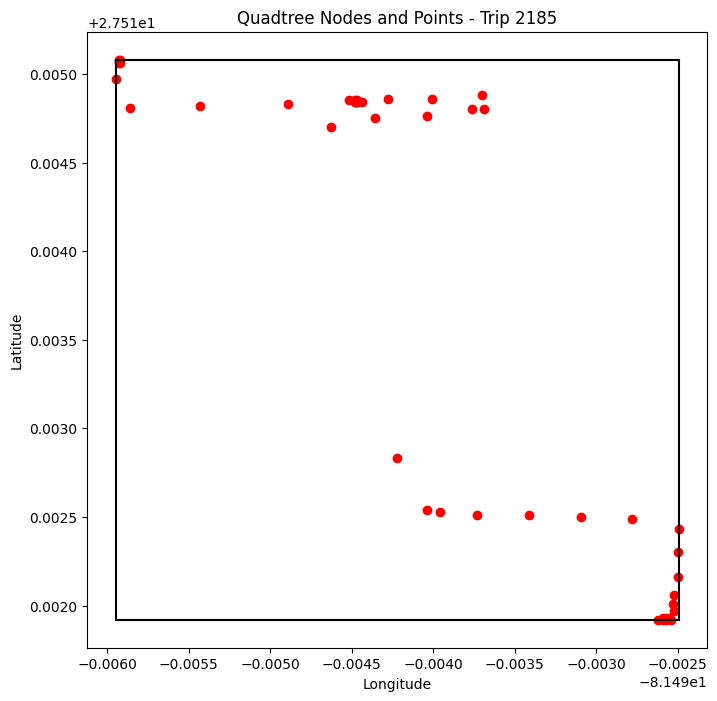

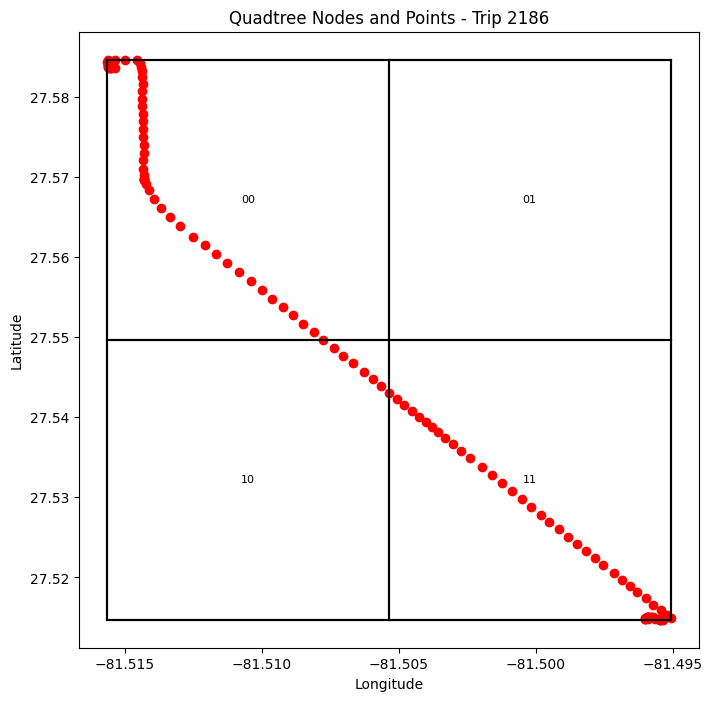

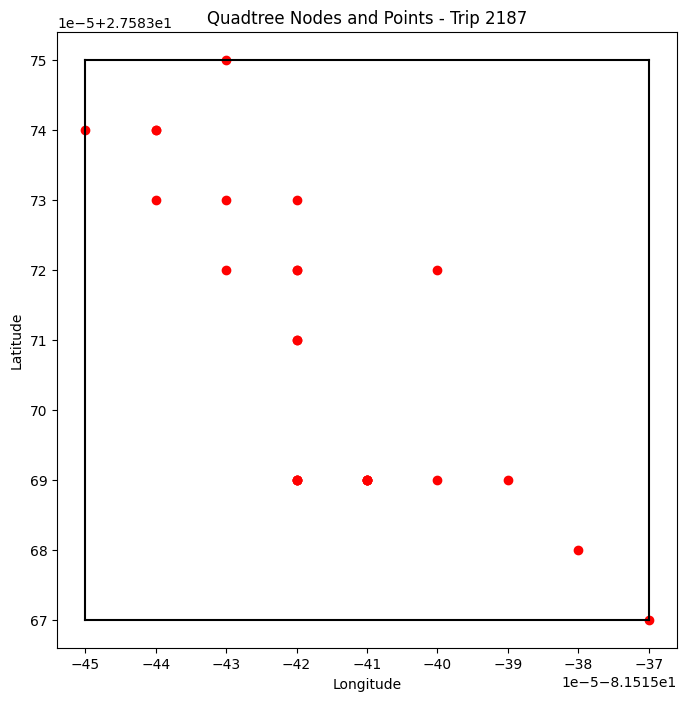

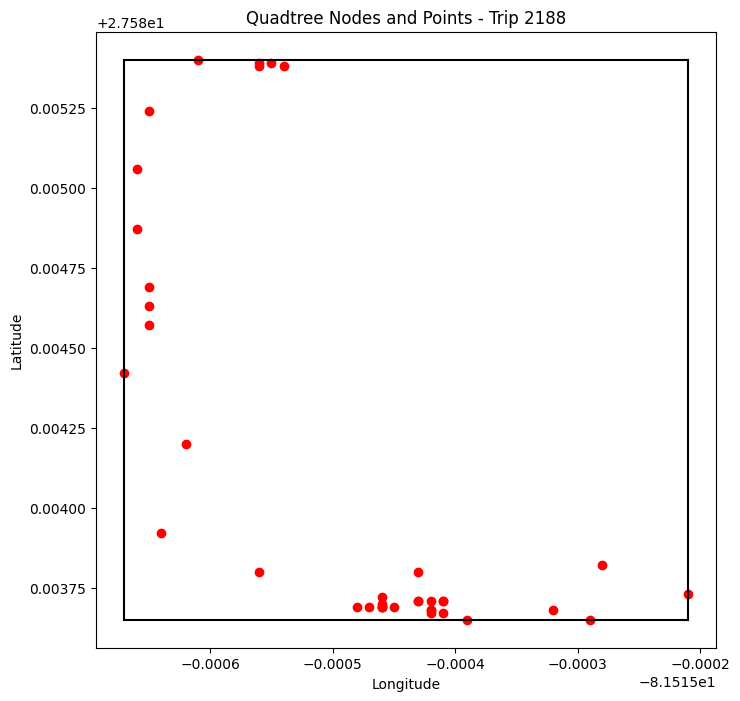

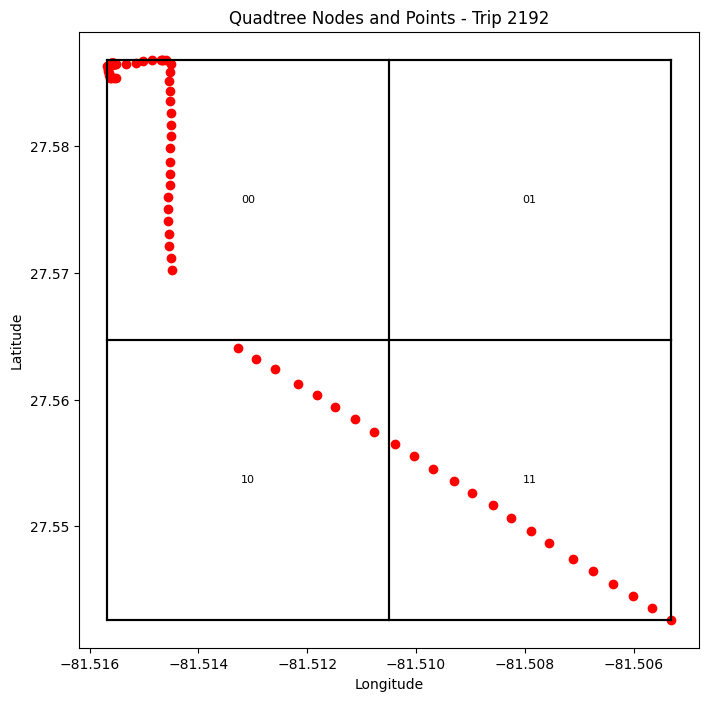

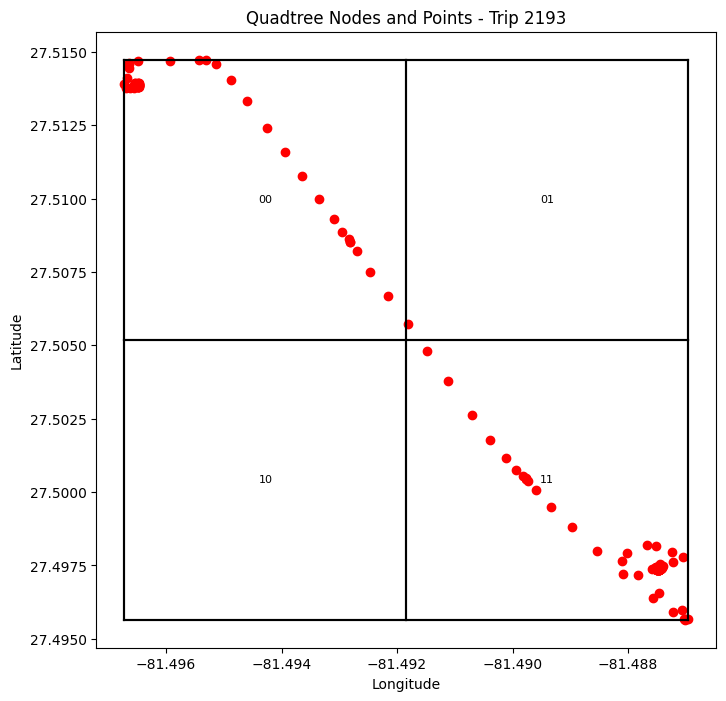

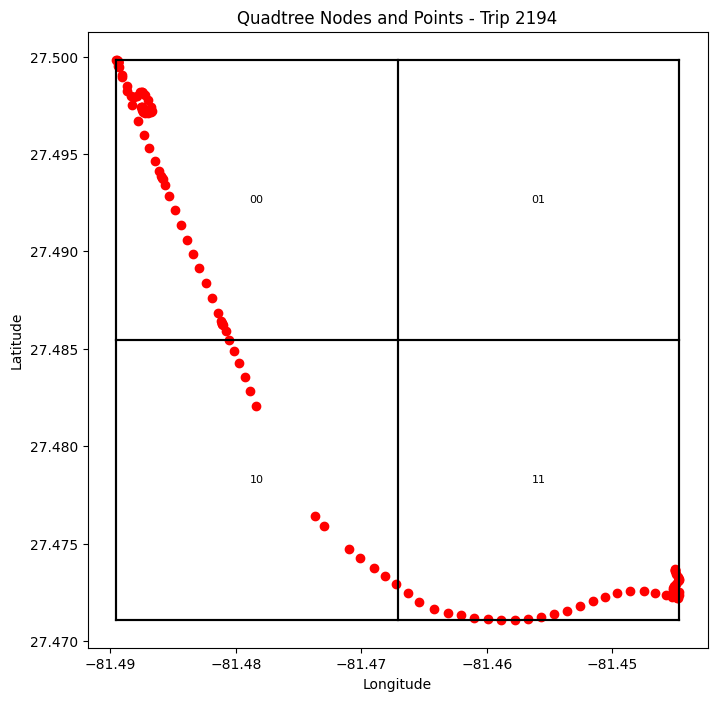

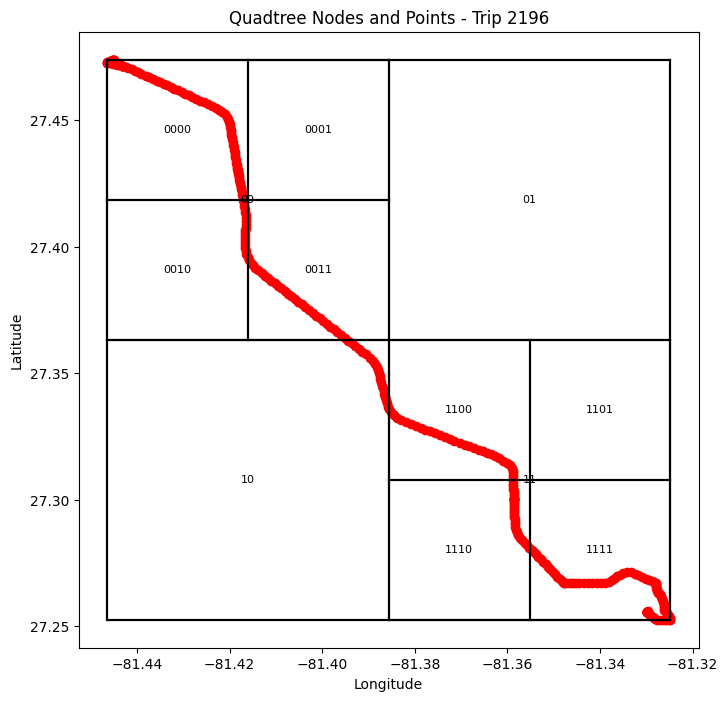

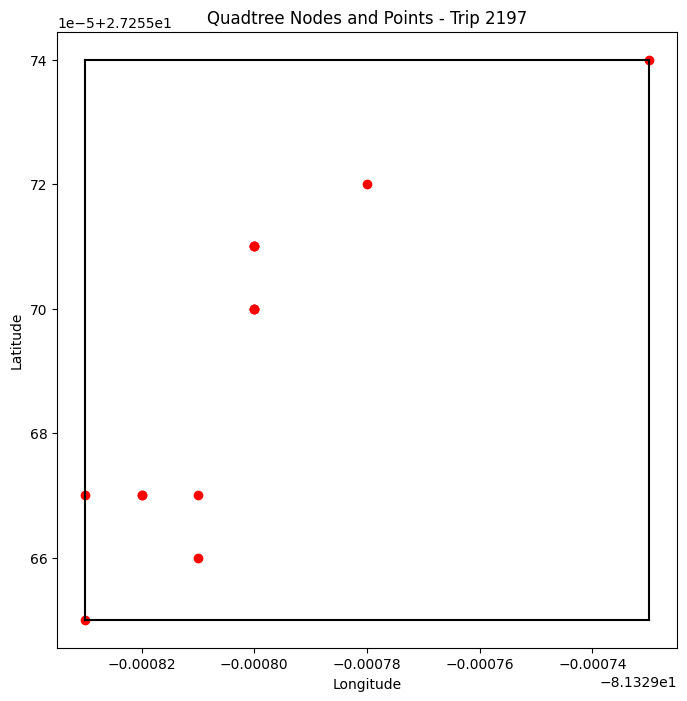

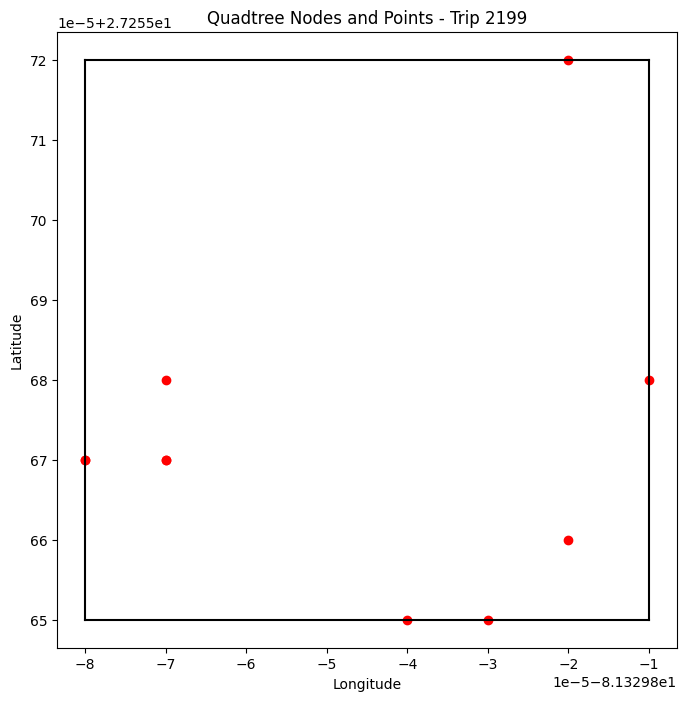

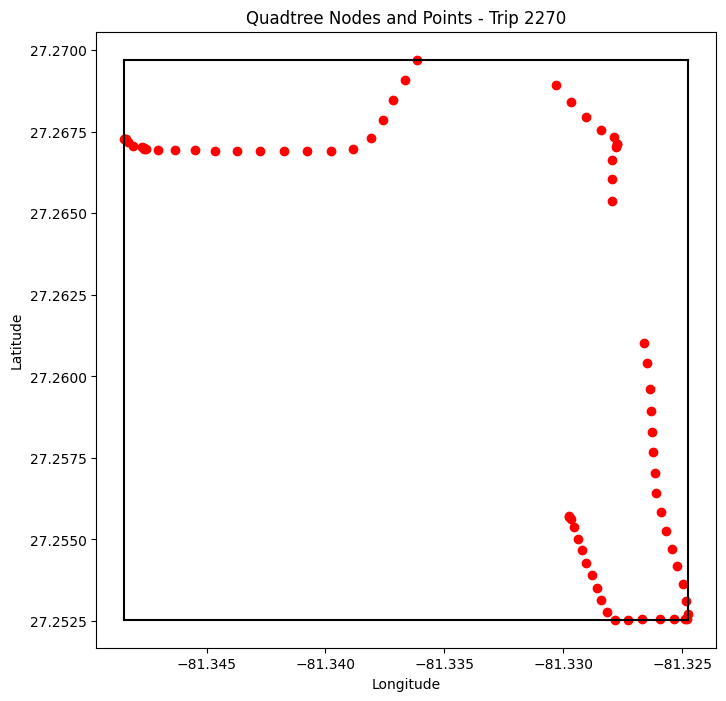

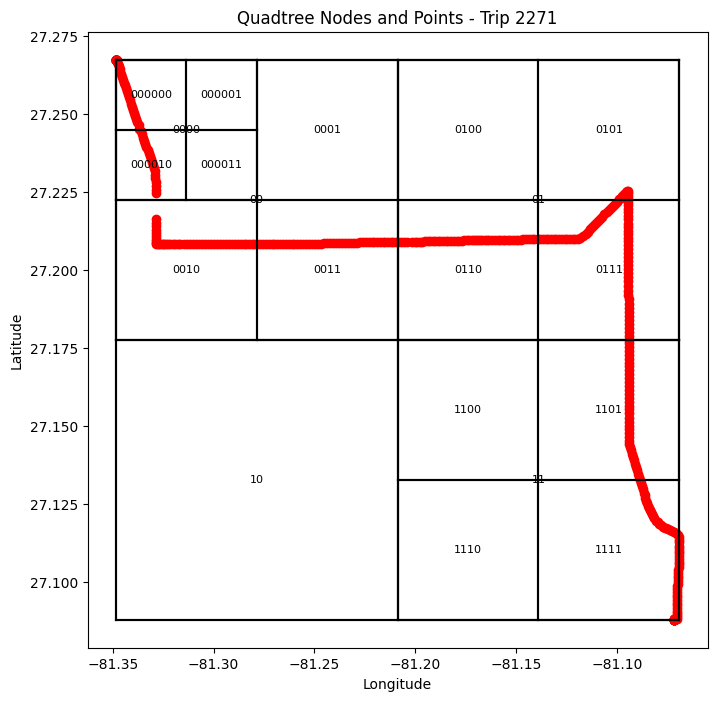

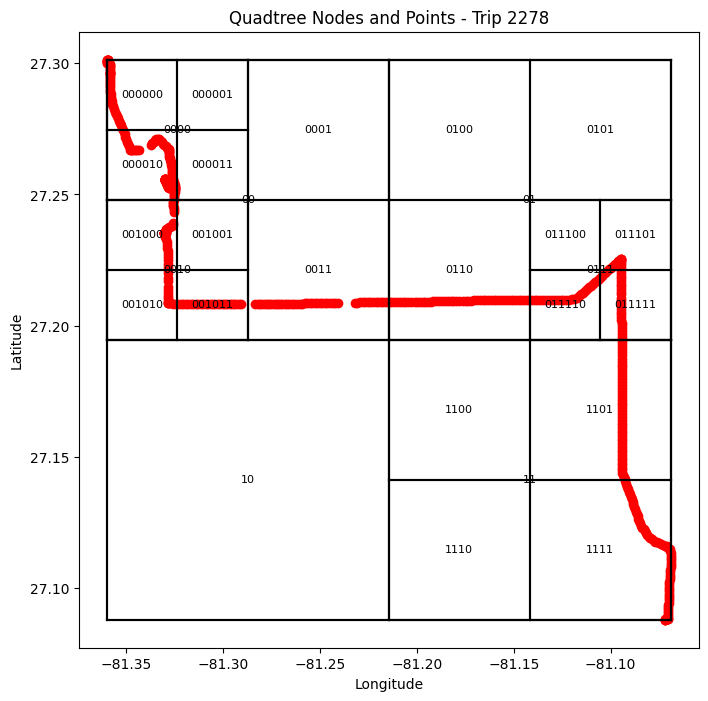

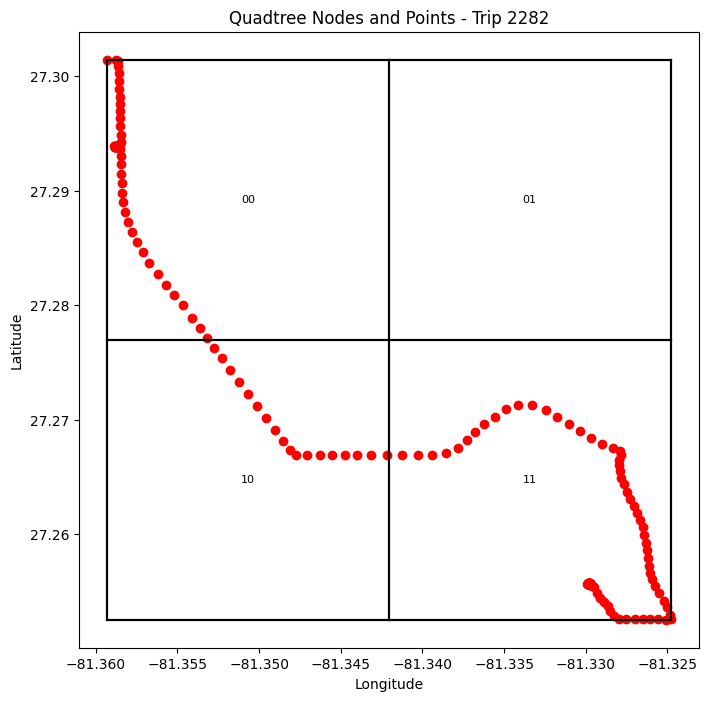

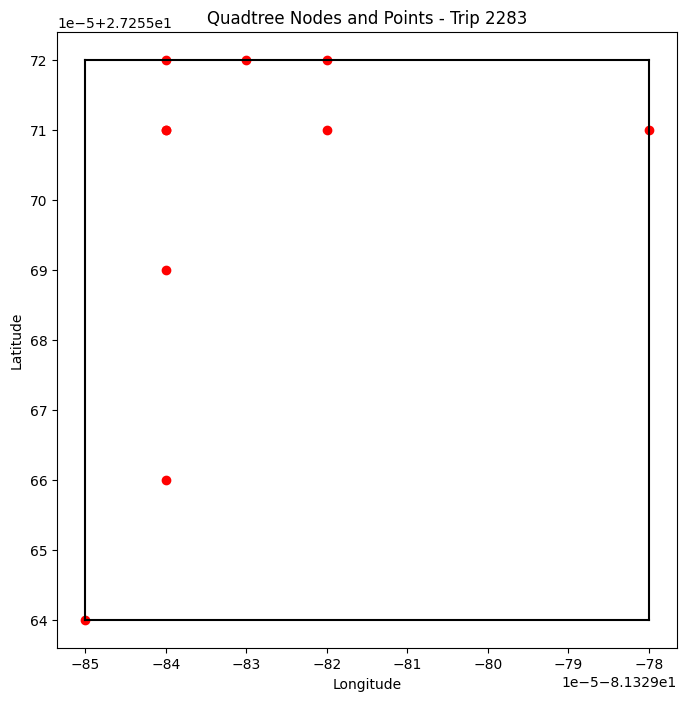

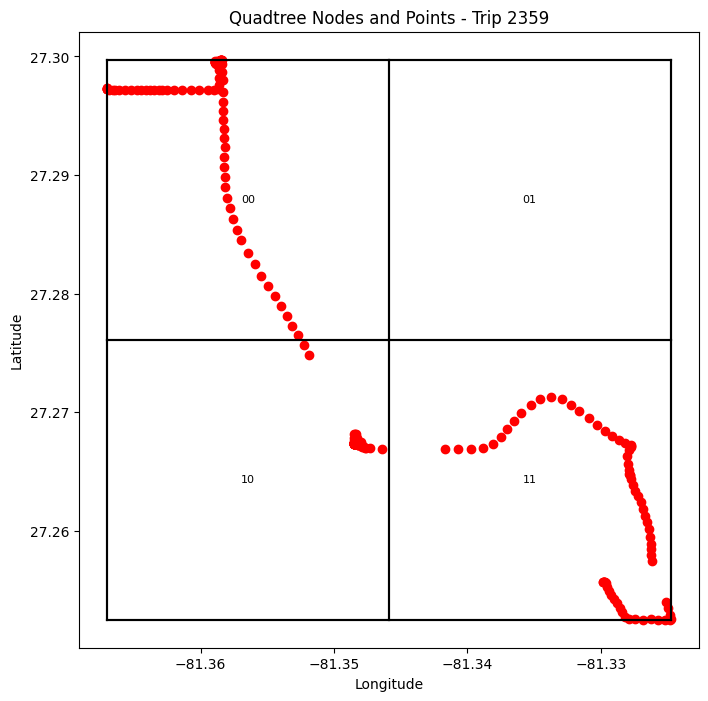

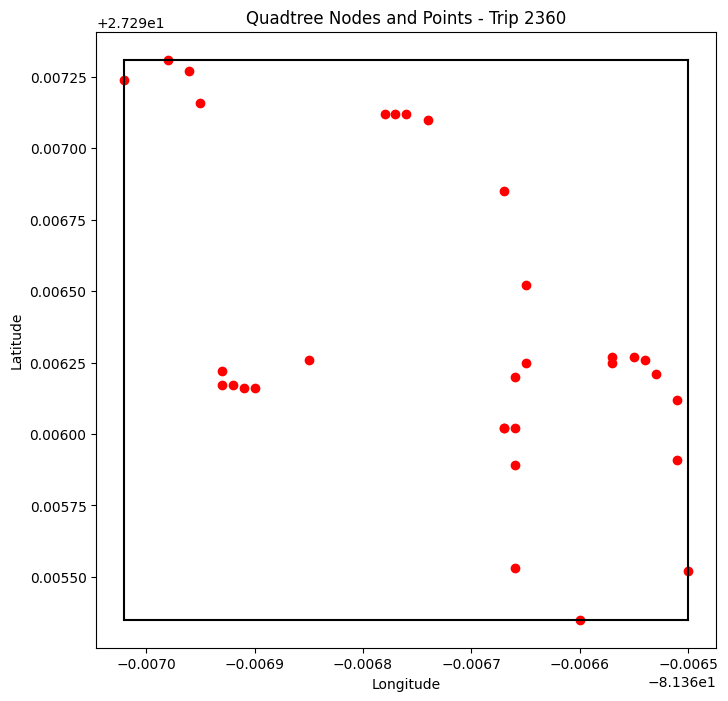

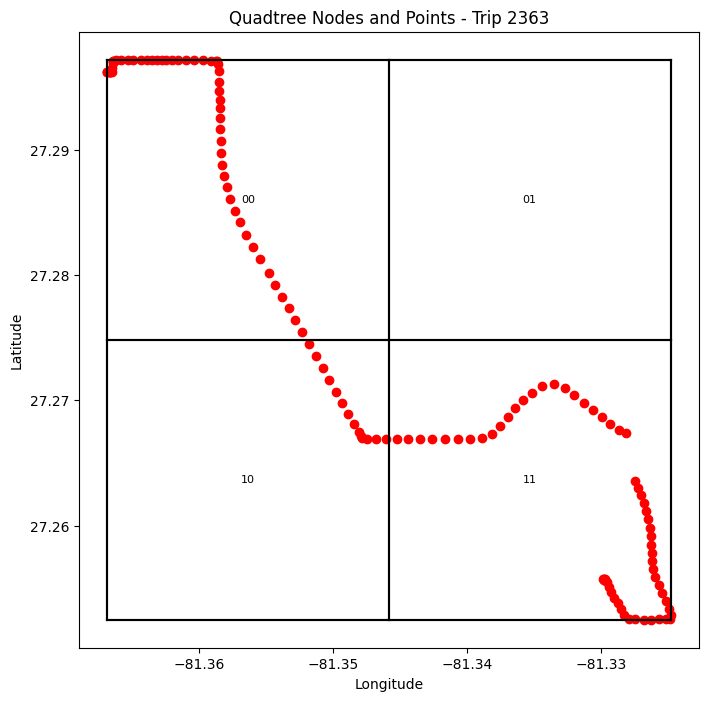

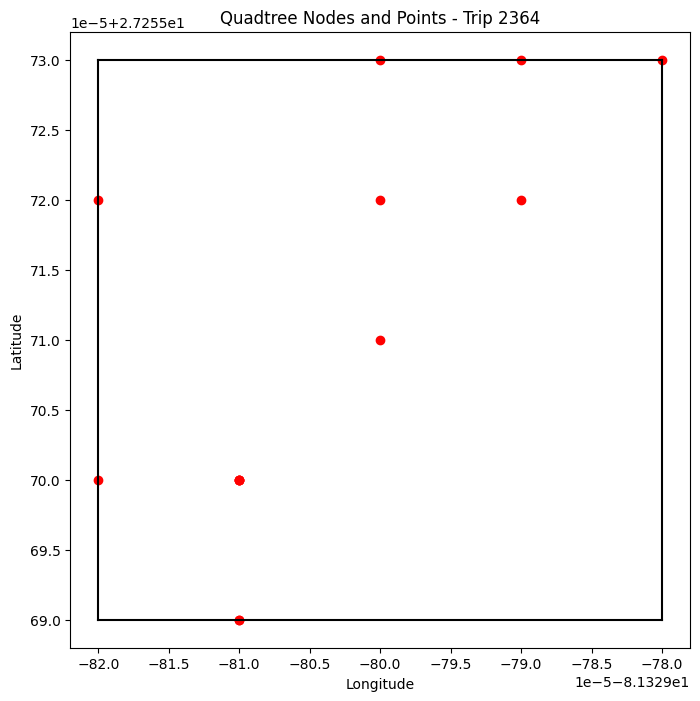

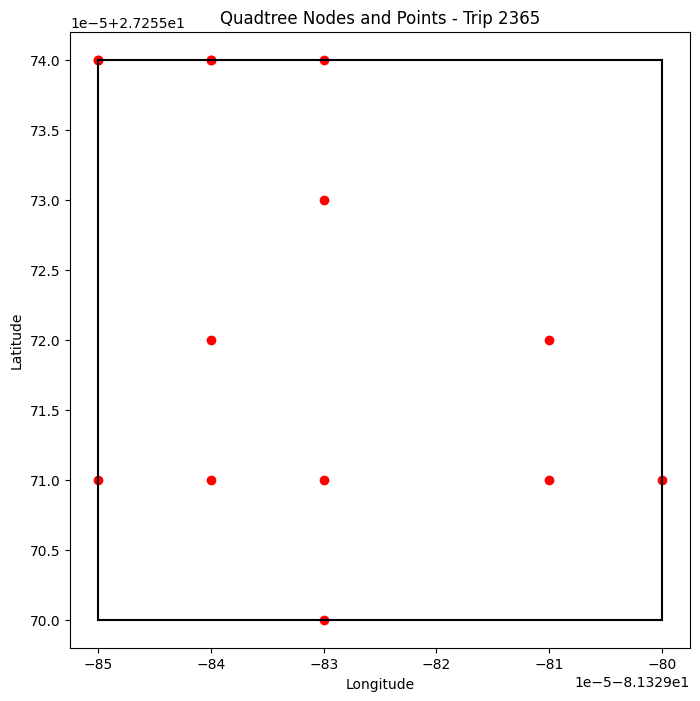

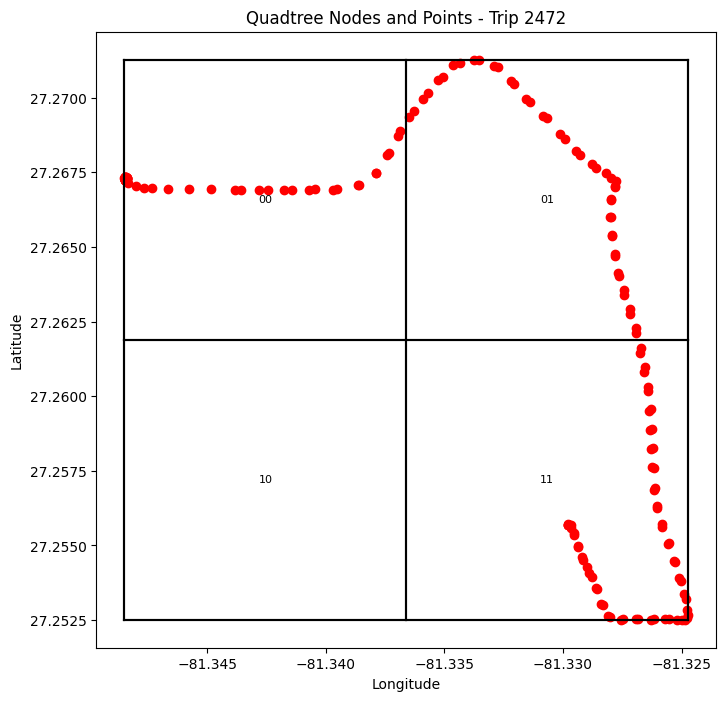

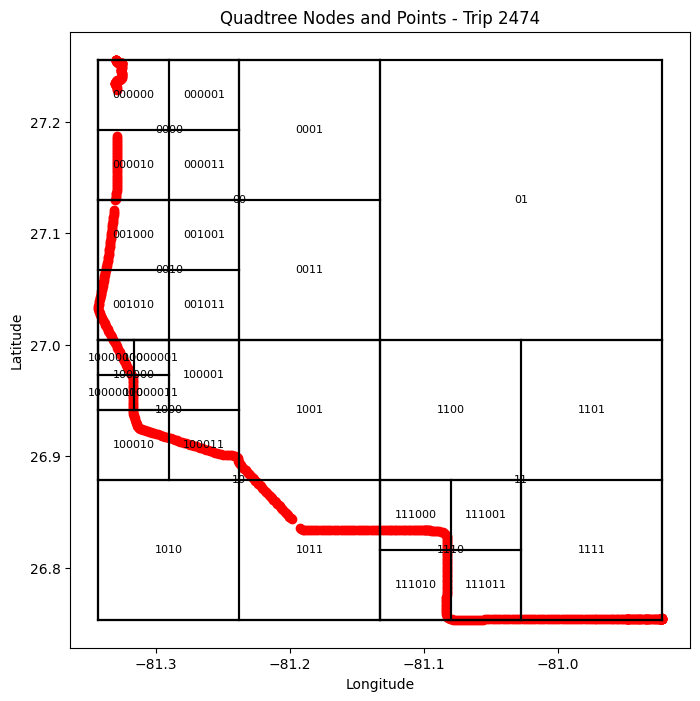

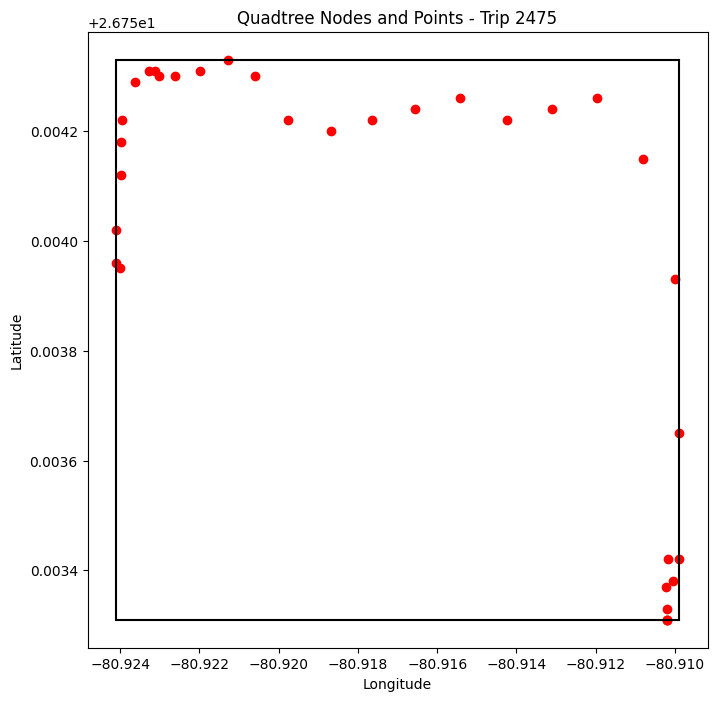

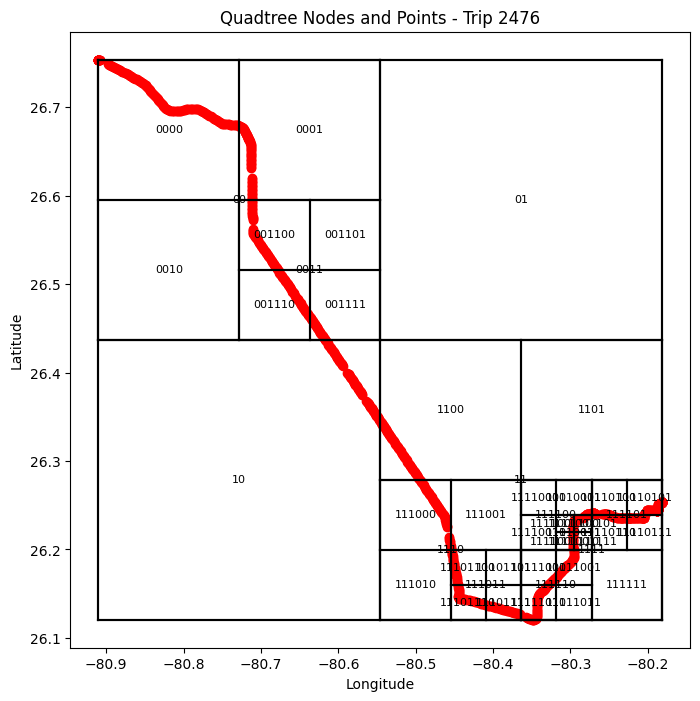

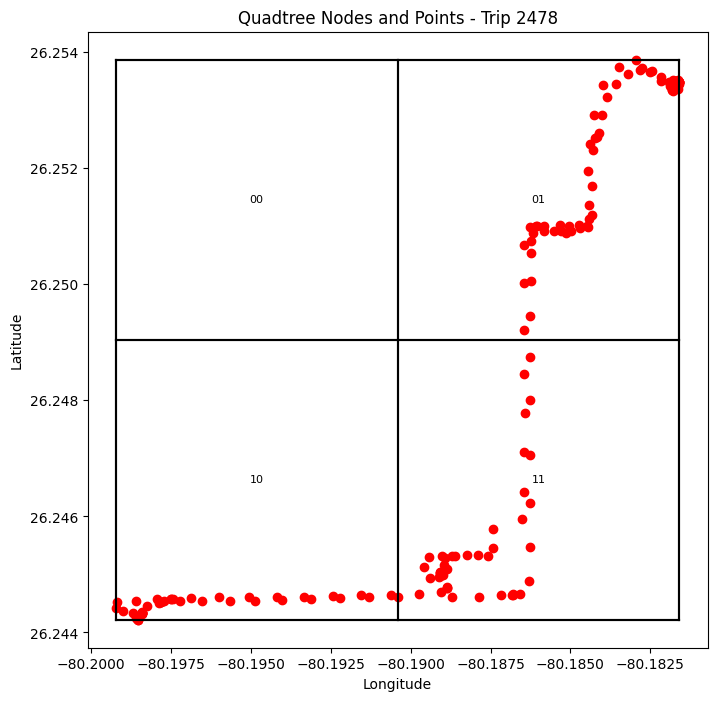

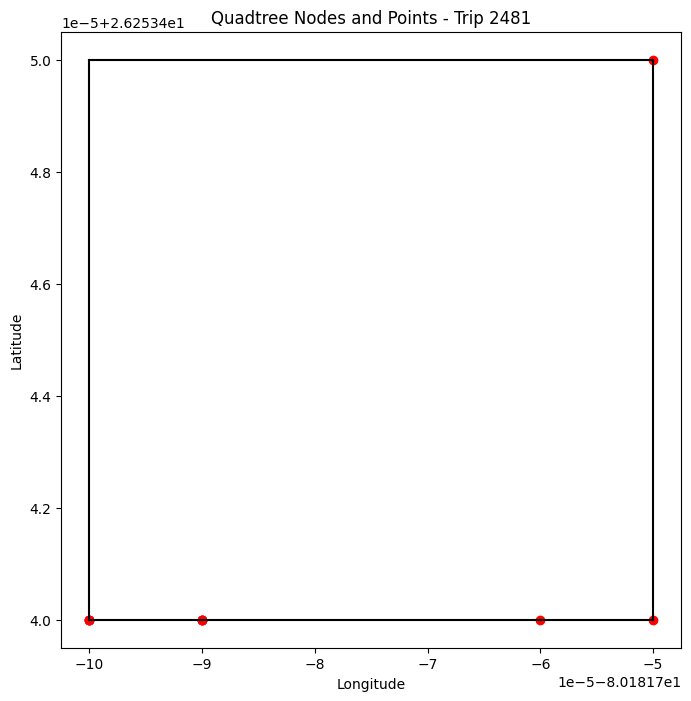

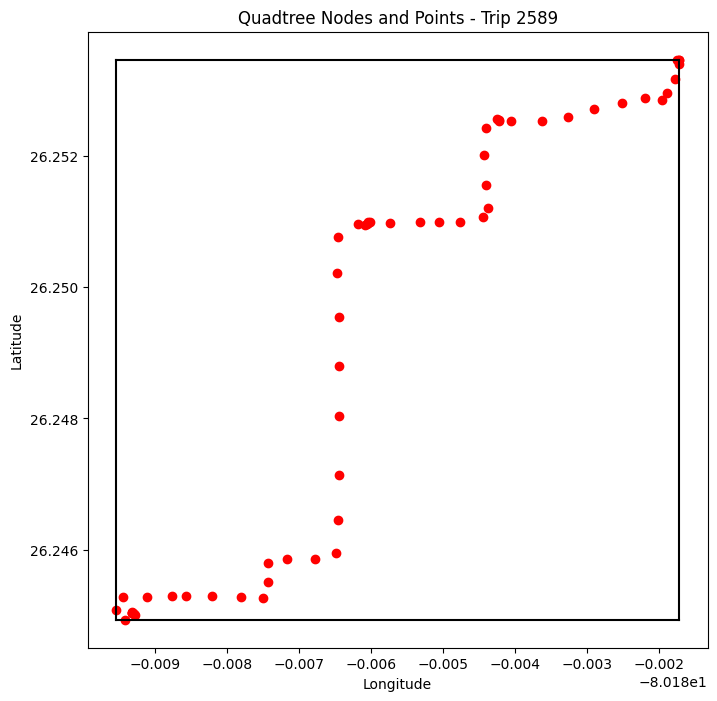

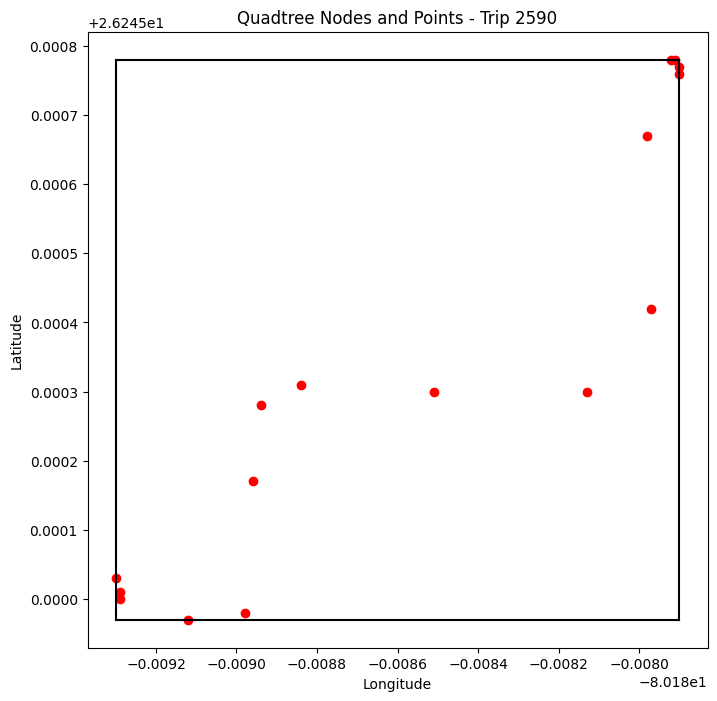

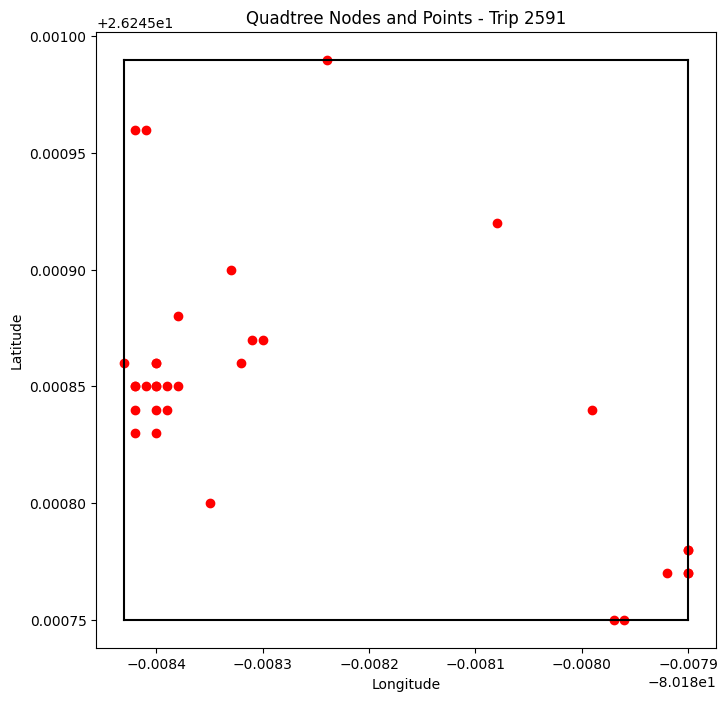

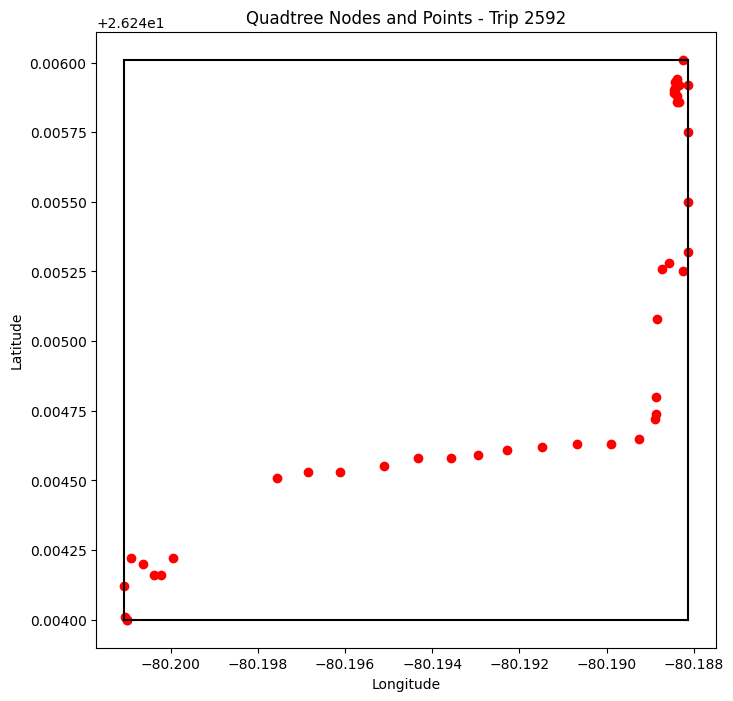

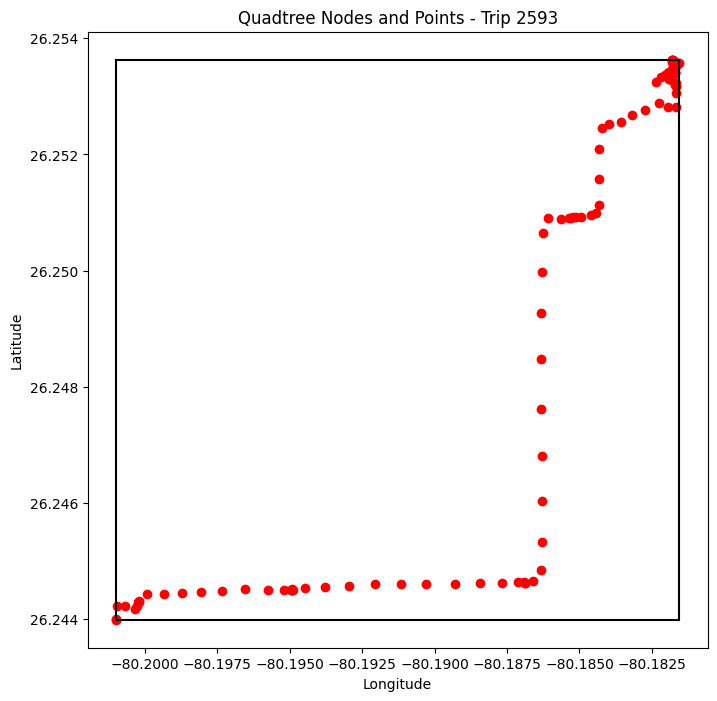

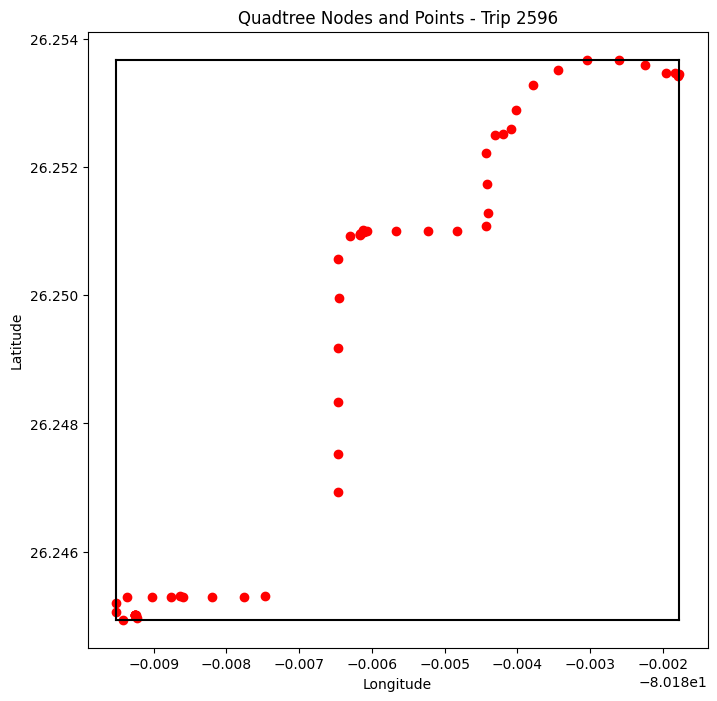

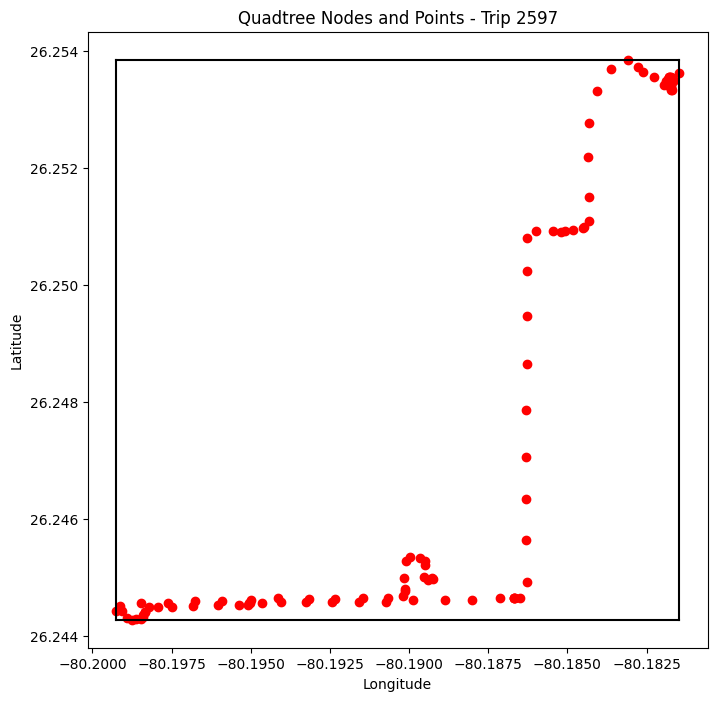

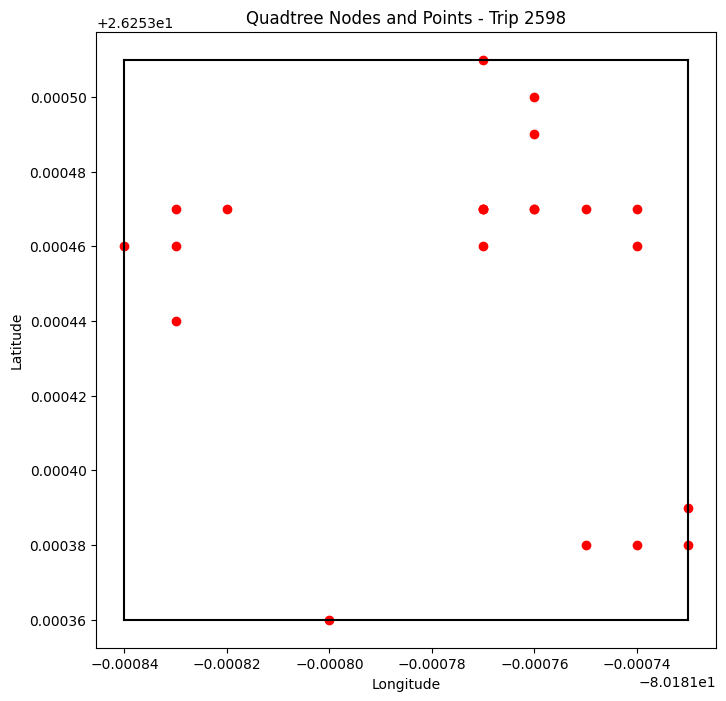

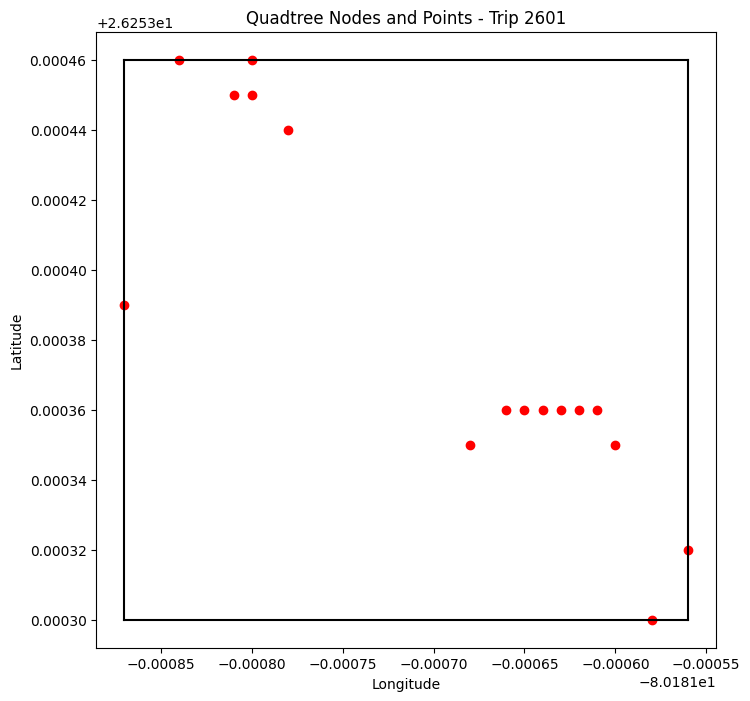

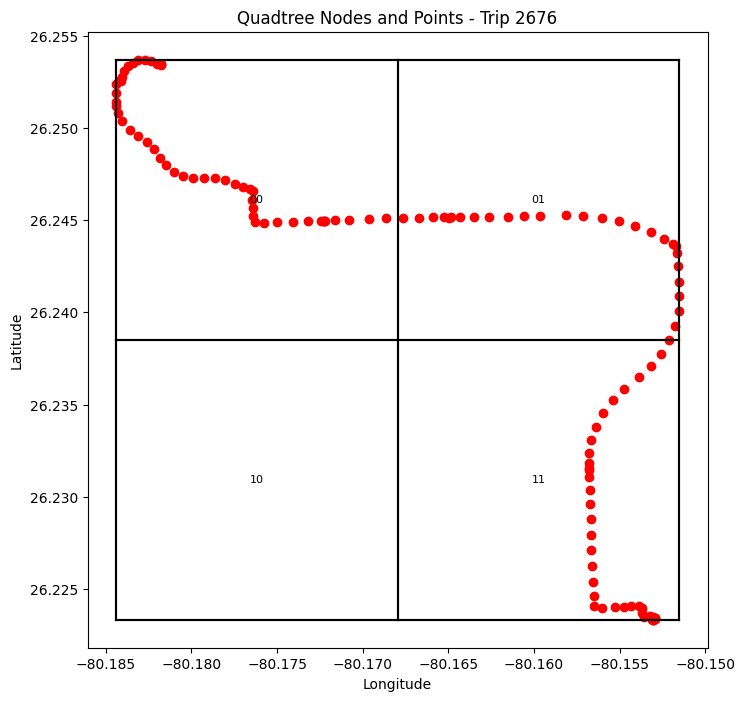

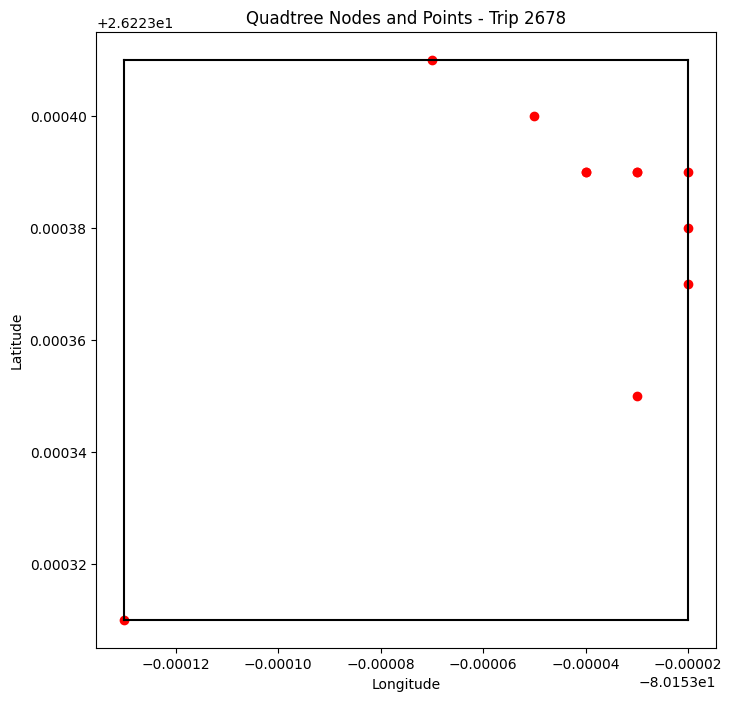

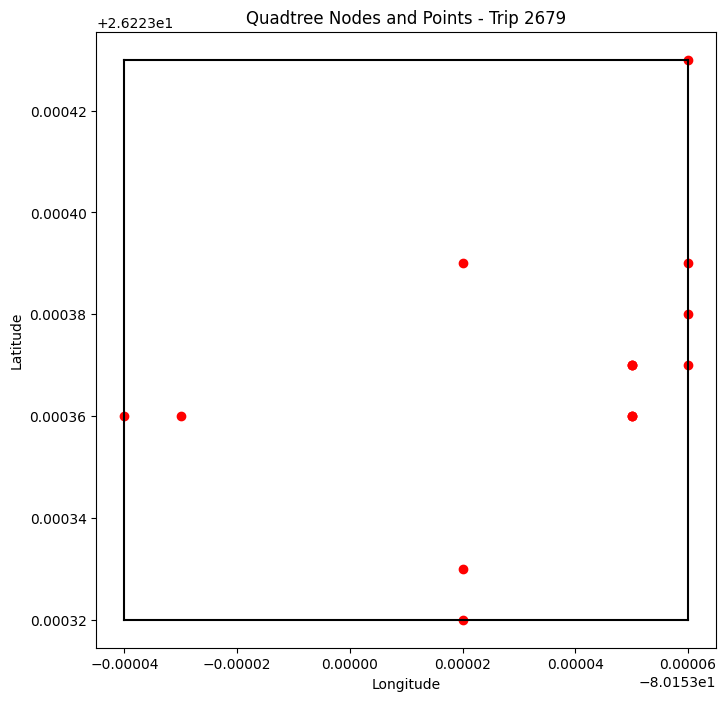

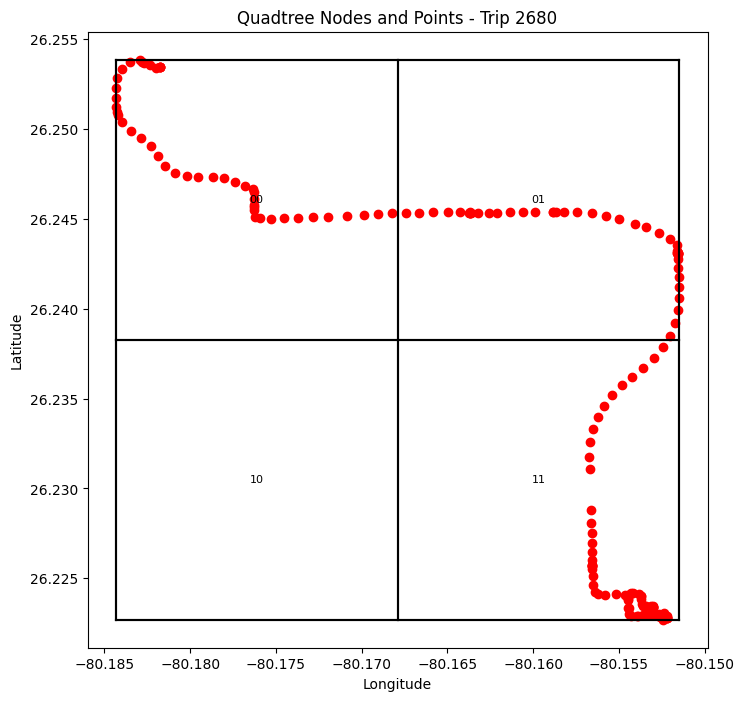

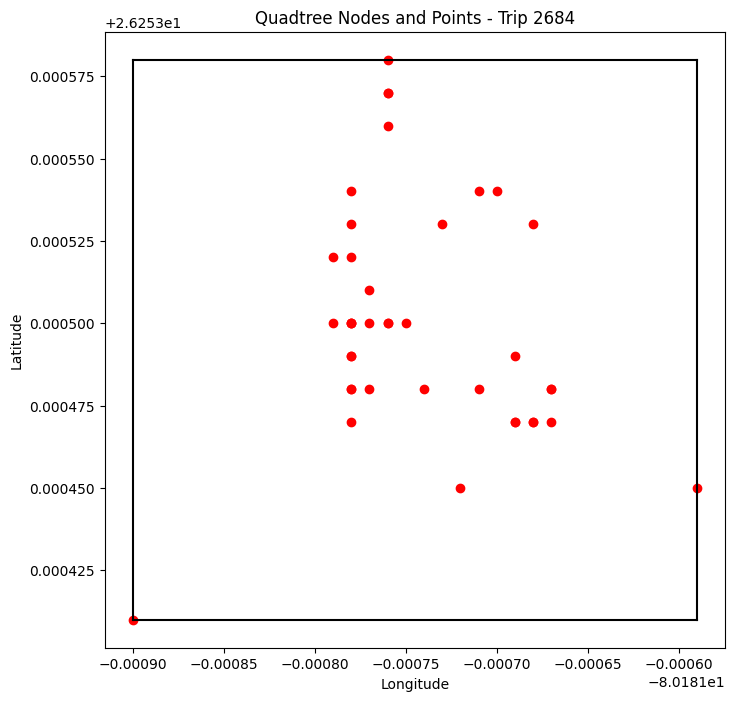

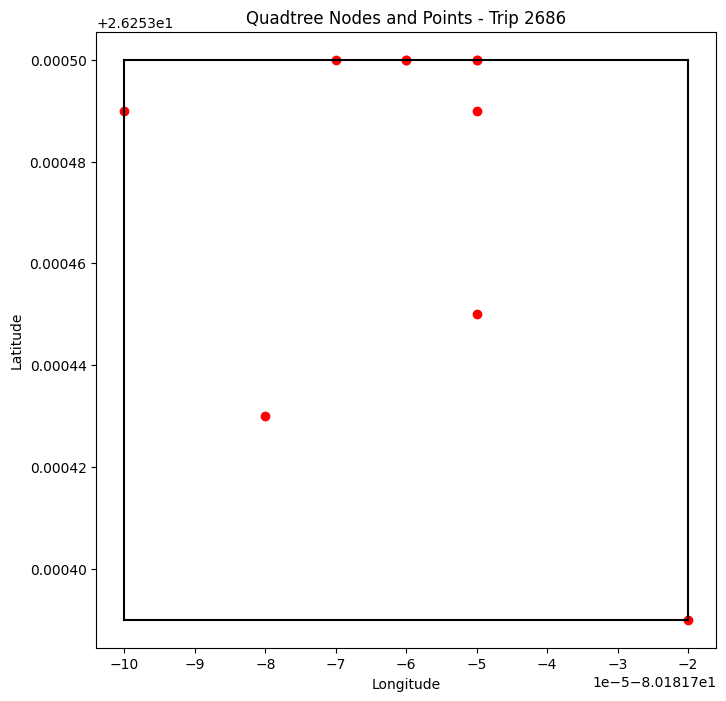

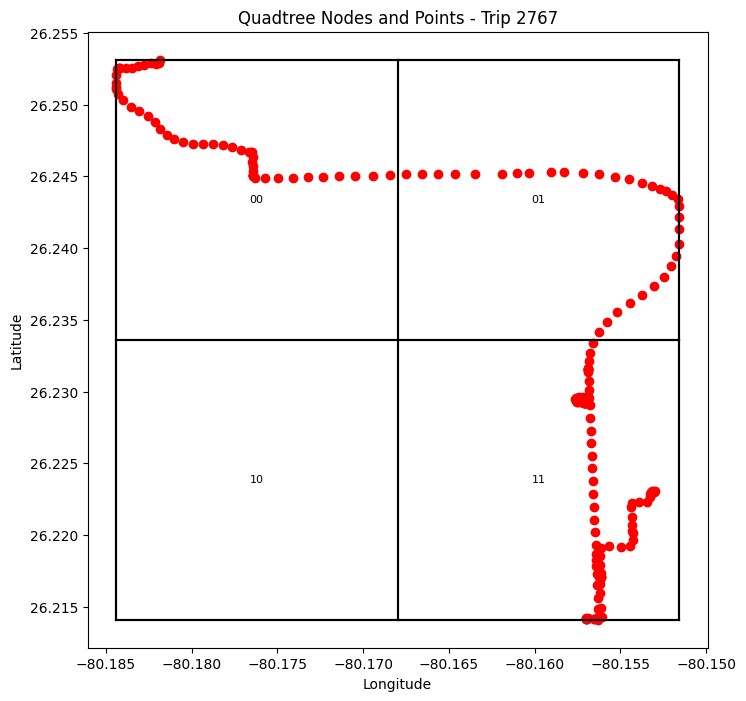

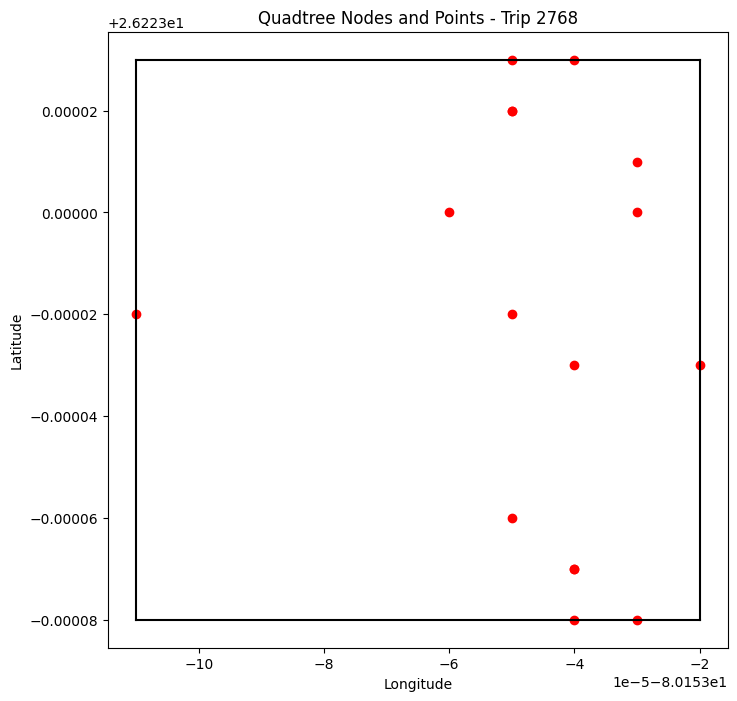

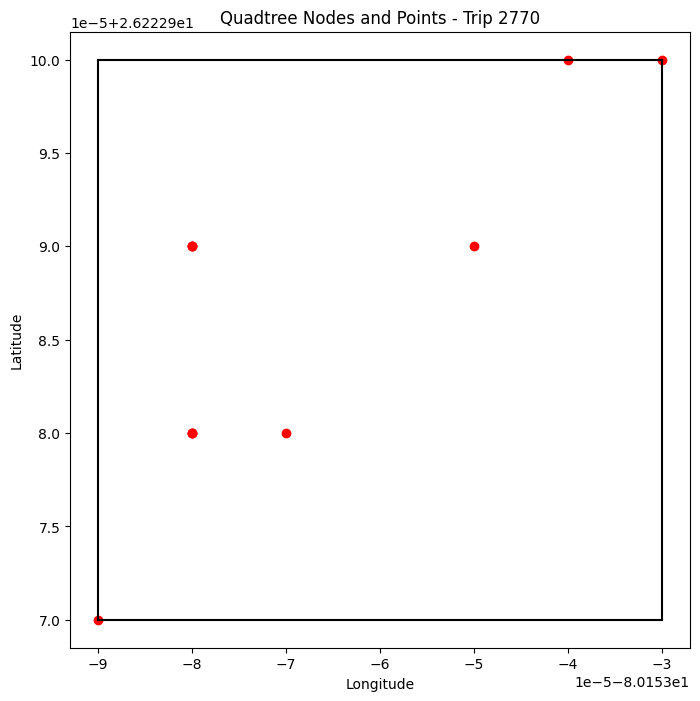

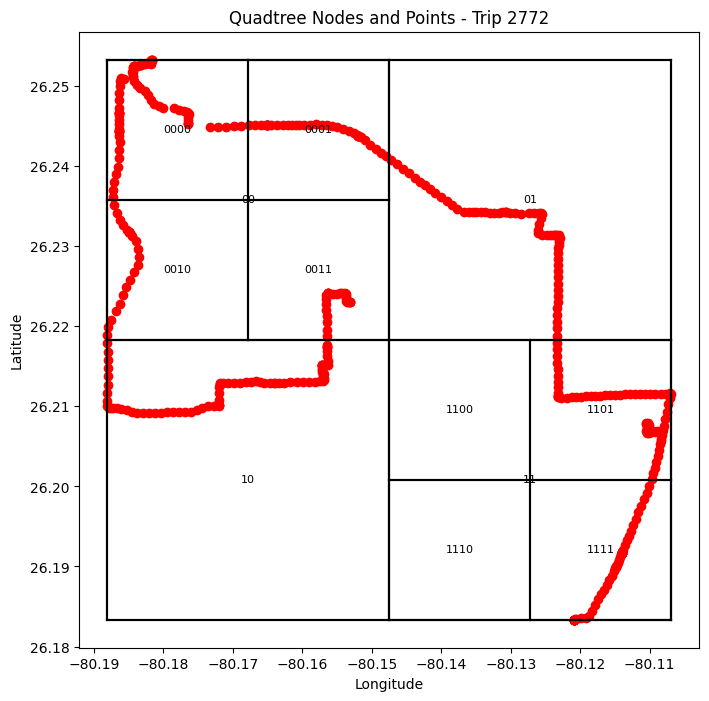

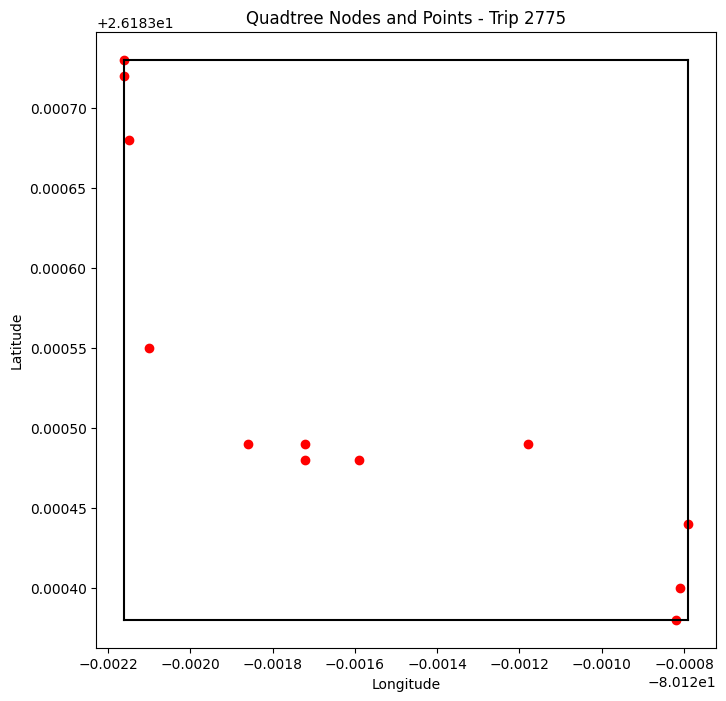

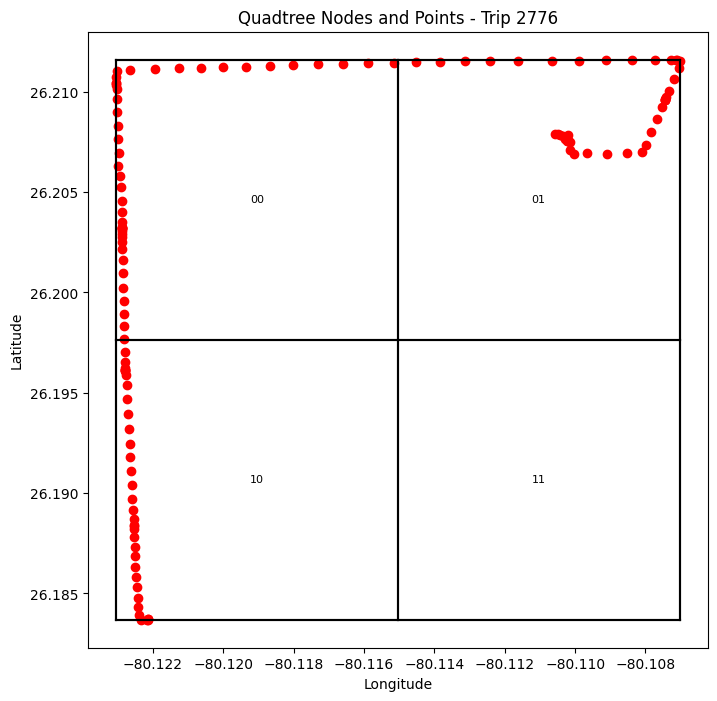

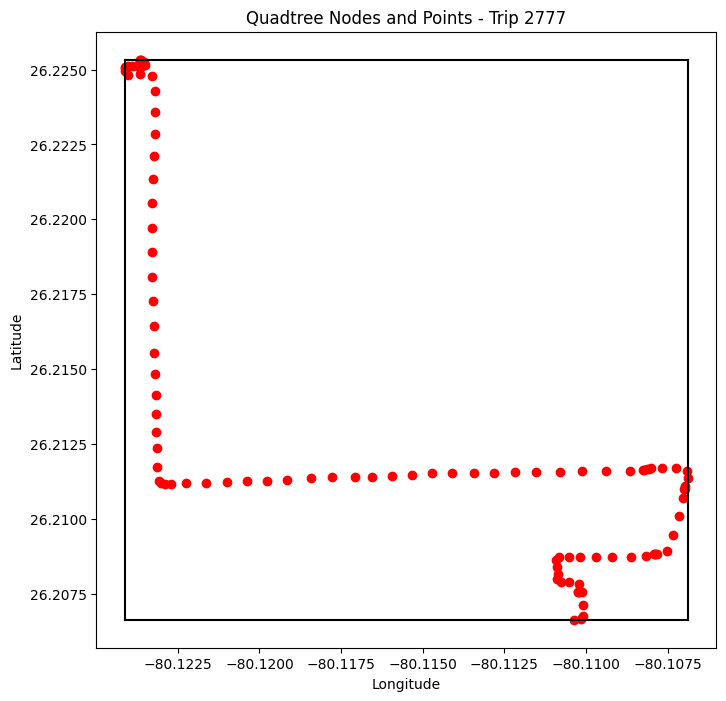

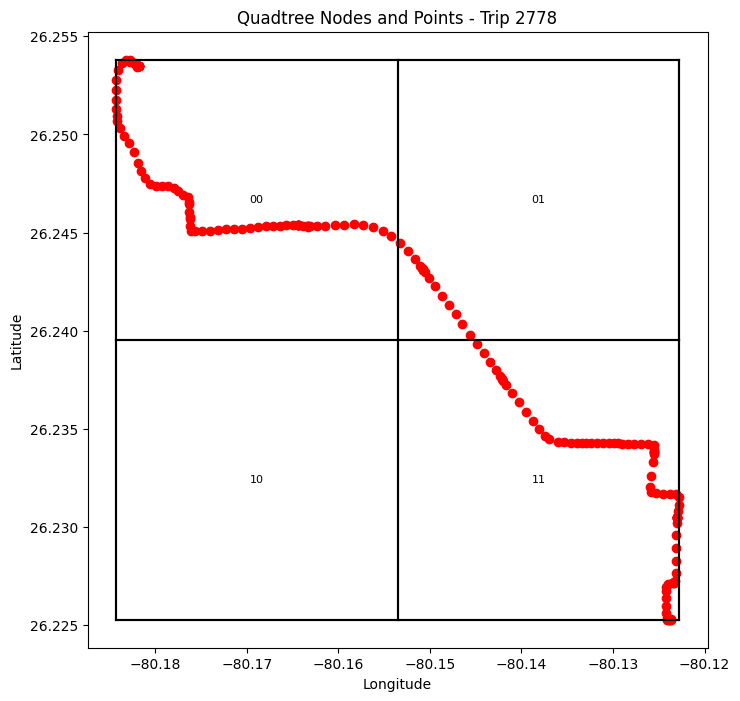

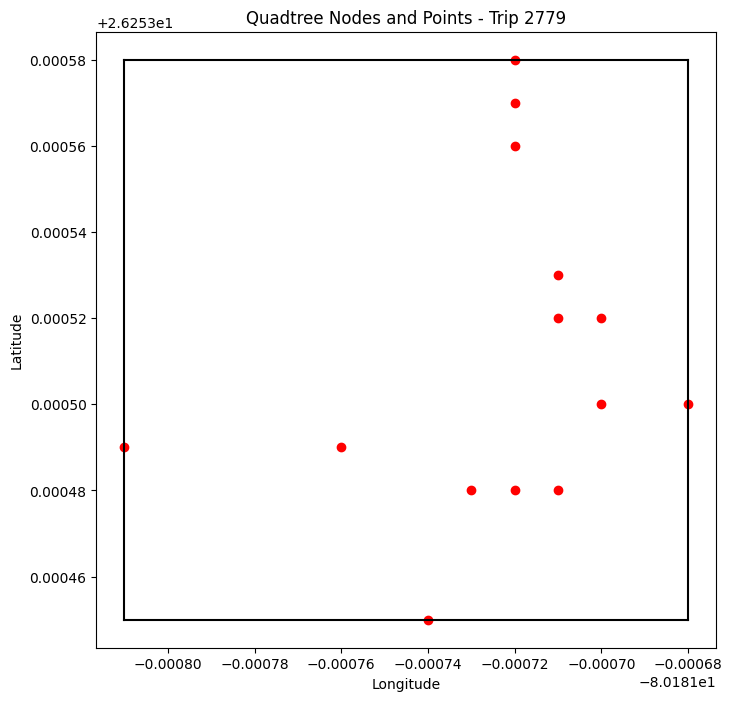

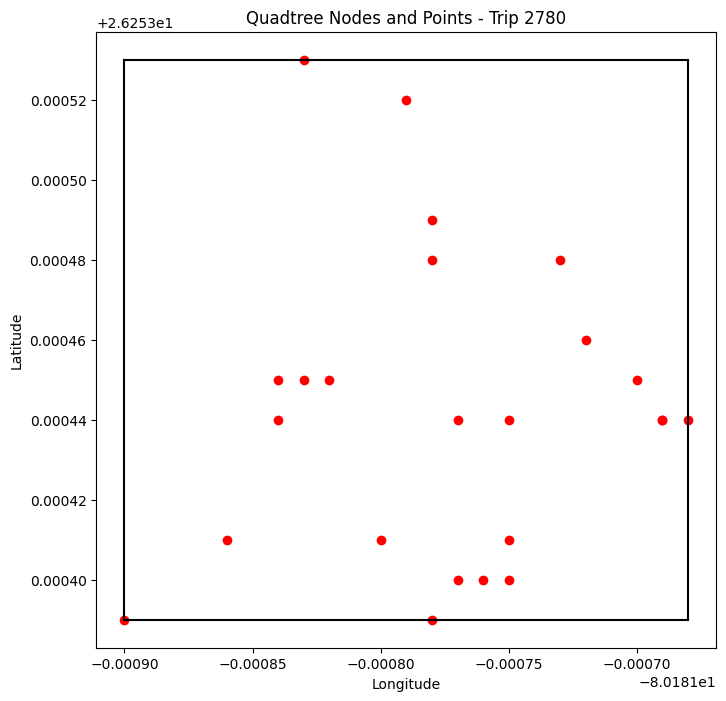

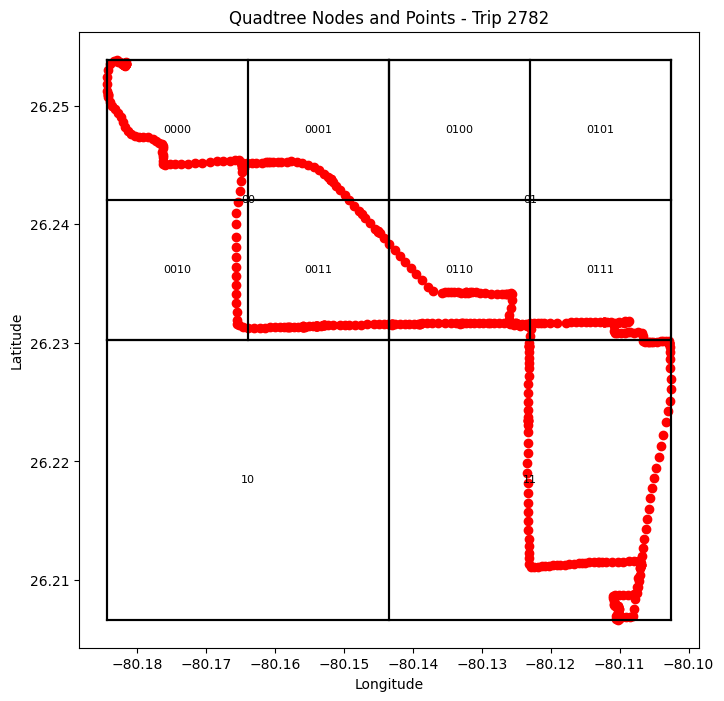

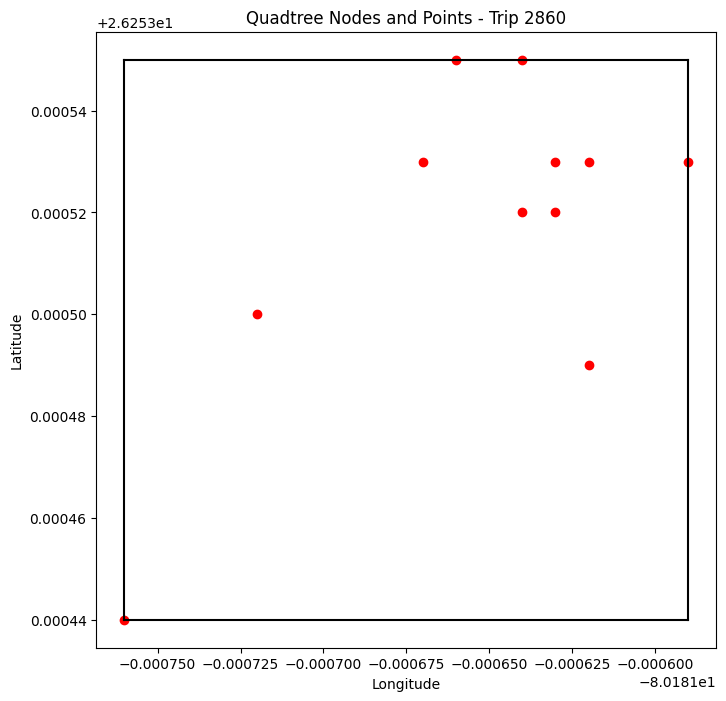

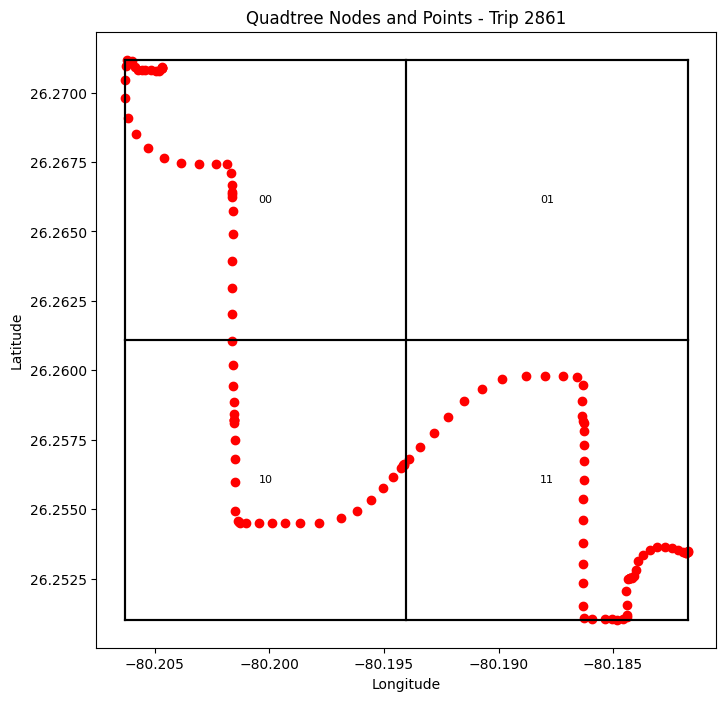

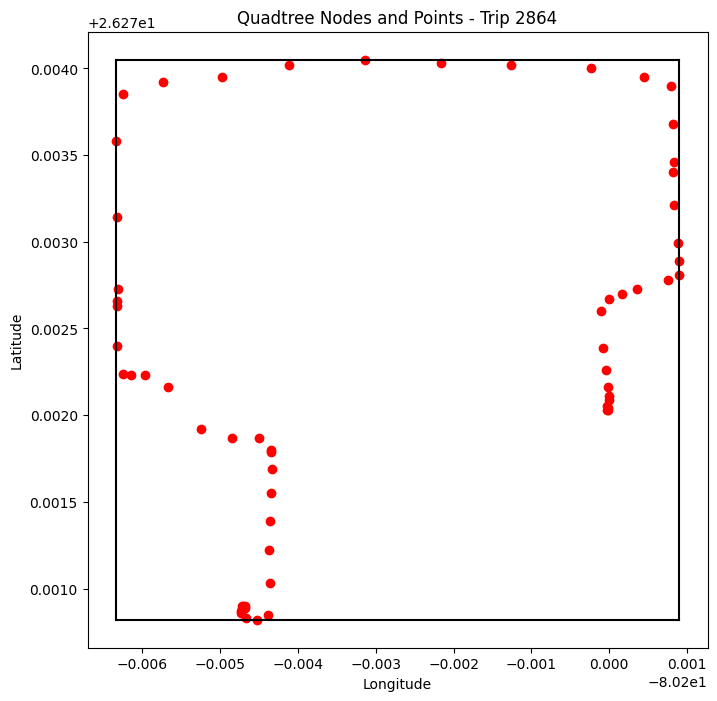

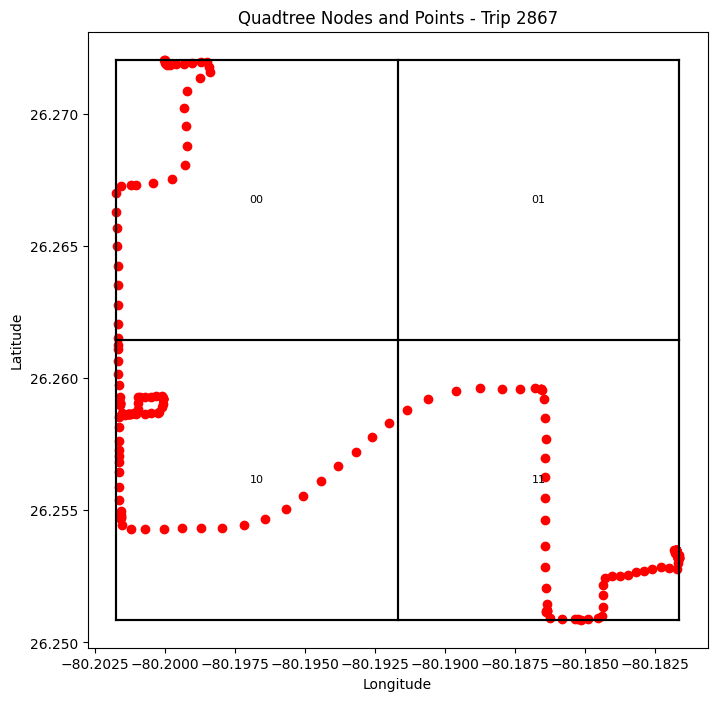

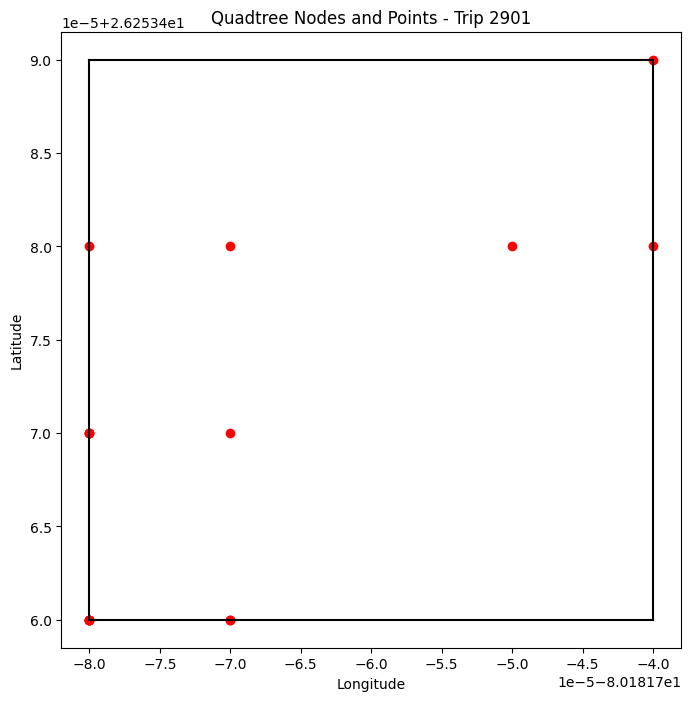

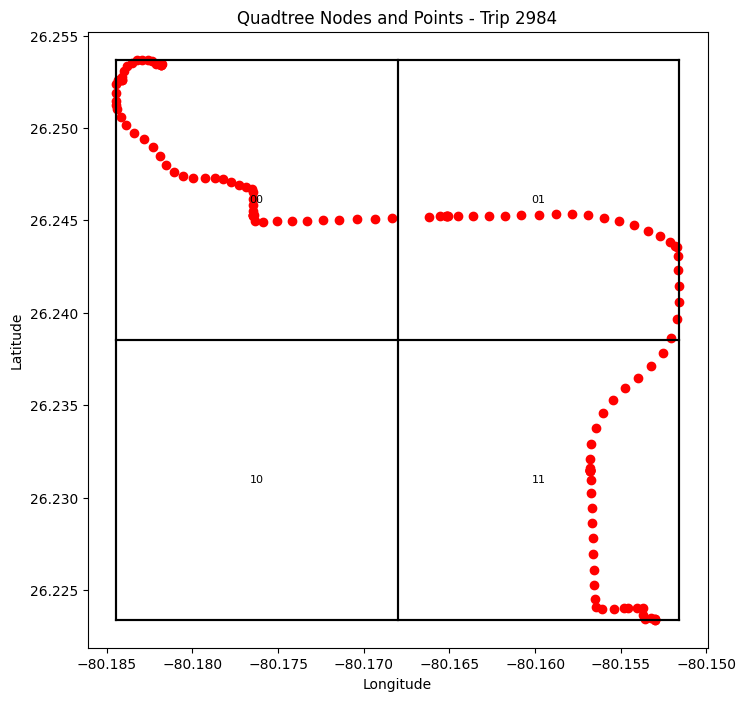

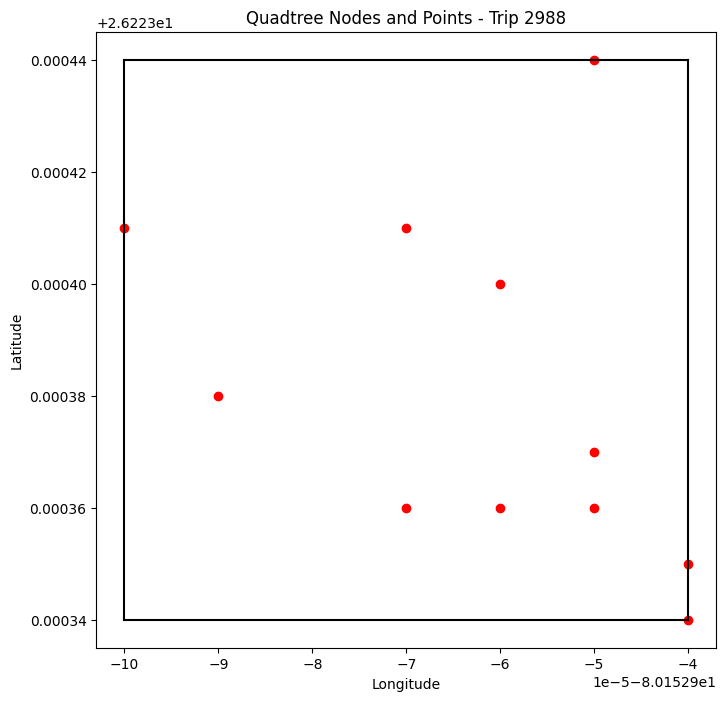

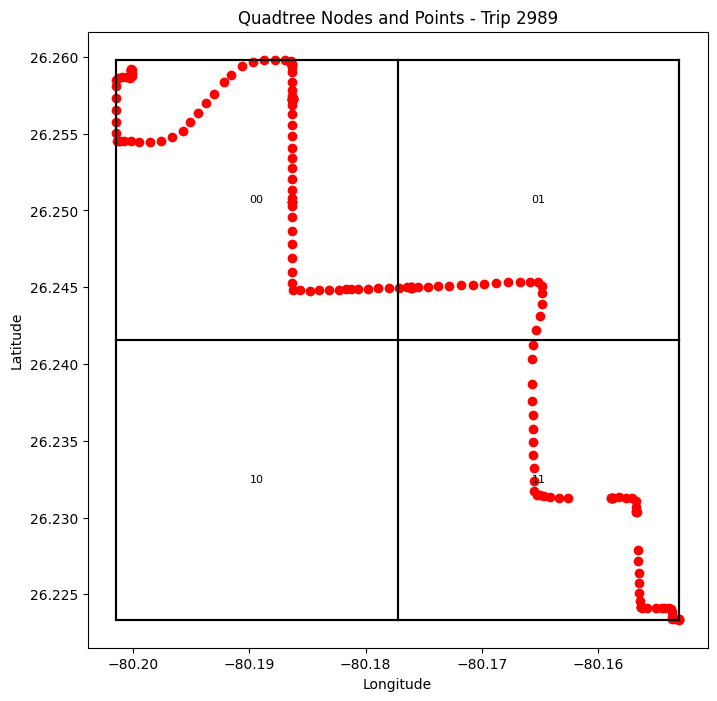

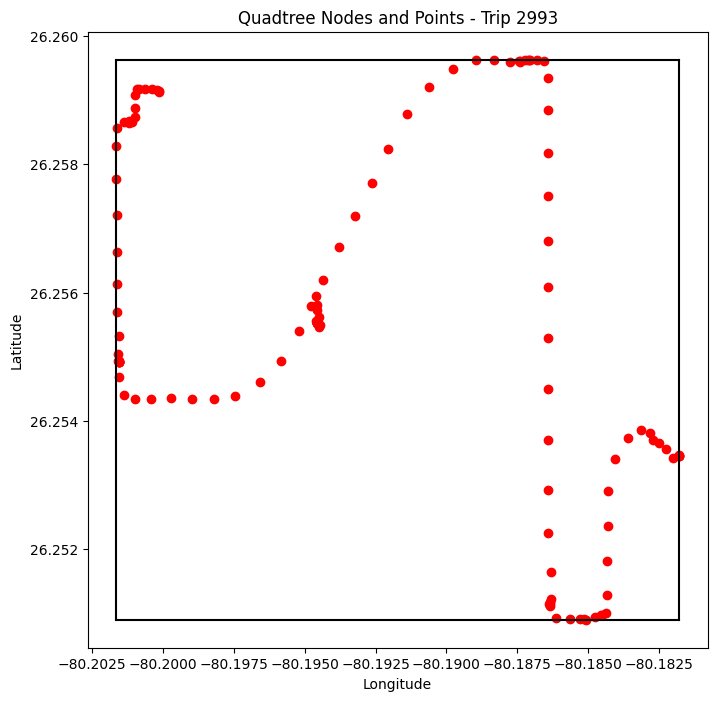

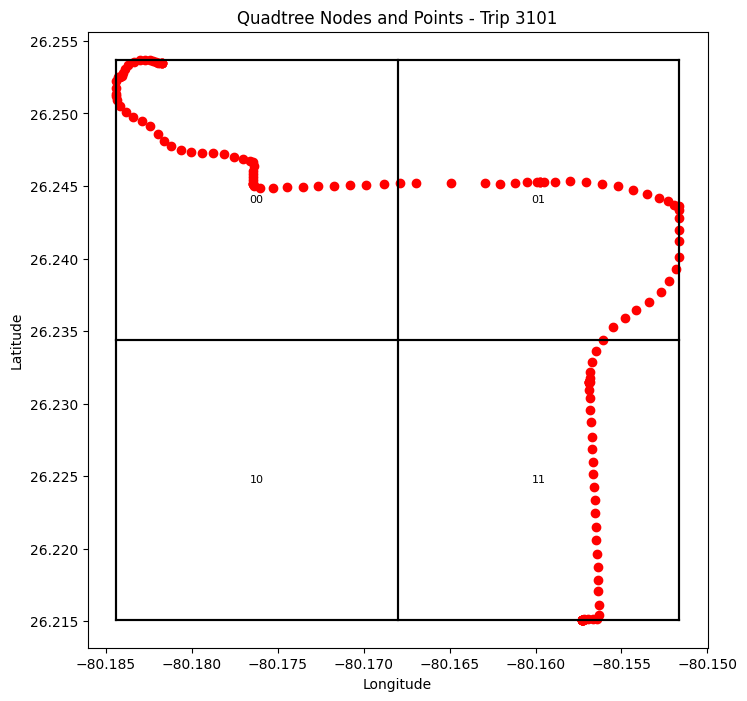

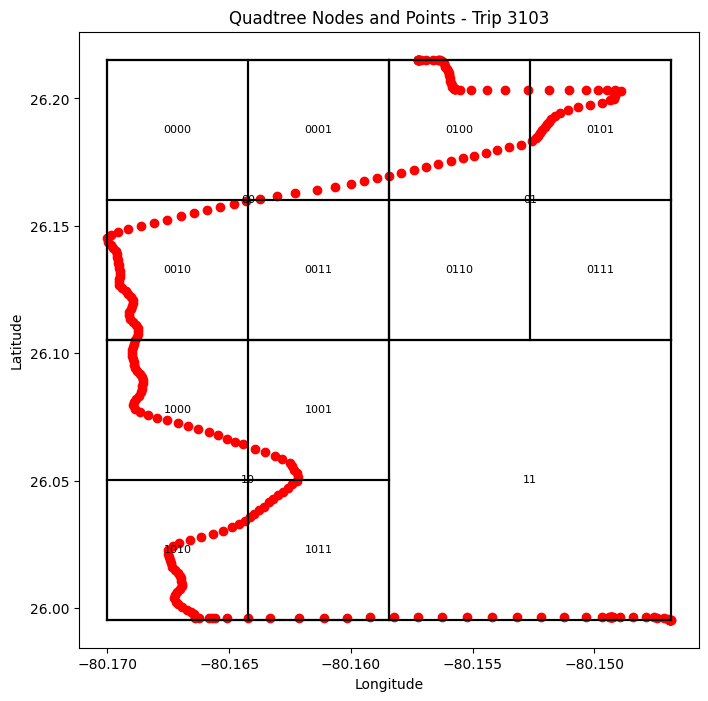

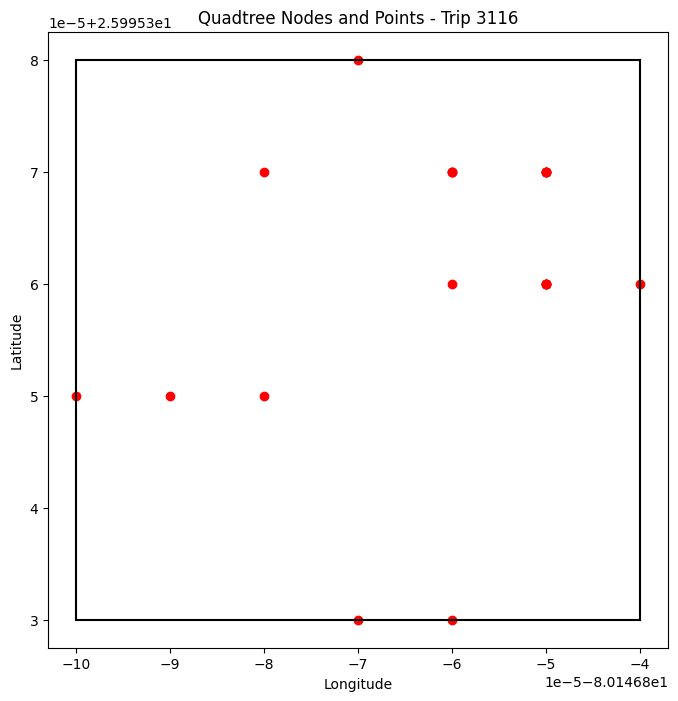

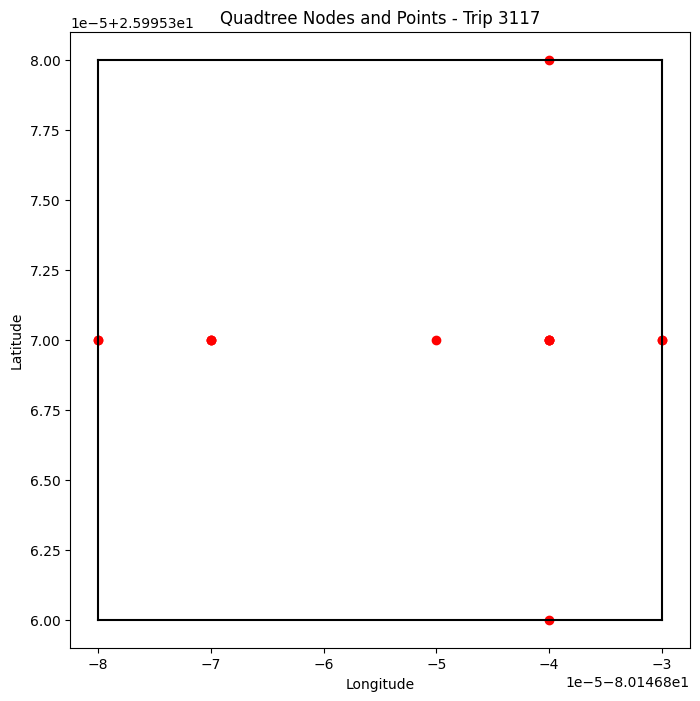

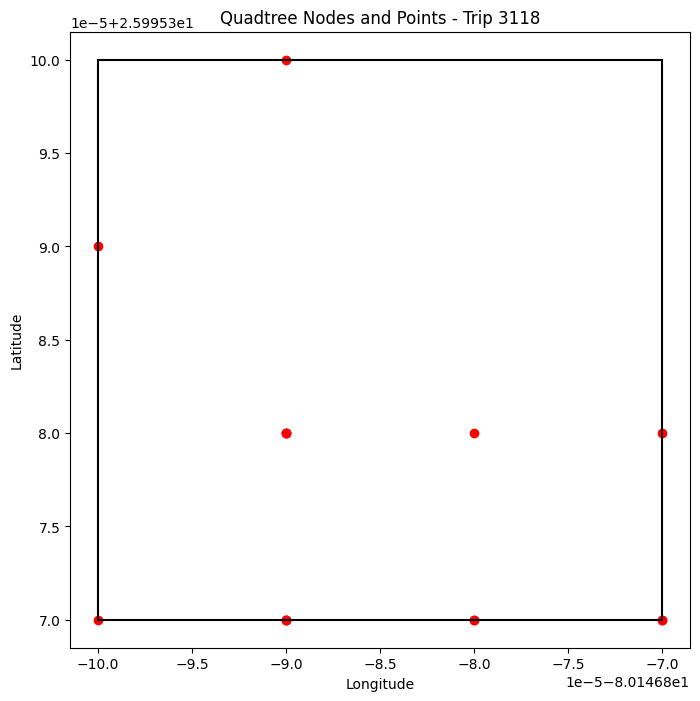

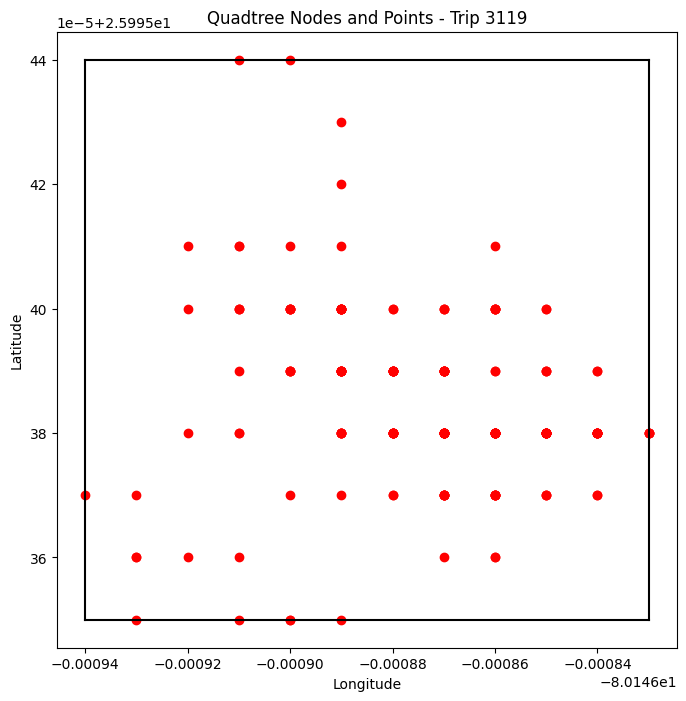

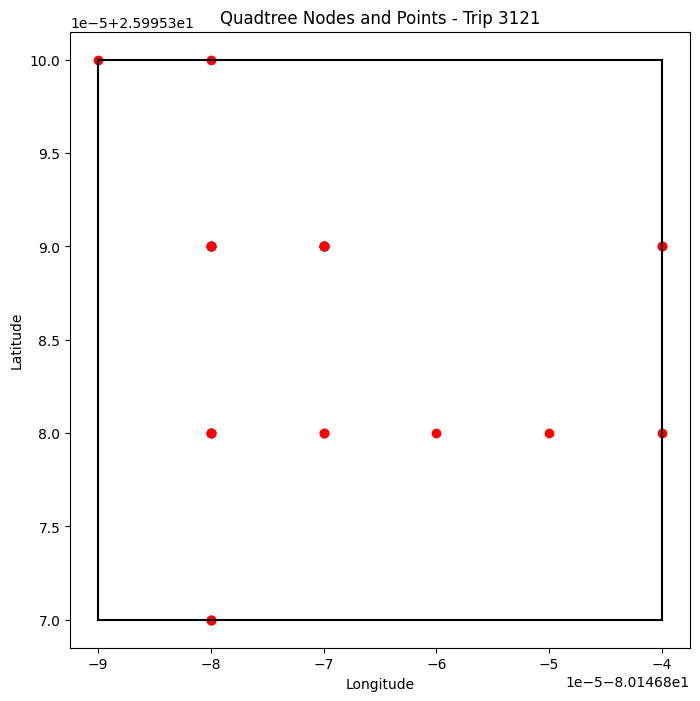

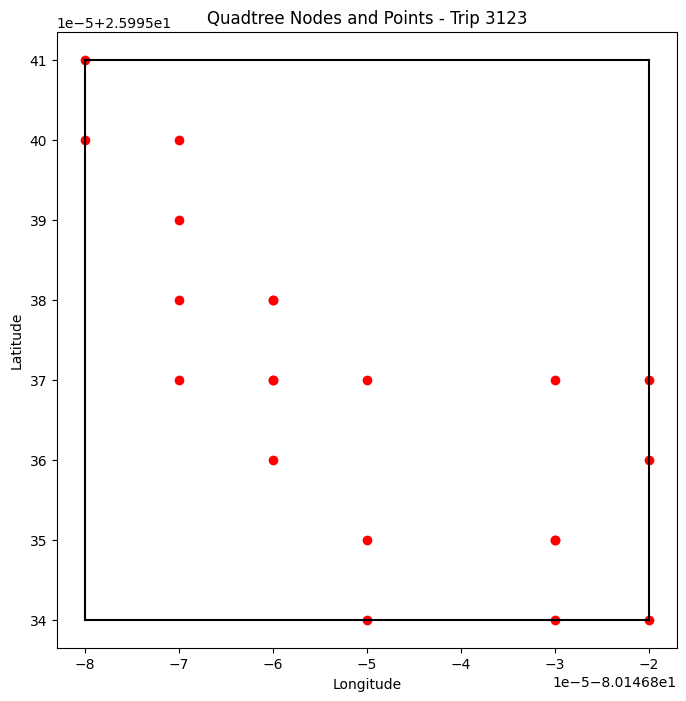

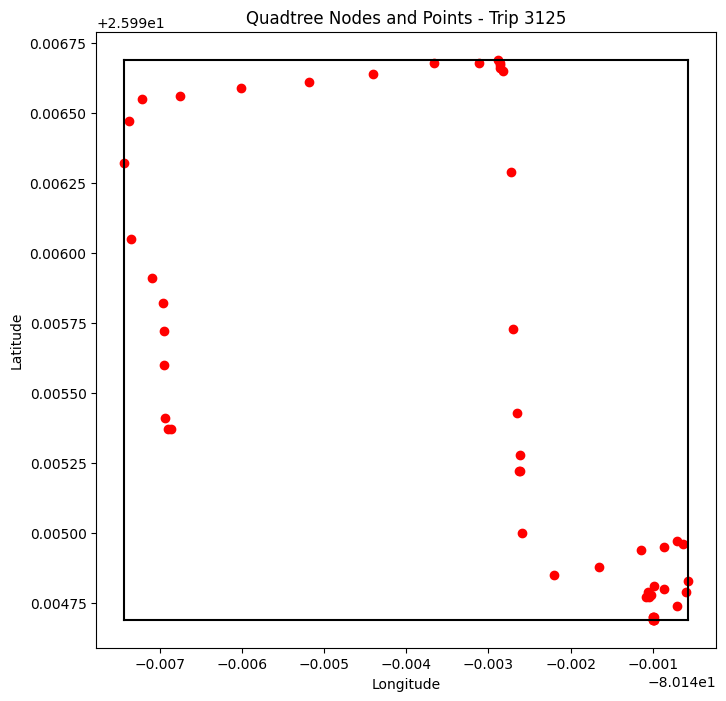

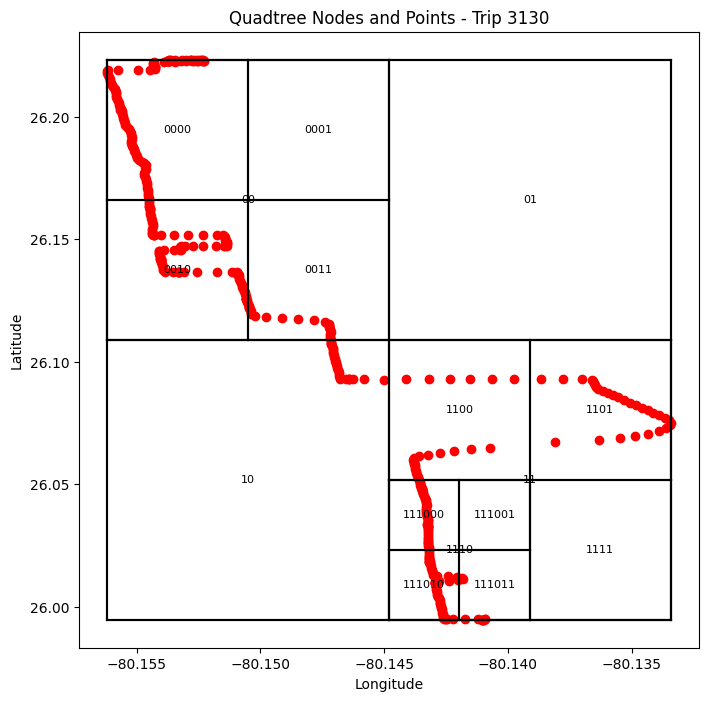

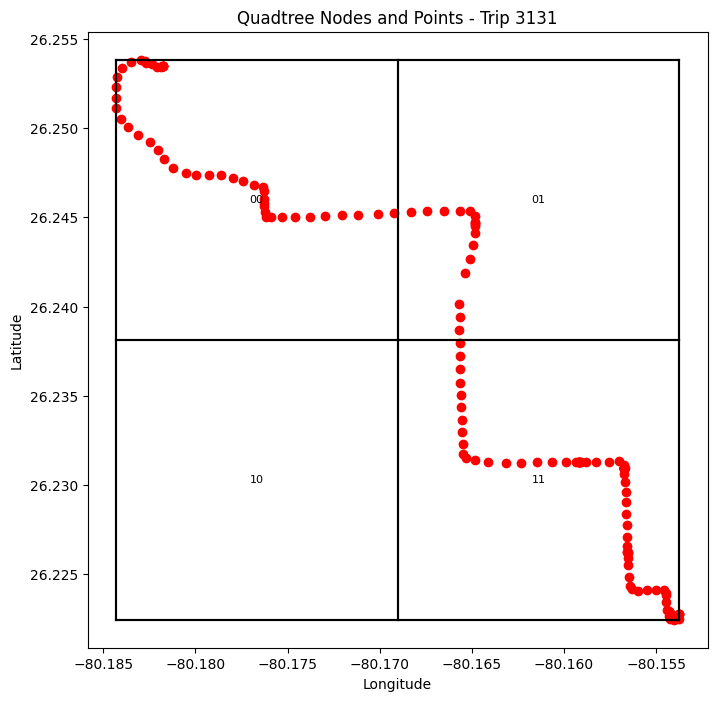

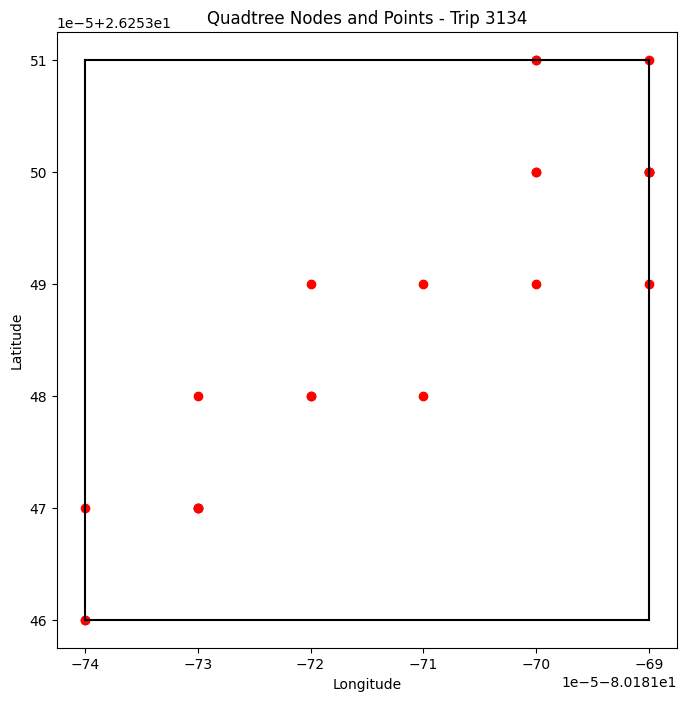

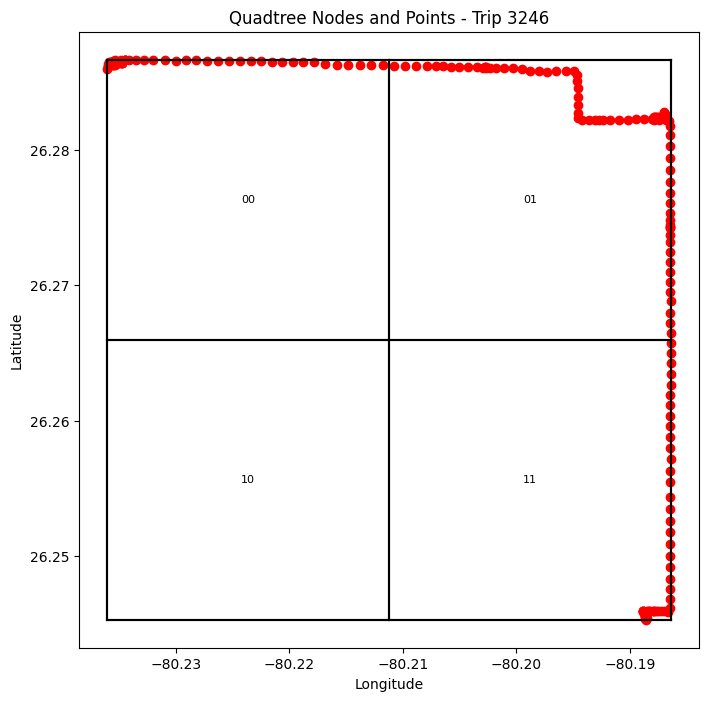

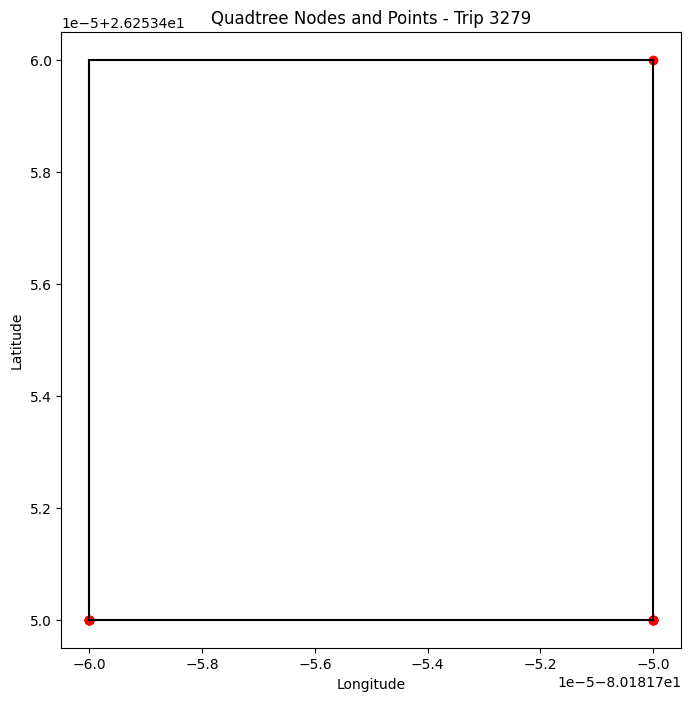

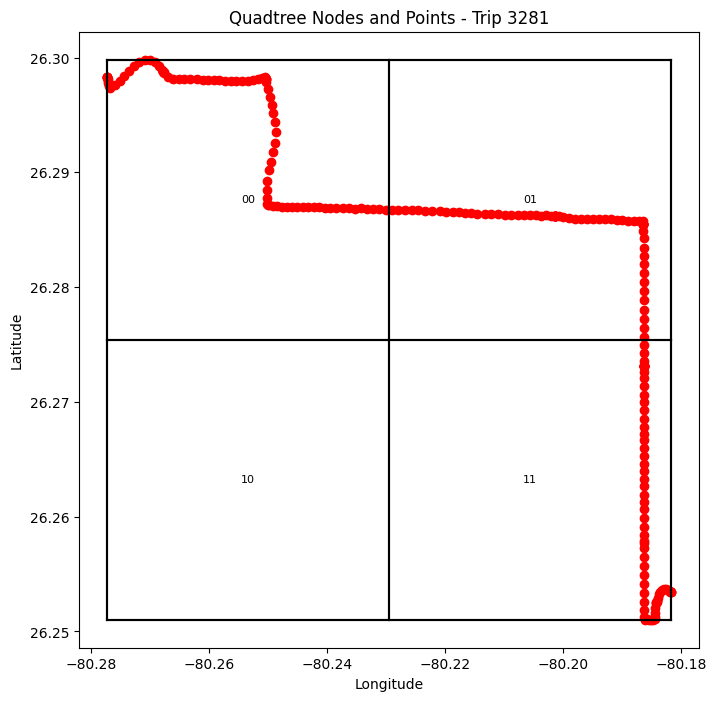

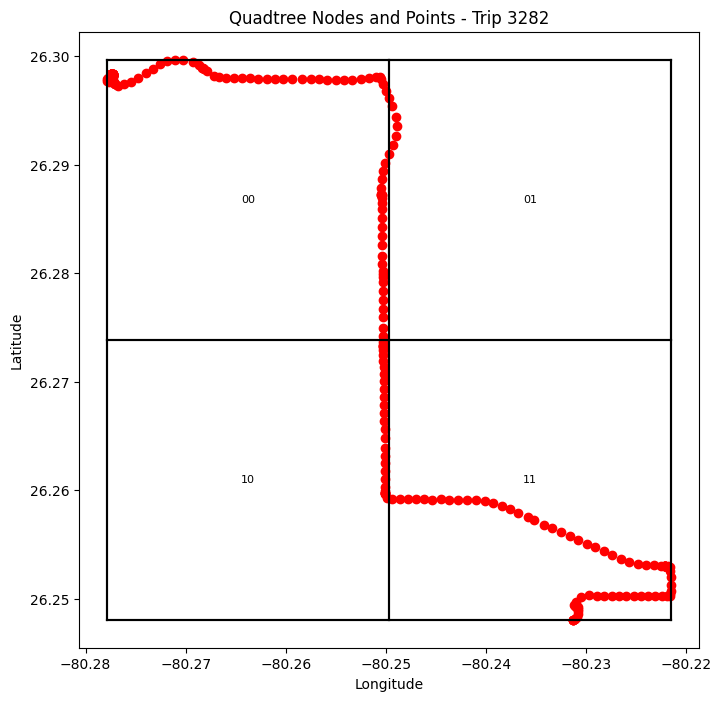

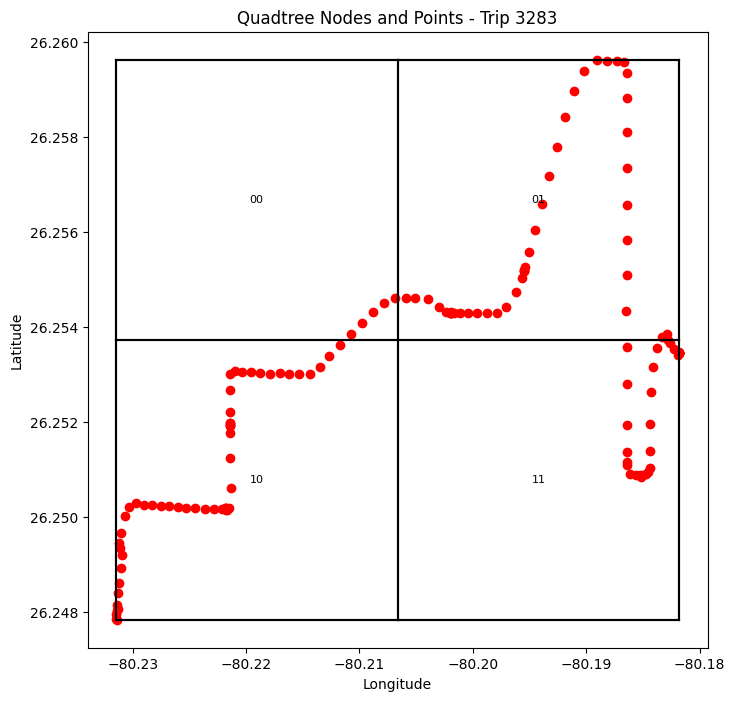

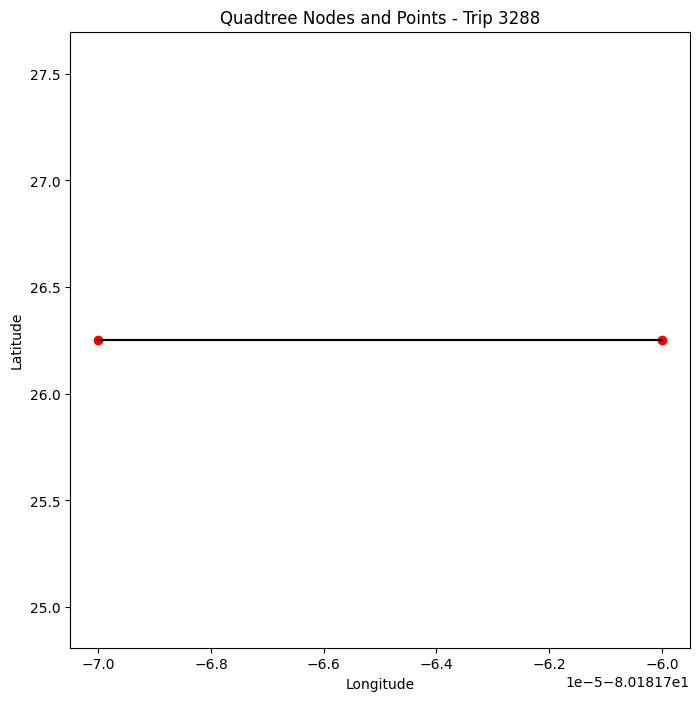

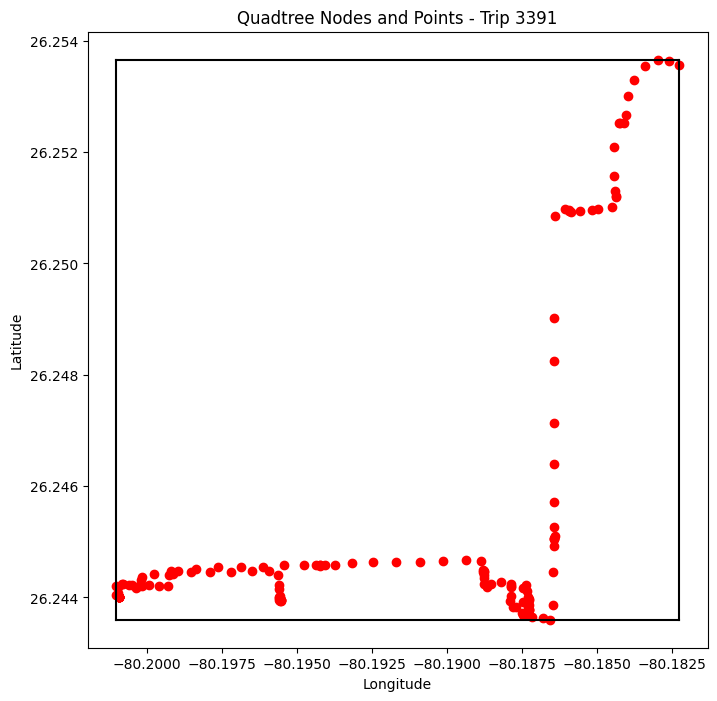

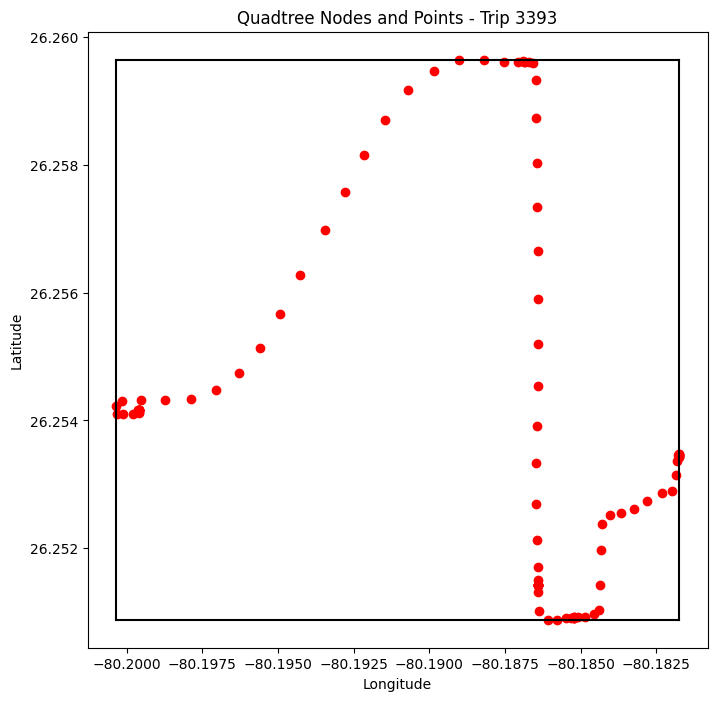

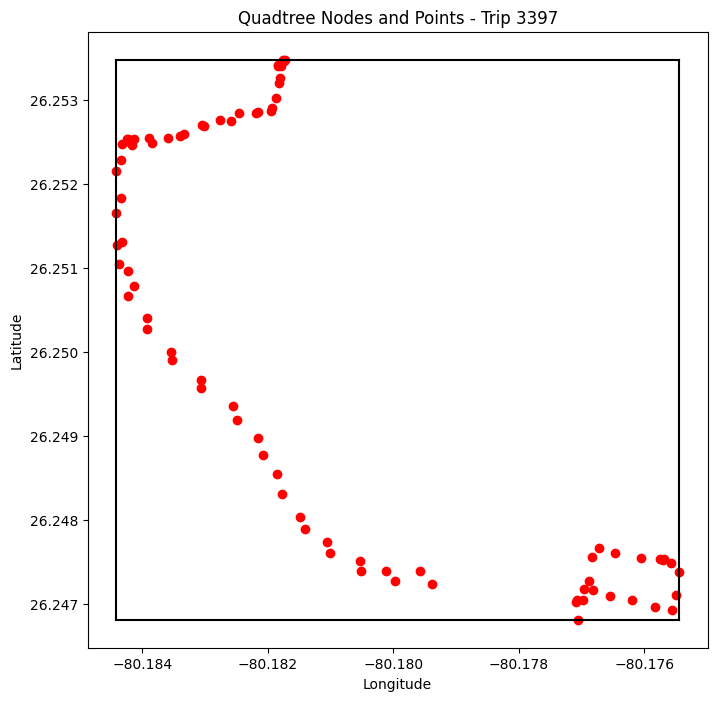

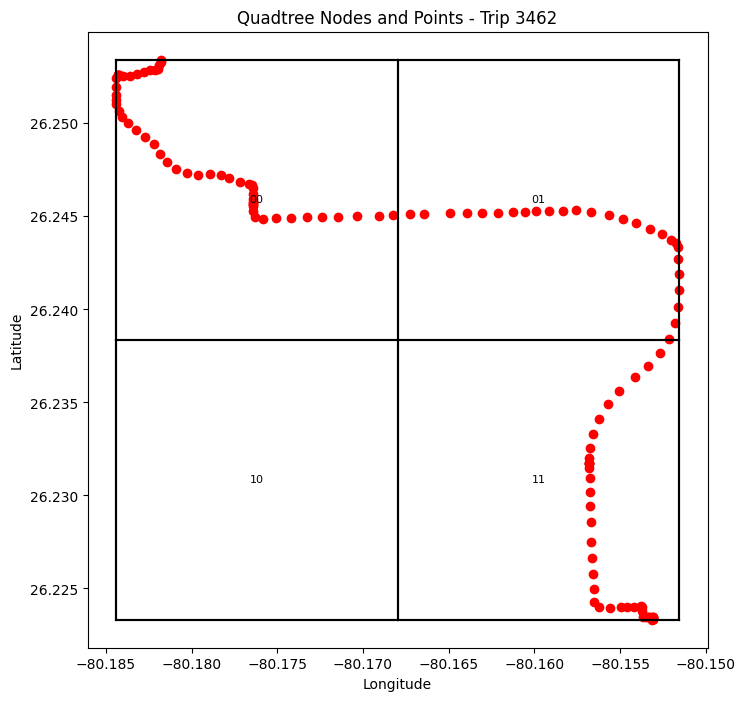

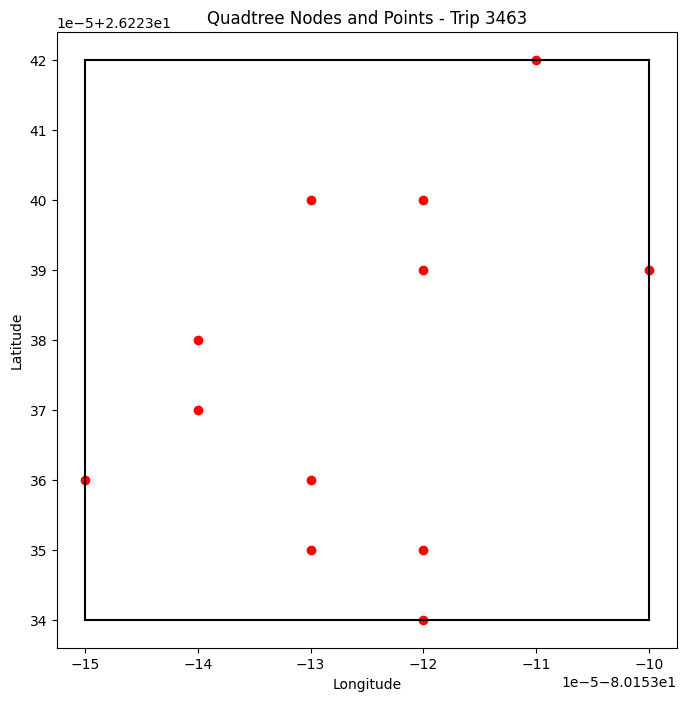

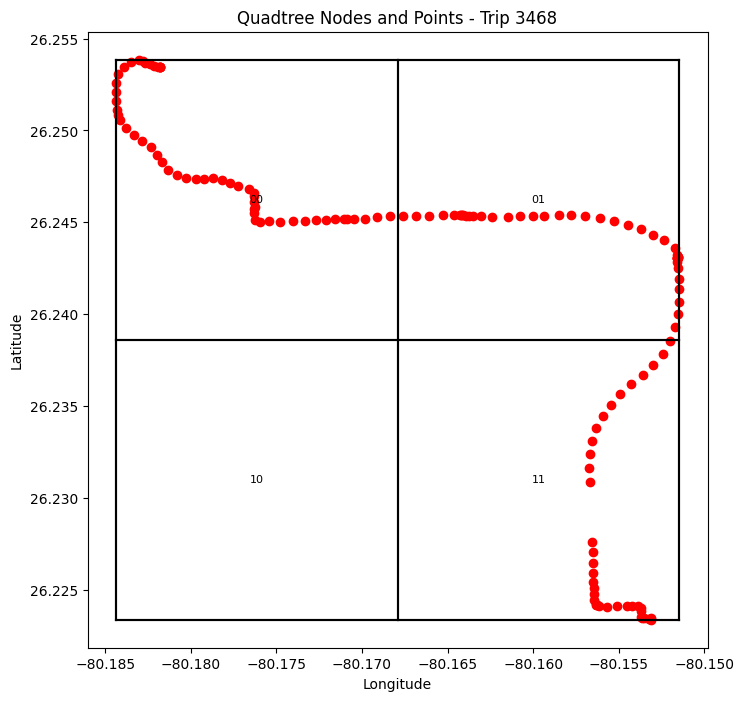

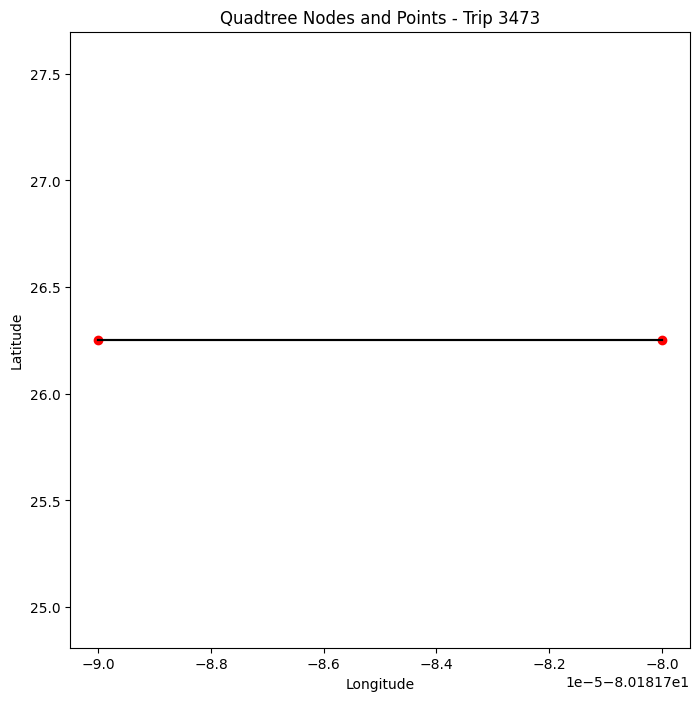

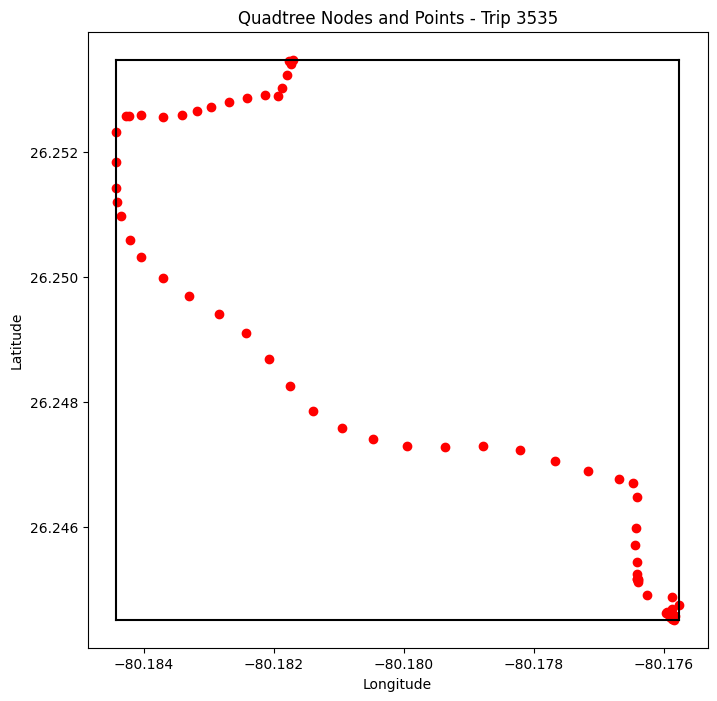

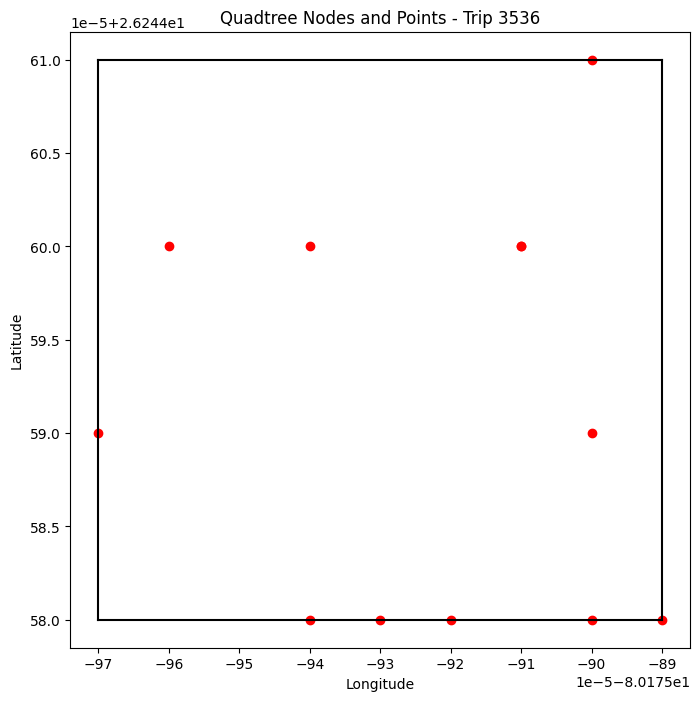

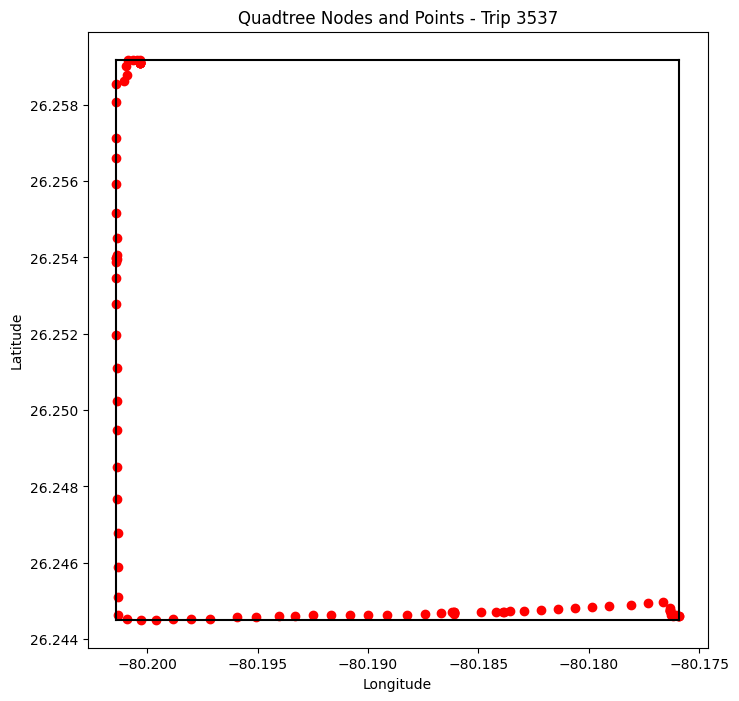

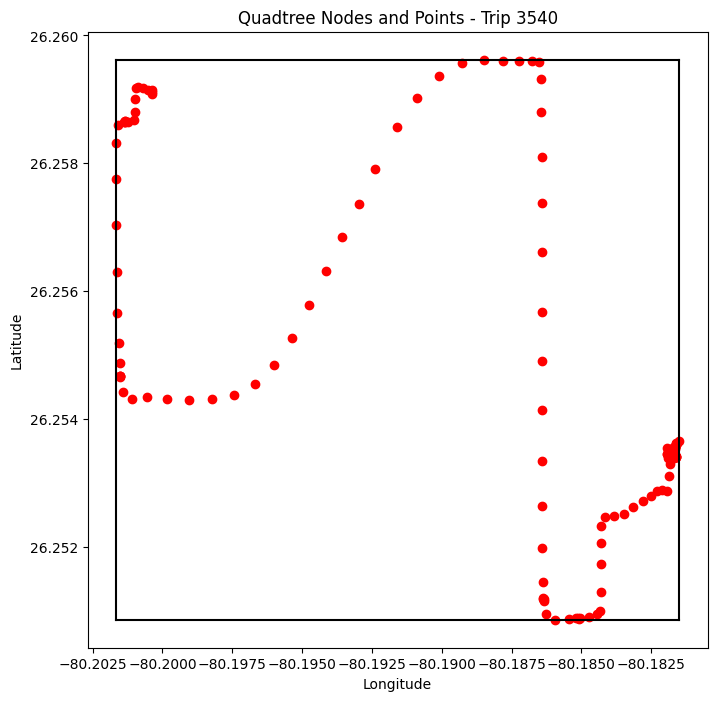

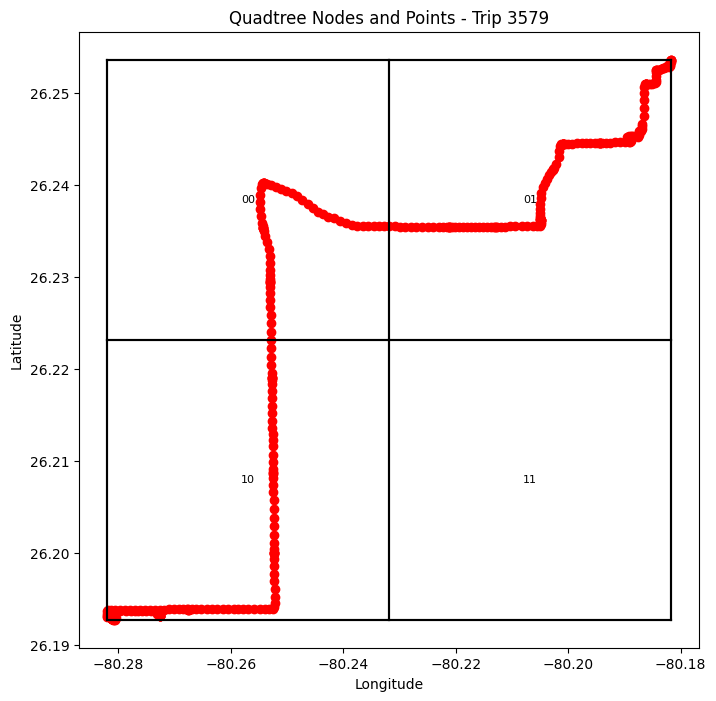

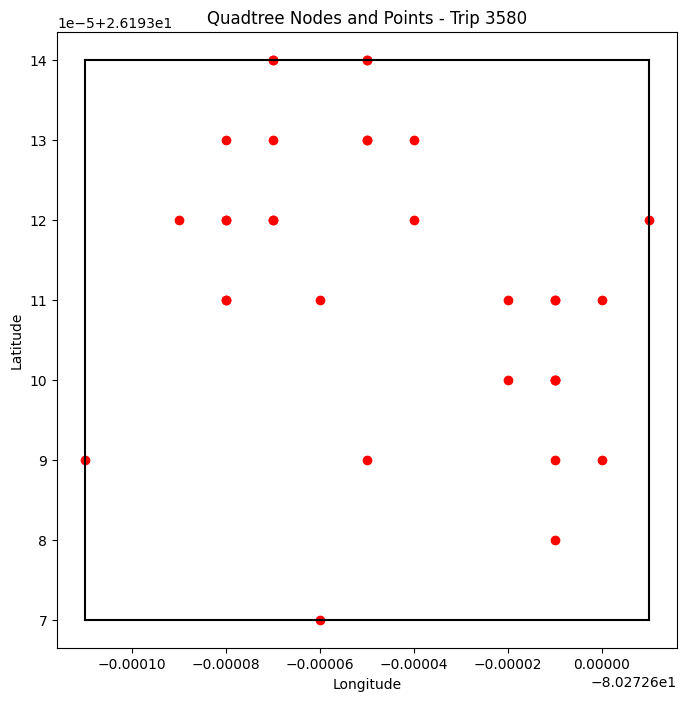

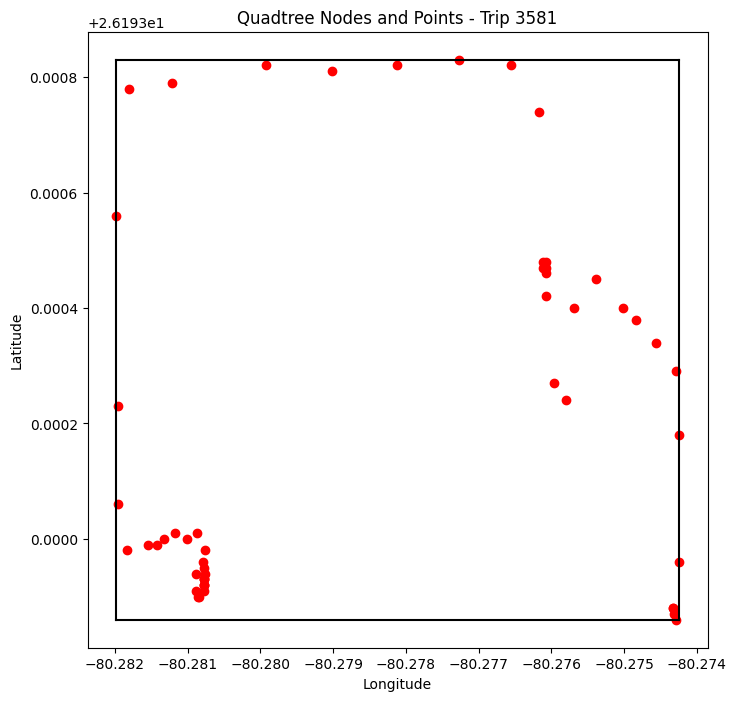

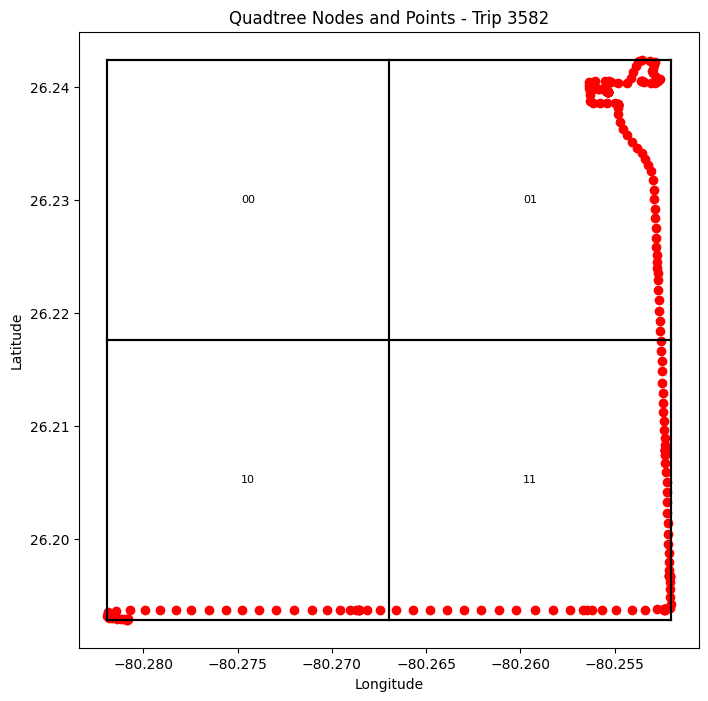

KeyboardInterrupt: 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class Point:
    def __init__(self, lat, lon, azimuth_rounded, distance):
        self.lat = lat
        self.lon = lon
        self.depth = None  # Depth of the point in the quadtree
        self.node_name = None  # Node name to be assigned later
        self.distance = distance  # Distance attribute for stopping criterion
        self.azimuth_rounded = azimuth_rounded  # Azimuth rounded attribute for stopping criterion

class BoundingBox:
    def __init__(self, min_lat, min_lon, max_lat, max_lon):
        self.min_lat = min_lat
        self.min_lon = min_lon
        self.max_lat = max_lat
        self.max_lon = max_lon

    def contains(self, point):
        return (self.min_lat <= point.lat <= self.max_lat and
                self.min_lon <= point.lon <= self.max_lon)

    def intersects(self, other):
        return not (self.max_lat < other.min_lat or self.min_lat > other.max_lat or
                    self.max_lon < other.min_lon or self.min_lon > other.max_lon)

class QuadTreeNode:
    node_count = 0

    def __init__(self, boundary, depth=0, parent_node=None, direction_from_parent=None):
        self.boundary = boundary  # Boundary of the node (bounding box)
        self.points = []  # List of points contained in this node
        self.children = [None, None, None, None]  # Children nodes (NW, NE, SW, SE)
        self.depth = depth  # Depth of the node in the quadtree
        self.node_name = self.generate_node_name(parent_node, direction_from_parent)  # Name of the node
        QuadTreeNode.node_count += 1  # Increment node count

    def generate_node_name(self, parent_node, direction_from_parent):
        direction_binary = {
            'NW': '00',
            'NE': '01',
            'SW': '10',
            'SE': '11'
        }

        if parent_node is None:
            return ''

        parent_name = parent_node.node_name

        return parent_name + direction_binary.get(direction_from_parent, 'Unknown')

    def insert(self, point):
        if not self.boundary.contains(point):
            return False

        # Check if all points in the node have the same azimuth_rounded
        if len(self.points)> 3 and any(p.azimuth_rounded != point.azimuth_rounded for p in self.points):
            if self.calculate_distance_sum() < 5:
                point.depth = self.depth  # Assign depth to the point
                point.node_name = self.node_name  # Assign node_name to the point
                self.points.append(point)
                return True

            if self.children[0] is None:
                self.subdivide()

            for child in self.children:
                if child is not None and child.insert(point):
                    return True
        else:
            point.depth = self.depth  # Assign depth to the point
            point.node_name = self.node_name  # Assign node_name to the point
            self.points.append(point)
            return True

        return False

    def subdivide(self):
        min_lat, min_lon, max_lat, max_lon = self.boundary.min_lat, self.boundary.min_lon, self.boundary.max_lat, self.boundary.max_lon
        mid_lat = (min_lat + max_lat) / 2
        mid_lon = (min_lon + max_lon) / 2

        nw_boundary = BoundingBox(mid_lat, min_lon, max_lat, mid_lon)
        ne_boundary = BoundingBox(mid_lat, mid_lon, max_lat, max_lon)
        sw_boundary = BoundingBox(min_lat, min_lon, mid_lat, mid_lon)
        se_boundary = BoundingBox(min_lat, mid_lon, mid_lat, max_lon)

        self.children[0] = QuadTreeNode(nw_boundary, self.depth + 1, self, 'NW')
        self.children[1] = QuadTreeNode(ne_boundary, self.depth + 1, self, 'NE')
        self.children[2] = QuadTreeNode(sw_boundary, self.depth + 1, self, 'SW')
        self.children[3] = QuadTreeNode(se_boundary, self.depth + 1, self, 'SE')

        points = self.points
        self.points = []
        for point in points:
            for child in self.children:
                if child.insert(point):
                    break

    def query_range(self, range_boundary):
        found_points = []

        if not self.boundary.intersects(range_boundary):
            return found_points

        for point in self.points:
            if range_boundary.contains(point):
                found_points.append(point)

        for child in self.children:
            if child is not None:
                found_points.extend(child.query_range(range_boundary))

        return found_points

    def calculate_distance_sum(self):
        return sum(point.distance for point in self.points)

depth_data = {'Trip Number': [], 'lat': [], 'lon': [], 'Depth': [], 'Node Name': [], 'Azimuth Rounded': []}

for trip_number, group in grouped:
    points = [Point(row['lat'], row['lon'], row['direction'], row['distance']) for idx, row in group.iterrows()]

    min_lat = min(points, key=lambda p: p.lat).lat
    max_lat = max(points, key=lambda p: p.lat).lat
    min_lon = min(points, key=lambda p: p.lon).lon
    max_lon = max(points, key=lambda p: p.lon).lon
    trip_boundary = BoundingBox(min_lat, min_lon, max_lat, max_lon)

    quadtree = QuadTreeNode(trip_boundary)

    for point in points:
        quadtree.insert(point)

    for point in points:
        depth_data['Trip Number'].append(trip_number)
        depth_data['lat'].append(point.lat)
        depth_data['lon'].append(point.lon)
        depth_data['Depth'].append(point.depth)
        depth_data['Node Name'].append(point.node_name)
        depth_data['Azimuth Rounded'].append(point.azimuth_rounded)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f"Quadtree Nodes and Points - Trip {trip_number}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    def plot_quadtree(node):
        if node is None:
            return
        min_lat, min_lon, max_lat, max_lon = node.boundary.min_lat, node.boundary.min_lon, node.boundary.max_lat, node.boundary.max_lon
        ax.plot([min_lon, max_lon], [min_lat, min_lat], color='black')
        ax.plot([min_lon, max_lon], [max_lat, max_lat], color='black')
        ax.plot([min_lon, min_lon], [min_lat, max_lat], color='black')
        ax.plot([max_lon, max_lon], [min_lat, max_lat], color='black')

        ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2, node.node_name, horizontalalignment='center', verticalalignment='center', fontsize=8)

        for child in node.children:
            plot_quadtree(child)

    plot_quadtree(quadtree)
    latitudes = [point.lat for point in points]
    longitudes = [point.lon for point in points]
    ax.scatter(longitudes, latitudes, c='red', marker='o')
    plt.show()

